In [2]:
#! mkdir -p src data scripts data/raw data/processed src/eda/ src/data_processing/ src/utils src/feature_engineering

# **Exploratory Data Analysis (EDA) for E-commerce and Bank Transaction Fraud Detection**

This notebook serves as the core of our Exploratory Data Analysis (EDA) phase for improving the detection of fraud cases for e-commerce and bank credit transactions. Its primary goal is to develop a foundational understanding of both datasets, assess their quality, and uncover initial patterns that will inform our feature engineering and model development.

We will leverage a modular set of Python scripts (`src/data_processing/` and `src/eda/`) for data loading, preprocessing, summarization, and various analytical techniques (univariate, bivariate, multivariate, missing value, outlier, and temporal analysis). This modular approach promotes clean code, reusability, and reproducibility, aligning with best practices in Data Engineering and Machine Learning Engineering.

## **Table of Contents**

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Preprocessing and Feature Engineering (Conditional)](#2-data-preprocessing-and-feature-engineering-conditional)
3. [EDA for E-commerce Fraud Data (Fraud_Data.csv)](#3-eda-for-e-commerce-fraud-data-fraud_data.csv)
    - [Data Understanding and Initial Quality Check](#3.1-data-understanding-and-initial-quality-check)
    - [Missing Values Analysis](#3.2-missing-values-analysis)
    - [Univariate Analysis](#3.3-univariate-analysis)
    - [Bivariate Analysis](#3.4-bivariate-analysis)
    - [Multivariate Analysis](#3.5-multivariate-analysis)
    - [Outlier Analysis](#3.6-outlier-analysis)
    - [Temporal Trend Analysis](#3.7-temporal-trend-analysis)
4. [EDA for Bank Credit Card Fraud Data (creditcard.csv)](#4-eda-for-bank-credit-card-fraud-data-creditcard.csv)
    - [Data Understanding and Initial Quality Check](#4.1-data-understanding-and-initial-quality-check)
    - [Missing Values Analysis](#4.2-missing-values-analysis)
    - [Univariate Analysis](#4.3-univariate-analysis)
    - [Bivariate Analysis](#4.4-bivariate-analysis)
    - [Multivariate Analysis](#4.5-multivariate-analysis)
    - [Outlier Analysis](#4.6-outlier-analysis)
    - [Temporal Trend Analysis](#4.7-temporal-trend-analysis)
5. [Class Imbalance Handling Demonstration](#5-class-imbalance-handling-demonstration)
6. [Key Insights & Summary](#6-key-insights--summary)

## **1. Setup and Data Loading**

This section establishes our analytical environment by importing essential Python libraries for data manipulation, visualization, and numerical operations. Crucially, we also import our custom modular functions and classes from the `src/` directory. This ensures that data loading, preprocessing, and various analytical steps are handled by dedicated, reusable components.

**Note on Data:** This notebook expects the `Fraud_Data.csv`, `IpAddress_to_Country.csv`, and `creditcard.csv` files to be placed in the `data/raw/` directory of your project. Please ensure the files are downloaded and correctly placed before running this notebook.

### Import Necessary Libraries and Custom Modules

In [3]:
# Core Libraries for Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np
from pathlib import Path
import os # For path operations

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For handling class imbalance (SMOTE)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Add the project root directory to the system path.
# This allows Python to correctly locate and import our custom modules
# (e.g., from `src.data_processing.loader`) regardless of where the notebook is run from.
import sys
project_root = Path.cwd() # Navigates from 'notebooks/' directory to the project root
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import Custom Modular Functions and Classes
from src.data_processing.loader import load_data
from src.data_processing.preprocessor import FraudDataProcessor, CreditCardDataProcessor
from src.utils.helpers import merge_ip_to_country

# Data Inspection Utilities (includes strategies for dtypes and summary statistics)
from src.eda.data_inspection import DataInspector, DataTypesAndNonNullInspectionStrategy, SummaryStatisticsInspectionStrategy

# Univariate Analysis Utilities
from src.eda.univariate_analysis import UnivariateAnalyzer, NumericalUnivariateAnalysis, CategoricalUnivariateAnalysis

# Bivariate Analysis Utilities
from src.eda.bivariate_analysis import BivariateAnalyzer, NumericalVsNumericalAnalysis, CategoricalVsNumericalAnalysis, CategoricalVsCategoricalAnalysis

# Multivariate Analysis Utilities
from src.eda.multivariate_analysis import SimpleMultivariateAnalysis

# Missing Values Analysis Utilities
from src.eda.missing_values_analysis import SimpleMissingValuesAnalysis

# Outlier Analysis Utilities
from src.eda.outlier_analysis import OutlierAnalyzer, IQRBasedOutlierAnalysis

# Temporal Analysis Utilities
from src.eda.temporal_analysis import TemporalAnalyzer, MonthlyTrendAnalysis

# Define constants for target columns (consistent with run_data_pipeline.py and run_train.py)
FRAUD_TARGET_COL = 'class'
CREDITCARD_TARGET_COL = 'Class'


#### Set Plotting Style

In [4]:
# Configure Matplotlib and Seaborn for consistent and aesthetic plots
sns.set_style("whitegrid") # Provides a clean, modern look with a grid
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size for plots
plt.rcParams['font.size'] = 12 # Base font size for readability
plt.rcParams['axes.labelsize'] = 14 # Font size for axis labels
plt.rcParams['xtick.labelsize'] = 12 # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12 # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 12 # Font size for plot legends
plt.rcParams['font.family'] = 'sans-serif' # Use a default sans-serif font

### Loading Data (Prioritizing Preprocessed Data)
We will first attempt to load the preprocessed datasets from `data/processed/`. If these files are not found, we will fall back to loading and preprocessing the raw data from `data/raw/`.

In [5]:
# Define data directories and file paths
RAW_DATA_DIR = project_root / "data" / "raw"
PROCESSED_DATA_DIR = project_root / "data" / "processed"

FRAUD_DATA_RAW_PATH = RAW_DATA_DIR / "Fraud_Data.csv"
IP_TO_COUNTRY_RAW_PATH = RAW_DATA_DIR / "IpAddress_to_Country.csv"
CREDITCARD_DATA_RAW_PATH = RAW_DATA_DIR / "creditcard.csv"

FRAUD_PROCESSED_PATH = PROCESSED_DATA_DIR / "fraud_processed.csv"
CREDITCARD_PROCESSED_PATH = PROCESSED_DATA_DIR / "creditcard_processed.csv"

# Ensure processed data directory exists
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

fraud_processed_df = pd.DataFrame()
creditcard_processed_df = pd.DataFrame()

# --- Attempt to load processed data first ---
print("\n--- Attempting to Load Preprocessed Datasets ---")
if FRAUD_PROCESSED_PATH.exists():
    fraud_processed_df = load_data(FRAUD_PROCESSED_PATH)
    if not fraud_processed_df.empty:
        print(f"Successfully loaded processed E-commerce Fraud Data from {FRAUD_PROCESSED_PATH}.")
    else:
        print(f"Processed E-commerce Fraud Data at {FRAUD_PROCESSED_PATH} is empty or corrupted. Will re-process.")
else:
    print(f"Processed E-commerce Fraud Data not found at {FRAUD_PROCESSED_PATH}. Will proceed with raw data preprocessing.")

if CREDITCARD_PROCESSED_PATH.exists():
    creditcard_processed_df = load_data(CREDITCARD_PROCESSED_PATH)
    if not creditcard_processed_df.empty:
        print(f"Successfully loaded processed Bank Credit Card Fraud Data from {CREDITCARD_PROCESSED_PATH}.")
    else:
        print(f"Processed Bank Credit Card Fraud Data at {CREDITCARD_PROCESSED_PATH} is empty or corrupted. Will re-process.")
else:
    print(f"Processed Bank Credit Card Fraud Data not found at {CREDITCARD_PROCESSED_PATH}. Will proceed with raw data preprocessing.")


raw_data_needed = fraud_processed_df.empty or creditcard_processed_df.empty

if raw_data_needed:
    print("\n--- Raw Data Loading and Preprocessing Initiated ---")
    # Check if all required raw data files exist
    required_raw_files = [FRAUD_DATA_RAW_PATH, IP_TO_COUNTRY_RAW_PATH, CREDITCARD_DATA_RAW_PATH]
    all_raw_files_exist = True
    for file_path in required_raw_files:
        if not file_path.exists():
            print(f"Error: Required raw data file '{file_path.name}' not found in '{RAW_DATA_DIR}'. Please place it there.")
            all_raw_files_exist = False

    if not all_raw_files_exist:
        print("\nSkipping raw data loading and preprocessing due to missing required raw data files.")
        # If raw data is missing and processed data also failed, we cannot proceed.
        # Set dataframes to empty to prevent subsequent EDA steps from running on non-existent data.
        fraud_data_df_raw = pd.DataFrame()
        ip_country_df_raw = pd.DataFrame()
        creditcard_df_raw = pd.DataFrame()
    else:
        print("\n--- Loading Raw Datasets ---")
        # Explicitly specify dtypes for IP address columns to prevent string accessor errors
        fraud_data_df_raw = load_data(
            FRAUD_DATA_RAW_PATH,
            column_dtypes={'ip_address': str}
        )
        ip_country_df_raw = load_data(
            IP_TO_COUNTRY_RAW_PATH,
            column_dtypes={'lower_bound_ip_address': str, 'upper_bound_ip_address': str}
        )
        creditcard_df_raw = load_data(CREDITCARD_DATA_RAW_PATH)

        print("Raw data loading complete.")

        # If processed data was not loaded, proceed with preprocessing
        if fraud_processed_df.empty and not fraud_data_df_raw.empty:
            print("\n--- Preprocessing E-commerce Fraud Data (Fraud_Data.csv) ---")
            # Merge IP addresses to countries first (this is a helper function)
            fraud_df_merged = merge_ip_to_country(fraud_data_df_raw.copy(), ip_country_df_raw.copy())

            # Separate features and target
            if FRAUD_TARGET_COL in fraud_df_merged.columns:
                X_fraud = fraud_df_merged.drop(columns=[FRAUD_TARGET_COL])
                y_fraud = fraud_df_merged[FRAUD_TARGET_COL]
            else:
                print(f"Warning: Target column '{FRAUD_TARGET_COL}' not found in Fraud_Data.csv. Using a dummy target.")
                X_fraud = fraud_df_merged.copy()
                y_fraud = pd.Series([0] * len(X_fraud), index=X_fraud.index) # Dummy target

            # Rename columns in X_fraud to match generic names expected by FraudDataProcessor
            X_fraud_renamed = X_fraud.rename(columns={
                'user_id': 'CustomerId',
                'purchase_value': 'Amount',
                'purchase_time': 'TransactionStartTime',
                'user_id': 'TransactionId' # Using user_id as a proxy for TransactionId for frequency count
            }).copy()

            # Define columns for FraudDataProcessor using the *renamed* names
            fraud_numerical_features_renamed = ['Amount', 'age']
            fraud_categorical_features_renamed = ['source', 'browser', 'sex', 'country']
            fraud_purchase_time_col_renamed = 'TransactionStartTime'
            fraud_signup_time_col_renamed = 'signup_time'
            fraud_amount_col_renamed = 'Amount'
            fraud_id_cols_for_agg_renamed = ['CustomerId', 'device_id', 'ip_address']

            fraud_processor = FraudDataProcessor(
                numerical_cols_after_rename=fraud_numerical_features_renamed,
                categorical_cols_after_merge=fraud_categorical_features_renamed,
                time_col_after_rename=fraud_purchase_time_col_renamed,
                signup_time_col_after_rename=fraud_signup_time_col_renamed,
                amount_col_after_rename=fraud_amount_col_renamed,
                id_cols_for_agg_after_rename=fraud_id_cols_for_agg_renamed
            )

            print("Applying preprocessing pipeline to Fraud_Data.csv...")
            X_fraud_processed = fraud_processor.fit_transform(X_fraud_renamed, y_fraud)

            # Re-attach target
            fraud_processed_df = pd.concat([X_fraud_processed, y_fraud.rename(FRAUD_TARGET_COL)], axis=1)
            print("E-commerce Fraud Data preprocessing complete.")

            # Save processed Fraud Data
            if not fraud_processed_df.empty:
                fraud_output_path = PROCESSED_DATA_DIR / "fraud_processed.csv"
                fraud_processed_df.to_csv(fraud_output_path, index=False)
                print(f"Processed E-commerce Fraud Data saved to: {fraud_output_path}")
            else:
                print("No processed E-commerce Fraud Data to save.")

        if creditcard_processed_df.empty and not creditcard_df_raw.empty:
            print("\n--- Preprocessing Bank Credit Card Fraud Data (creditcard.csv) ---")
            # Separate features and target
            if CREDITCARD_TARGET_COL in creditcard_df_raw.columns:
                X_creditcard = creditcard_df_raw.drop(columns=[CREDITCARD_TARGET_COL])
                y_creditcard = creditcard_df_raw[CREDITCARD_TARGET_COL]
            else:
                print(f"Warning: Target column '{CREDITCARD_TARGET_COL}' not found in creditcard.csv. Proceeding without target.")
                X_creditcard = creditcard_df_raw.copy()
                y_creditcard = pd.Series([0] * len(X_creditcard), index=X_creditcard.index) # Dummy target

            # All V features, Time, Amount are numerical.
            creditcard_numerical_features = [col for col in X_creditcard.columns if col not in []]

            creditcard_processor = CreditCardDataProcessor(
                numerical_cols=creditcard_numerical_features
            )

            print("Applying preprocessing pipeline to creditcard.csv...")
            X_creditcard_processed = creditcard_processor.fit_transform(X_creditcard, y_creditcard)

            # Re-attach target
            creditcard_processed_df = pd.concat([X_creditcard_processed, y_creditcard.rename(CREDITCARD_TARGET_COL)], axis=1)
            print("Bank Credit Card Fraud Data preprocessing complete.")

            # Save processed Credit Card Data
            if not creditcard_processed_df.empty:
                creditcard_output_path = PROCESSED_DATA_DIR / "creditcard_processed.csv"
                creditcard_processed_df.to_csv(creditcard_output_path, index=False)
                print(f"Processed Bank Credit Card Fraud Data saved to: {creditcard_output_path}")
            else:
                print("No processed Bank Credit Card Fraud Data to save.")
else:
    print("No raw data loaded or processed data found. Skipping preprocessing section.")



--- Attempting to Load Preprocessed Datasets ---
Successfully loaded 151112 rows from E-commerce-Bank-Fraud-Detection/data/processed/fraud_processed.csv.
Successfully loaded processed E-commerce Fraud Data from /home/micha/Downloads/course/10-accedemy/week-8-9/E-commerce-Bank-Fraud-Detection/data/processed/fraud_processed.csv.
Successfully loaded 283726 rows from E-commerce-Bank-Fraud-Detection/data/processed/creditcard_processed.csv.
Successfully loaded processed Bank Credit Card Fraud Data from /home/micha/Downloads/course/10-accedemy/week-8-9/E-commerce-Bank-Fraud-Detection/data/processed/creditcard_processed.csv.
No raw data loaded or processed data found. Skipping preprocessing section.


## **2. Data Preprocessing and Feature Engineering (Conditional)**

This section applies the preprocessing and feature engineering pipelines defined in `src/data_processing/preprocessor.py` to both datasets. This includes handling missing values, correcting data types, creating new temporal and transaction-based features, and scaling/encoding features.

After processing, the engineered datasets will be saved to the `data/processed/` directory for use in subsequent modeling phases.

**NOTE:** This section will only run if the preprocessed data files (`fraud_processed.csv` and `creditcard_processed.csv`) were *not* found or were empty in the previous step. If they were successfully loaded, this section will be skipped.

### Preprocessing E-commerce Fraud Data (`Fraud_Data.csv`)

In [6]:
# This cell is now part of the conditional logic in the 'Loading Data' section above.
# Keeping it here as a placeholder for the Table of Contents, but the code has moved.
# The actual preprocessing will only run if processed files are not found.
print("Preprocessing code for E-commerce Fraud Data is now part of the 'Loading Data' section (Section 1). It runs conditionally.")
print("If you see this message, it means processed data was likely loaded, or raw data was missing.")

Preprocessing code for E-commerce Fraud Data is now part of the 'Loading Data' section (Section 1). It runs conditionally.
If you see this message, it means processed data was likely loaded, or raw data was missing.


### Preprocessing Bank Credit Card Fraud Data (`creditcard.csv`)

In [7]:
# This cell is now part of the conditional logic in the 'Loading Data' section above.
# Keeping it here as a placeholder for the Table of Contents, but the code has moved.
# The actual preprocessing will only run if processed files are not found.
print("Preprocessing code for Bank Credit Card Fraud Data is now part of the 'Loading Data' section (Section 1). It runs conditionally.")
print("If you see this message, it means processed data was likely loaded, or raw data was missing.")

Preprocessing code for Bank Credit Card Fraud Data is now part of the 'Loading Data' section (Section 1). It runs conditionally.
If you see this message, it means processed data was likely loaded, or raw data was missing.


## **3. EDA for E-commerce Fraud Data (Fraud_Data.csv)**

This section focuses on the Exploratory Data Analysis of the preprocessed E-commerce Fraud Data. We will apply various analytical techniques to understand the data's characteristics, distributions, relationships between features, and the nature of fraud within this dataset.

### **3.1 Data Understanding and Initial Quality Check**
This step provides an initial overview of the dataset's structure, including data types and non-null counts, and then presents summary statistics for numerical features. This helps in quickly grasping the scale, distribution, and potential issues within the data.

#### Data Structure and Quality Assessment (using `DataTypesAndNonNullInspectionStrategy`)

In [8]:
if not fraud_processed_df.empty:
    print("\n--- Data Types and Non-null Counts for E-commerce Fraud Data ---")
    inspector = DataInspector(DataTypesAndNonNullInspectionStrategy())
    inspector.execute_inspection(fraud_processed_df)
else:
    print("E-commerce Fraud Data is empty, skipping Data Structure and Quality Assessment.")



--- Data Types and Non-null Counts for E-commerce Fraud Data ---

--- Data Types and Non-null Counts ---
                                    Dtype  Non-Null Count  Null Count  \
TransactionMonth                  float64          151112           0   
device_id_transactions_last_30d   float64          151112           0   
CustomerId_transactions_last_1d   float64          151112           0   
time_since_signup                 float64          151112           0   
CustomerId_avg_amount_last_7d     float64          151112           0   
TransactionHour                   float64          151112           0   
ip_address_avg_amount_last_7d     float64          151112           0   
device_id_total_amount_last_1d    float64          151112           0   
device_id_avg_amount_last_1d      float64          151112           0   
TransactionDayOfWeek              float64          151112           0   
IsRefund                          float64          151112           0   
device_id_avg_amou

#### Descriptive Statistics & Variability (using `SummaryStatisticsInspectionStrategy`)

In [9]:
if not fraud_processed_df.empty:
    print("\n--- Summary Statistics for E-commerce Fraud Data ---")
    inspector = DataInspector(SummaryStatisticsInspectionStrategy())
    inspector.execute_inspection(fraud_processed_df)
else:
    print("E-commerce Fraud Data is empty, skipping Descriptive Statistics.")



--- Summary Statistics for E-commerce Fraud Data ---

--- Summary Statistics ---
       TransactionMonth  device_id_transactions_last_30d  \
count      1.511120e+05                     1.511120e+05   
mean       1.727079e-16                     6.921481e-17   
std        1.000003e+00                     1.000003e+00   
min       -1.882499e+00                    -1.929492e-01   
25%       -7.549457e-01                    -1.929492e-01   
50%       -3.243355e-03                    -1.929492e-01   
75%        7.484590e-01                    -1.929492e-01   
max        2.251864e+00                     1.325811e+01   

       CustomerId_transactions_last_1d  time_since_signup  \
count                         151112.0       1.511120e+05   
mean                               0.0      -3.761675e-17   
std                                0.0       1.000003e+00   
min                                0.0      -1.577617e+00   
25%                                0.0      -8.781362e-01   
50%        

### **3.2 Missing Values Analysis**
Missing data can significantly impact model performance and lead to biased results. This section identifies the extent of missing values and visualizes their patterns, guiding imputation or removal strategies in the feature engineering phase.

In [10]:
if not fraud_processed_df.empty:
    print("\n--- Missing Values Analysis for E-commerce Fraud Data ---")
    missing_analyzer = SimpleMissingValuesAnalysis()
    missing_analyzer.analyze(fraud_processed_df)
else:
    print("E-commerce Fraud Data is empty, skipping Missing Values Analysis.")



--- Missing Values Analysis for E-commerce Fraud Data ---

--- Missing Values Count by Column ---
No missing values found in the DataFrame.

Visualizing Missing Values...
No missing values to visualize.


### **3.3 Univariate Analysis**
Univariate analysis explores the distribution of individual features. This helps in understanding the range, central tendency, and spread of numerical data, and the frequency of categories in categorical data.


--- Univariate Analysis for E-commerce Fraud Data ---

--- Analyzing Numerical Feature: Amount ---


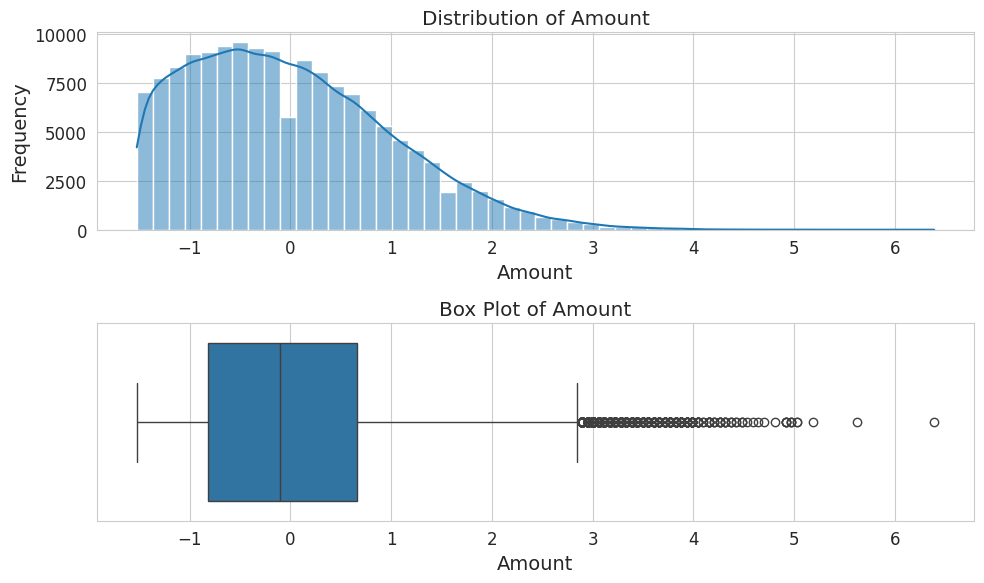


--- Analyzing Numerical Feature: age ---


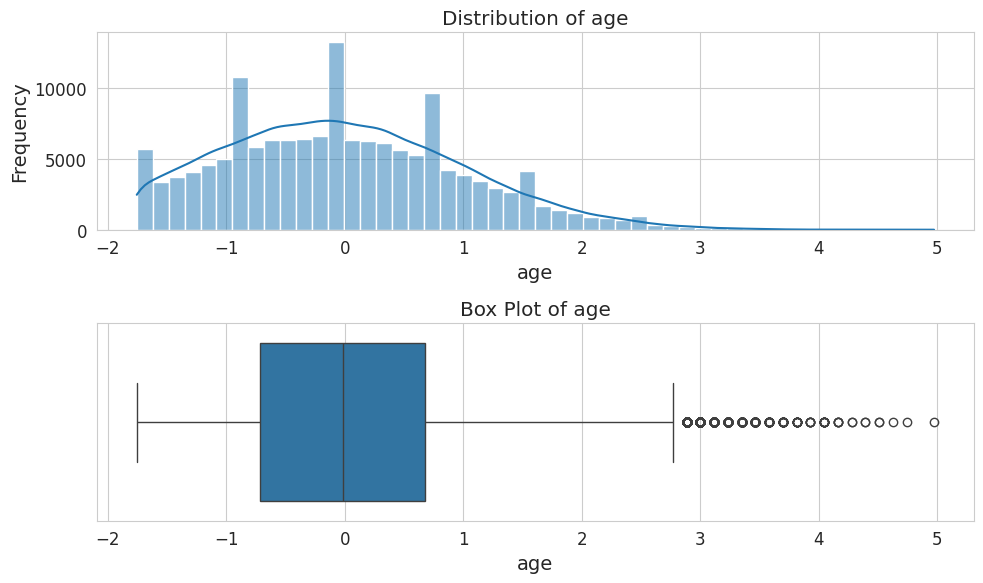


--- Analyzing Numerical Feature: IsRefund ---


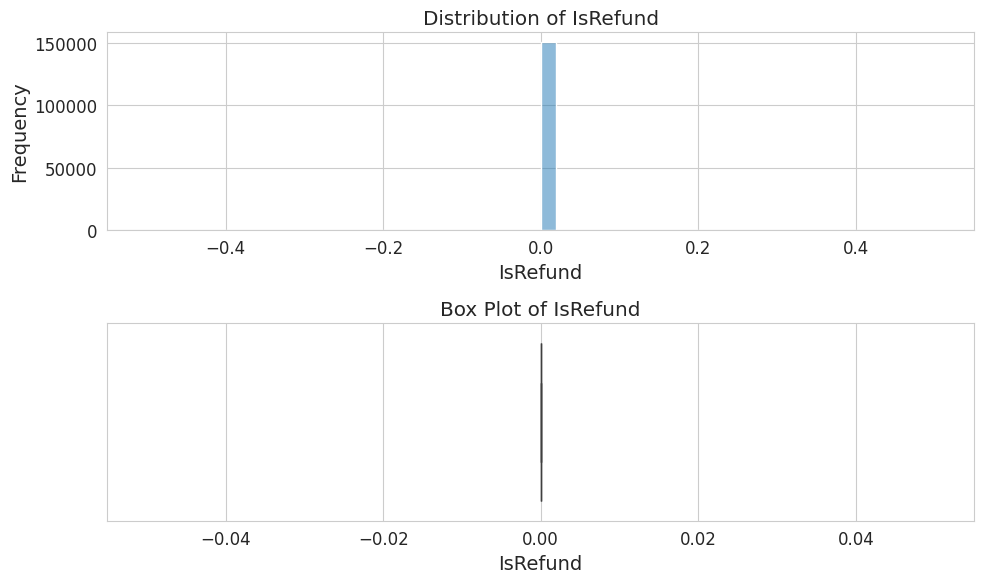


--- Analyzing Numerical Feature: TransactionHour ---


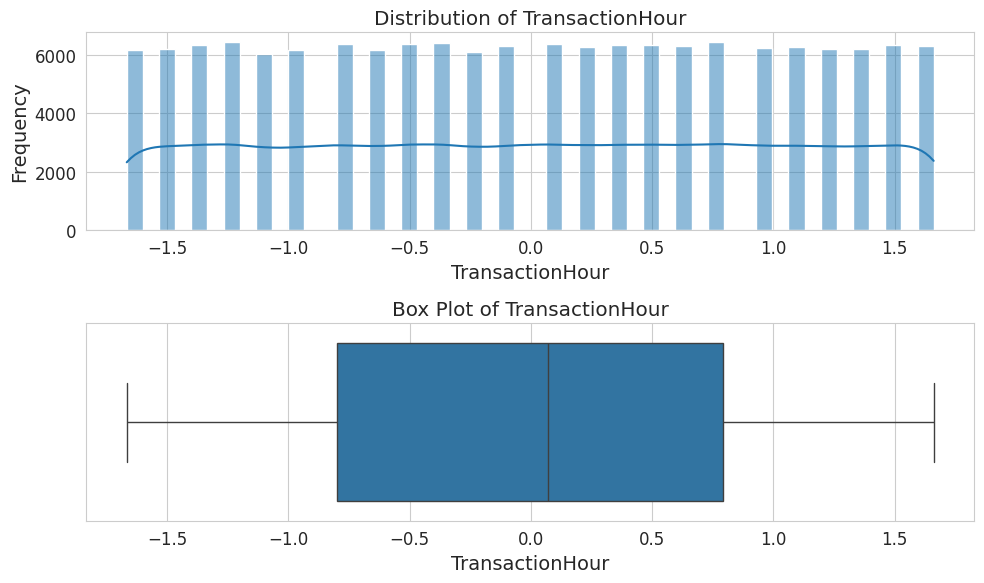


--- Analyzing Numerical Feature: TransactionDayOfWeek ---


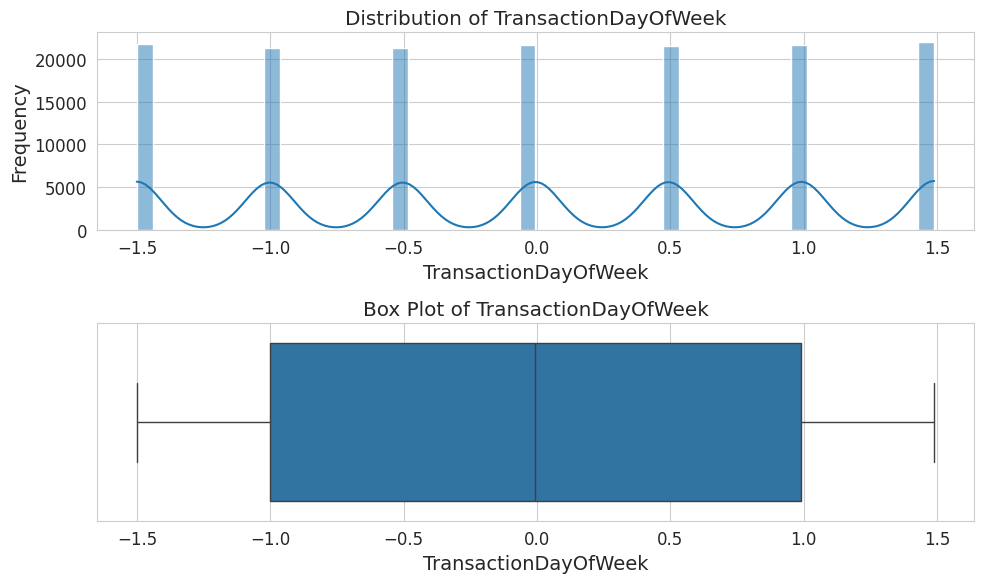


--- Analyzing Numerical Feature: TransactionMonth ---


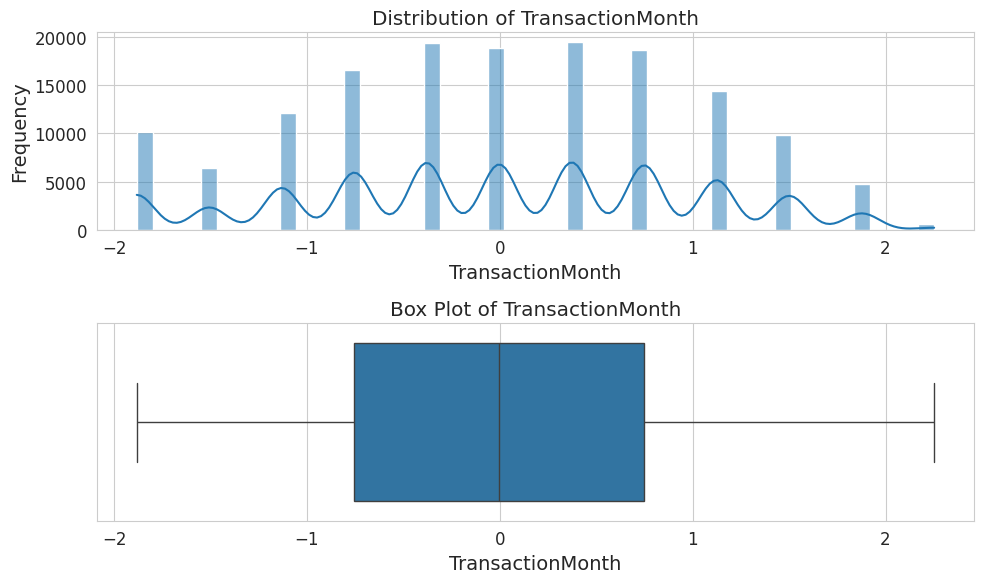


--- Analyzing Numerical Feature: TransactionYear ---


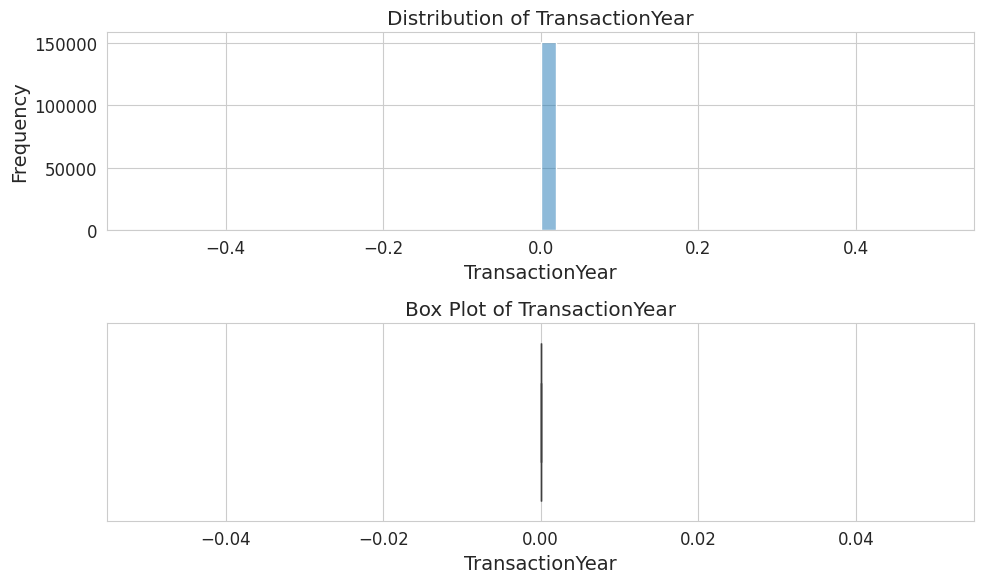


--- Analyzing Numerical Feature: time_since_signup ---


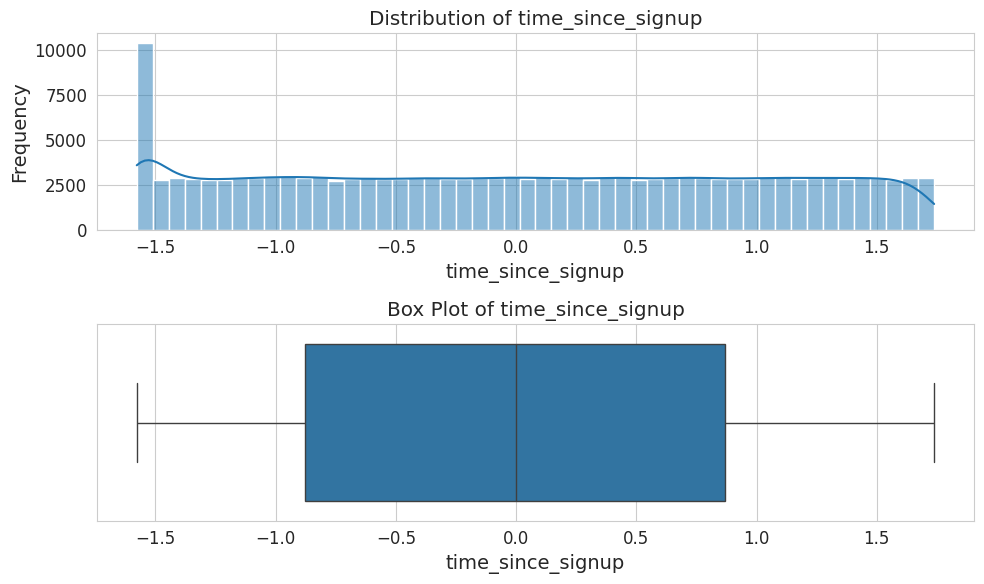


--- Analyzing Numerical Feature: CustomerId_transactions_last_1d ---


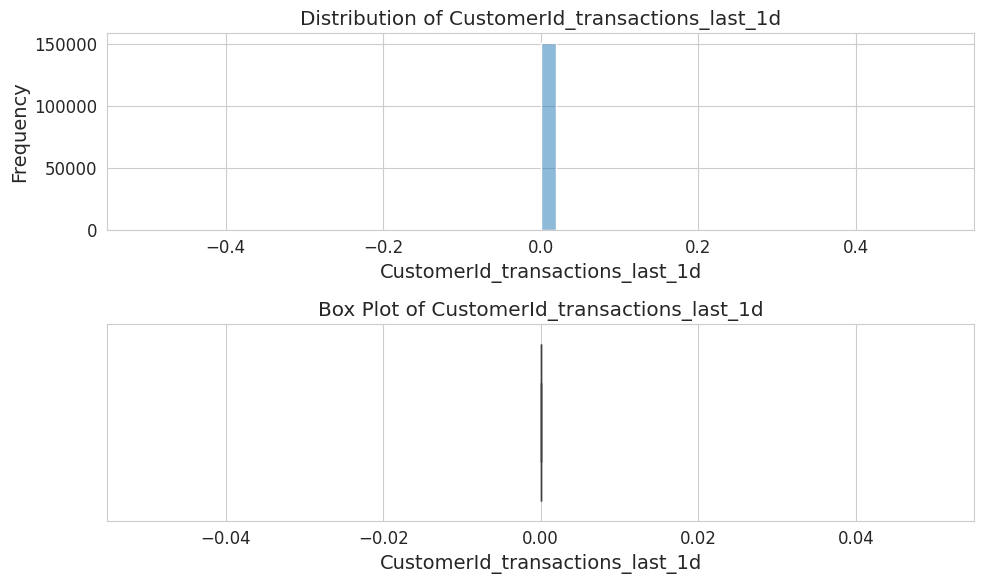


--- Analyzing Numerical Feature: CustomerId_transactions_last_7d ---


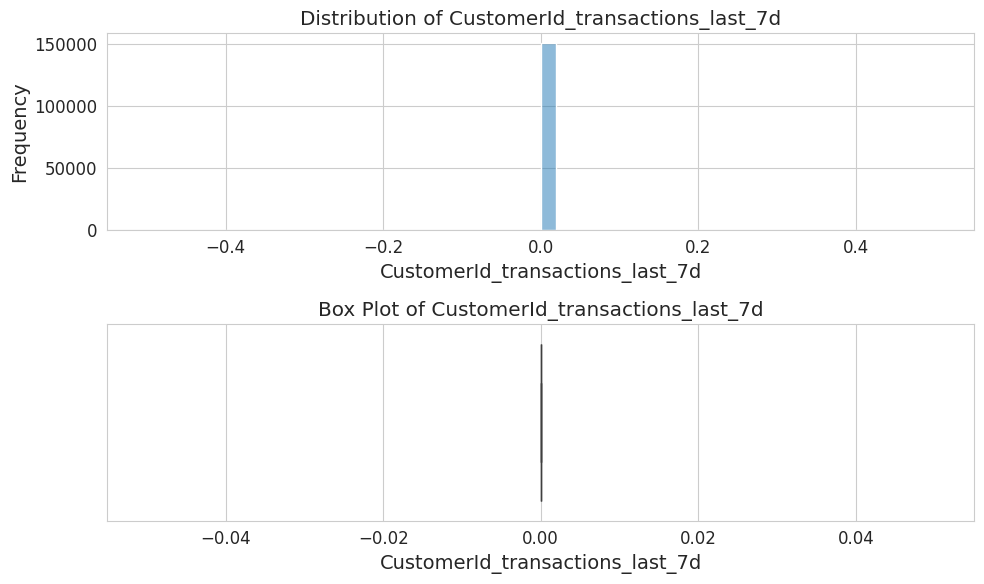


--- Analyzing Numerical Feature: CustomerId_transactions_last_30d ---


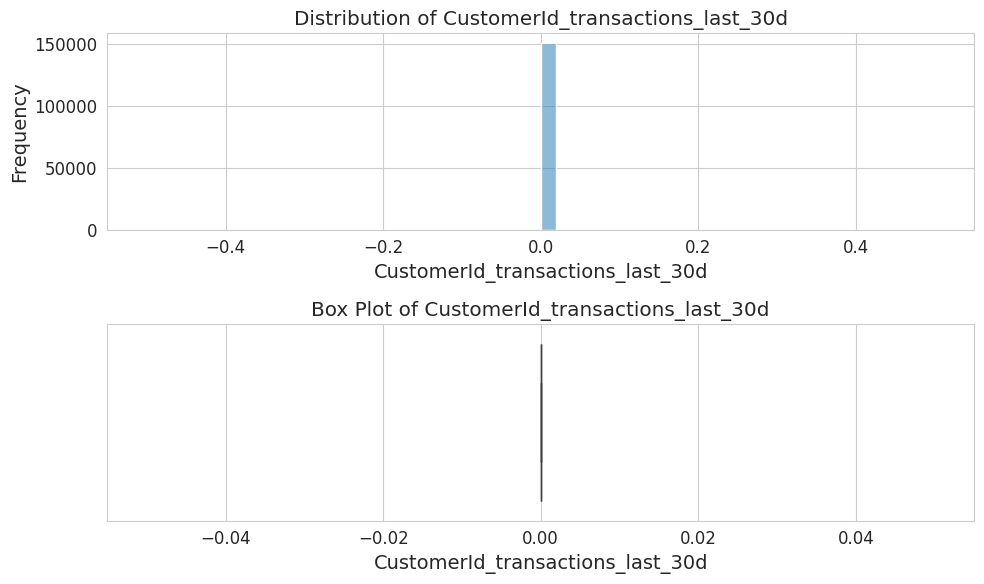


--- Analyzing Numerical Feature: device_id_transactions_last_1d ---


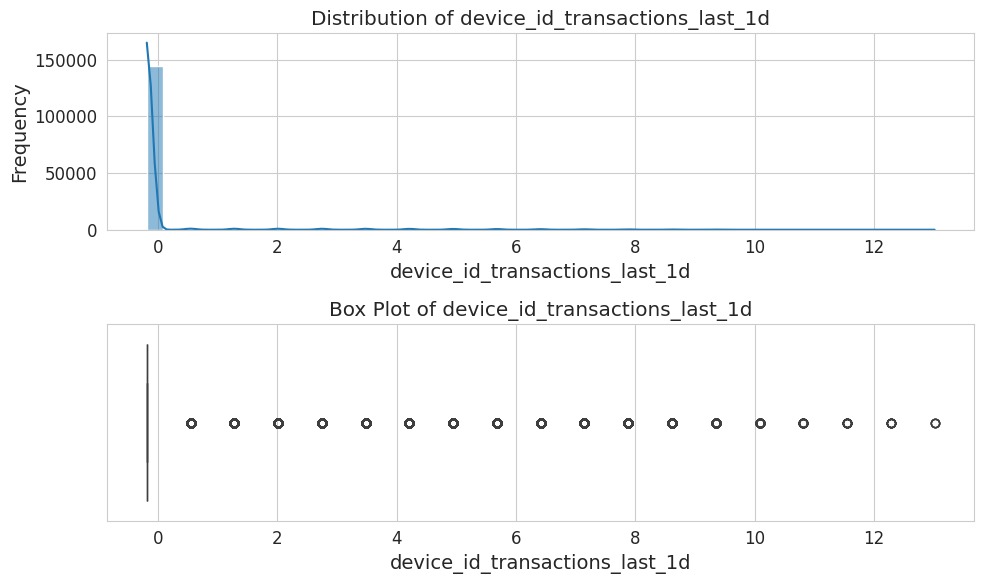


--- Analyzing Numerical Feature: device_id_transactions_last_7d ---


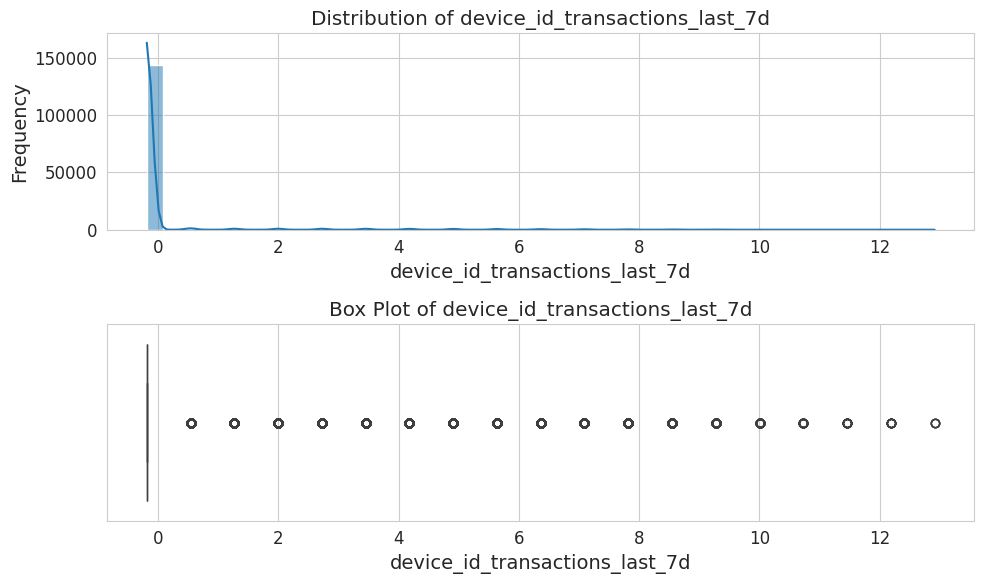


--- Analyzing Numerical Feature: device_id_transactions_last_30d ---


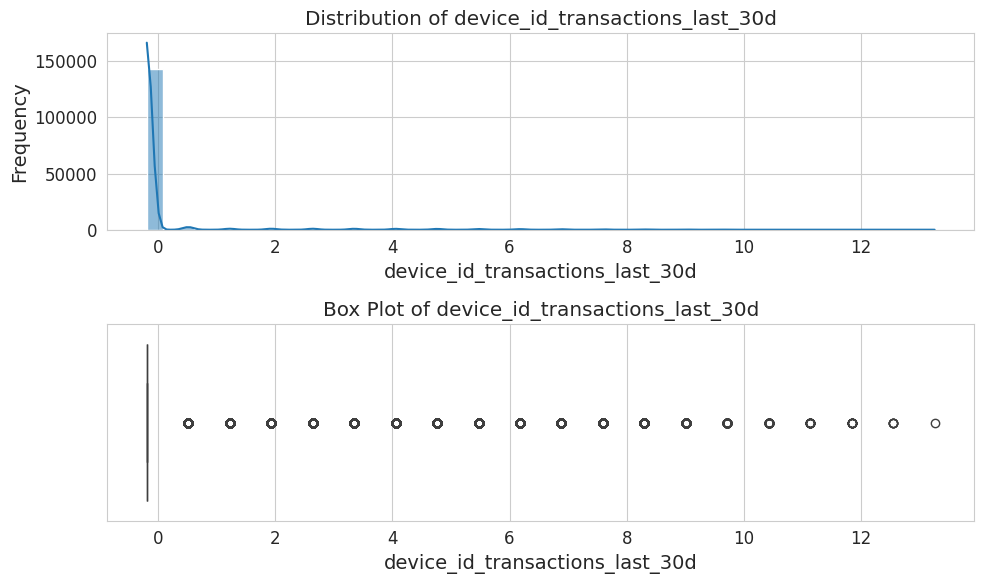


--- Analyzing Numerical Feature: ip_address_transactions_last_1d ---


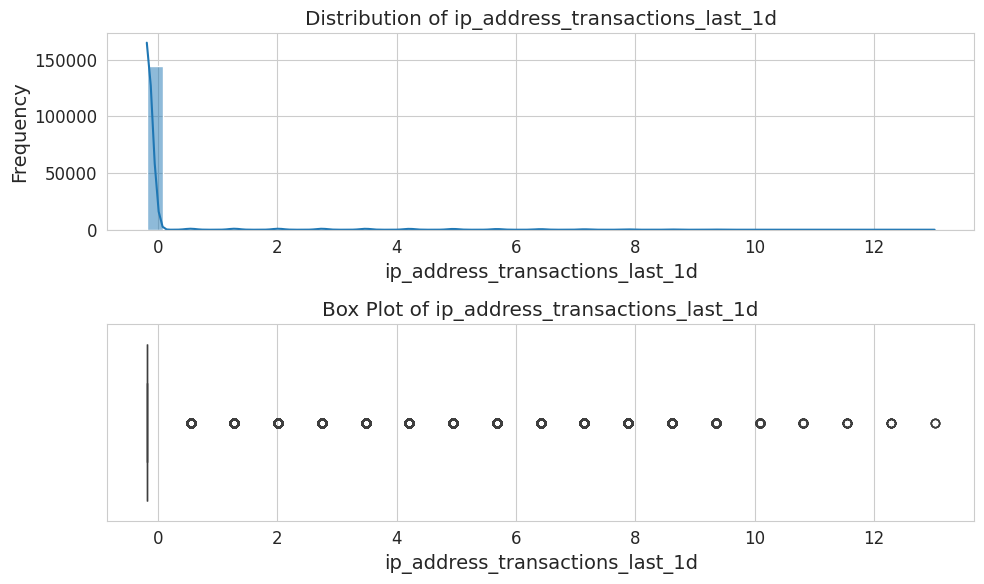


--- Analyzing Numerical Feature: ip_address_transactions_last_7d ---


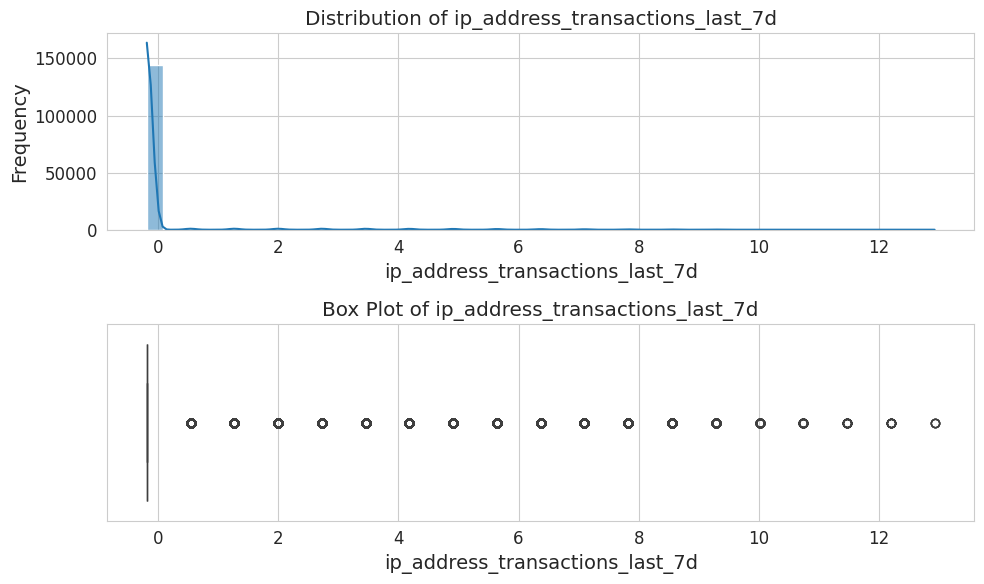


--- Analyzing Numerical Feature: ip_address_transactions_last_30d ---


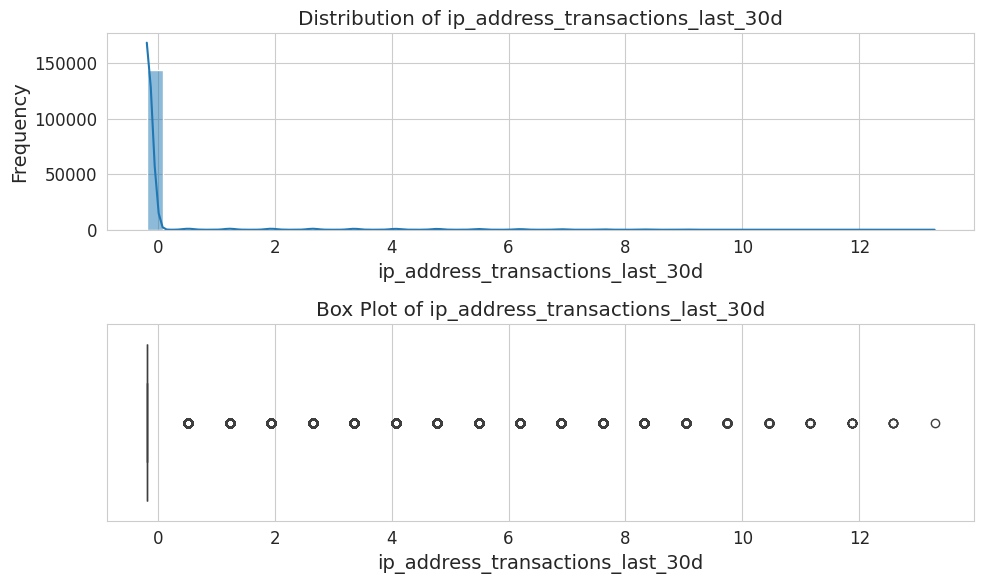


--- Analyzing Numerical Feature: CustomerId_total_amount_last_1d ---


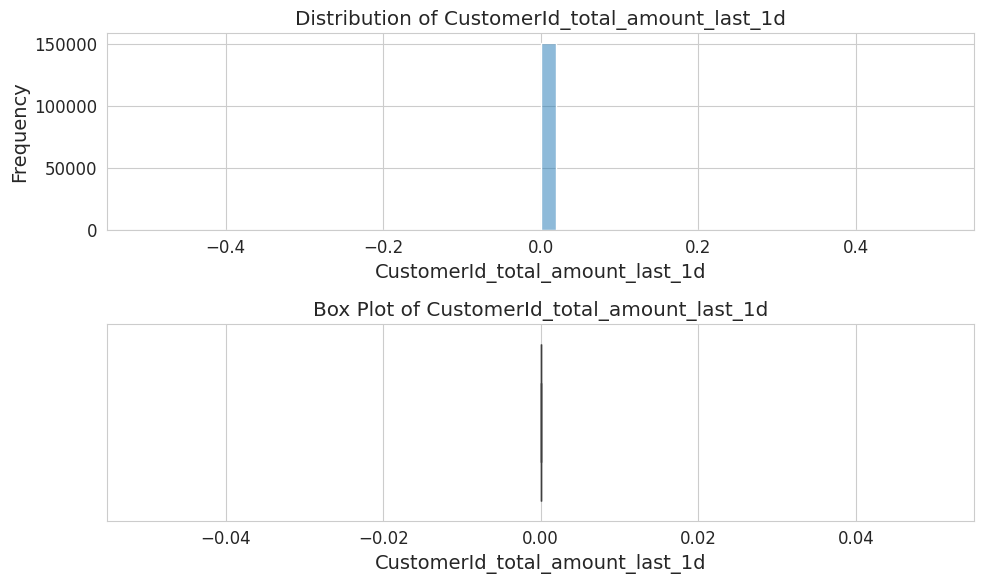


--- Analyzing Numerical Feature: CustomerId_total_amount_last_7d ---


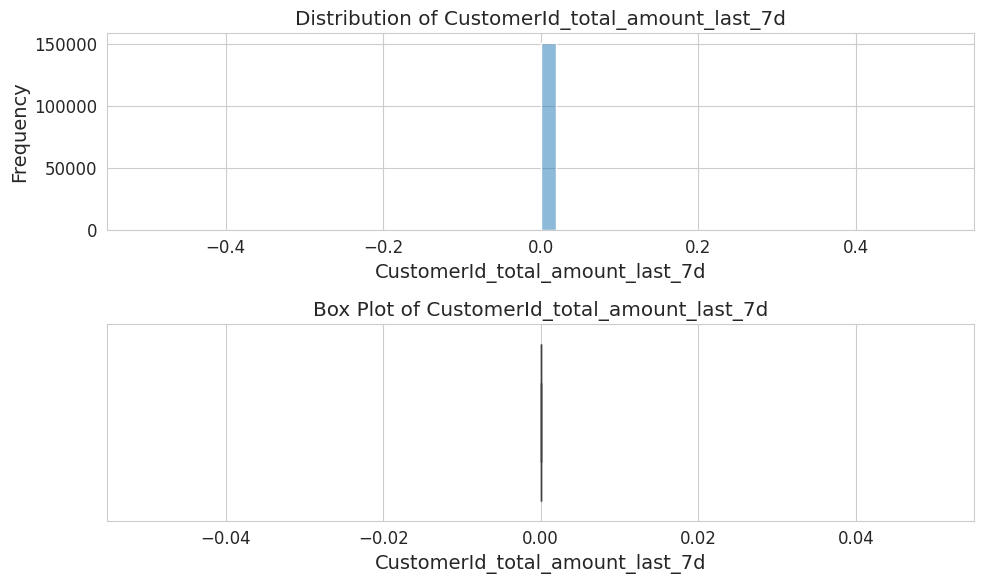


--- Analyzing Numerical Feature: CustomerId_total_amount_last_30d ---


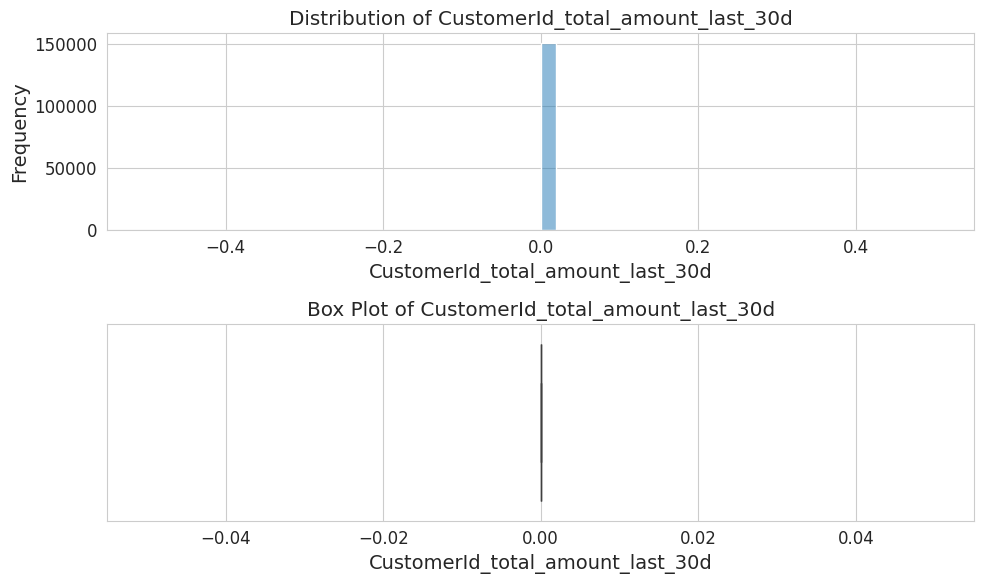


--- Analyzing Numerical Feature: device_id_total_amount_last_1d ---


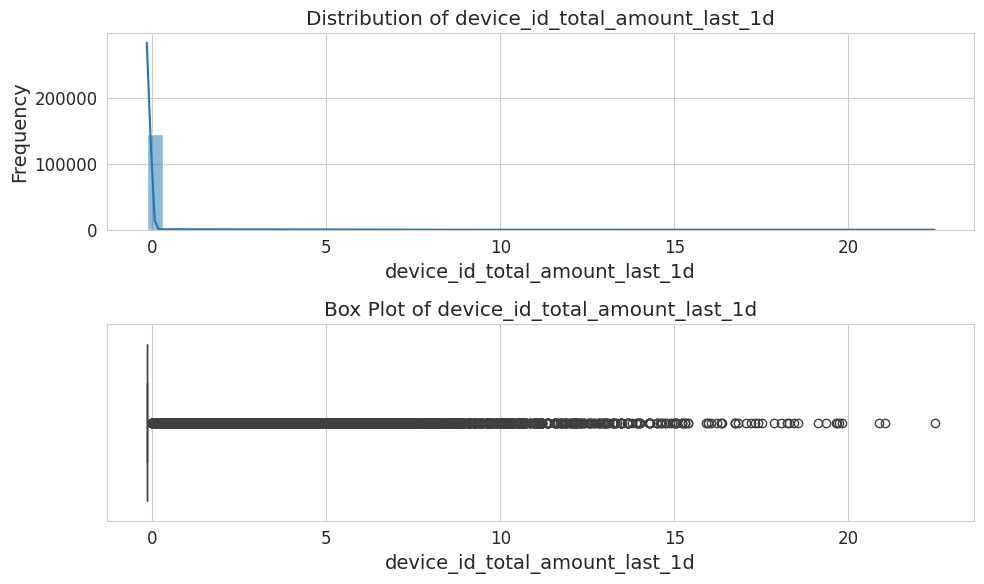


--- Analyzing Numerical Feature: device_id_total_amount_last_7d ---


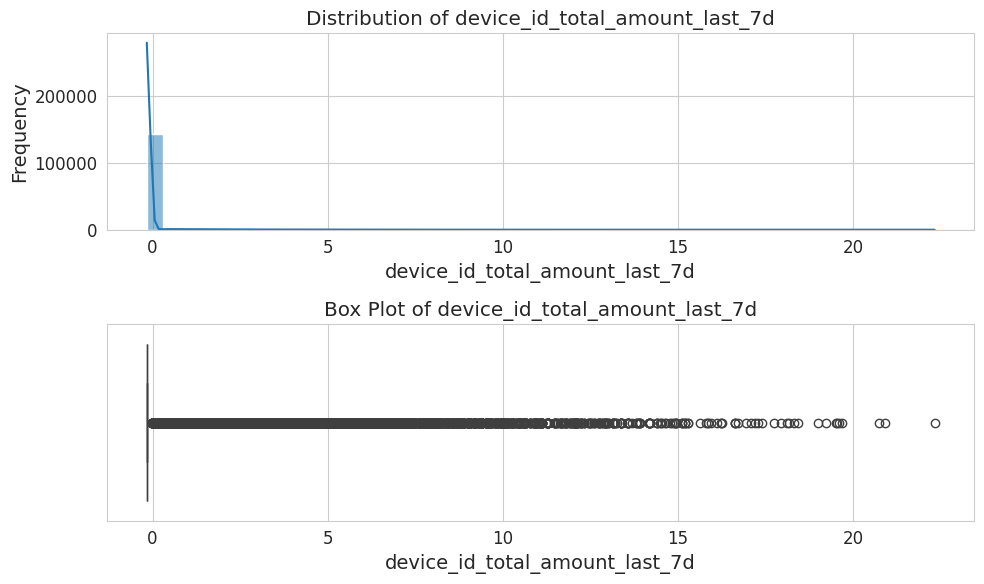


--- Analyzing Numerical Feature: device_id_total_amount_last_30d ---


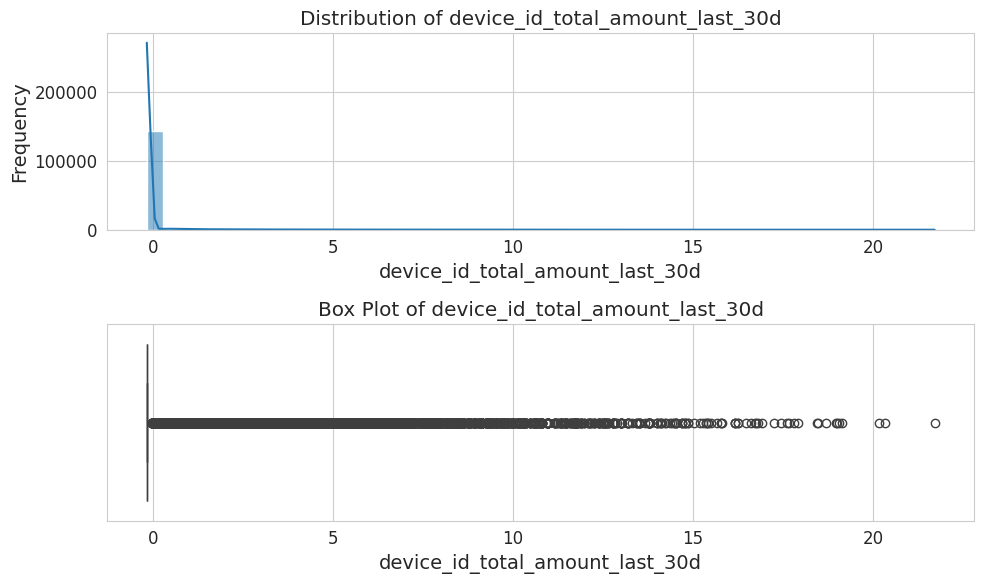


--- Analyzing Numerical Feature: ip_address_total_amount_last_1d ---


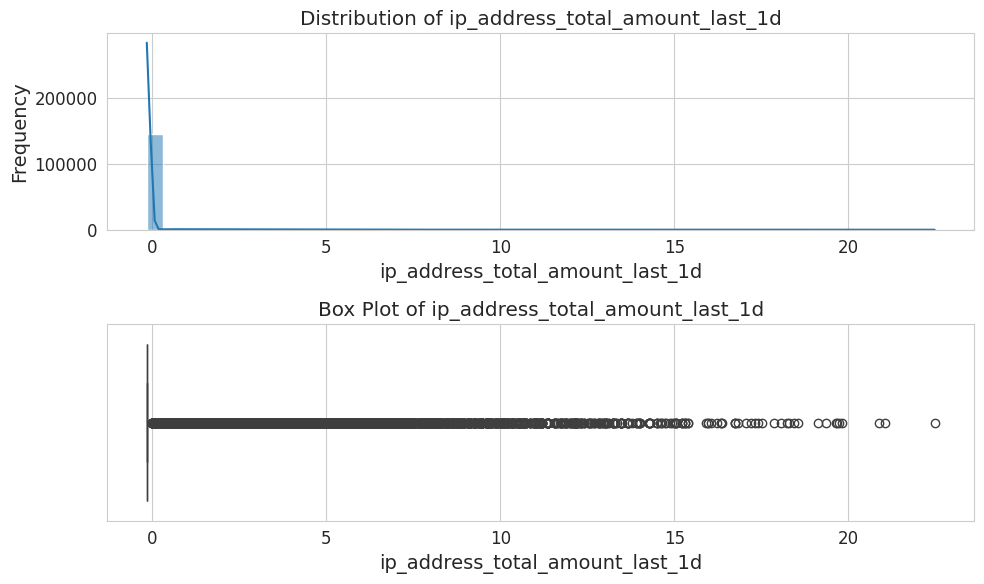


--- Analyzing Numerical Feature: ip_address_total_amount_last_7d ---


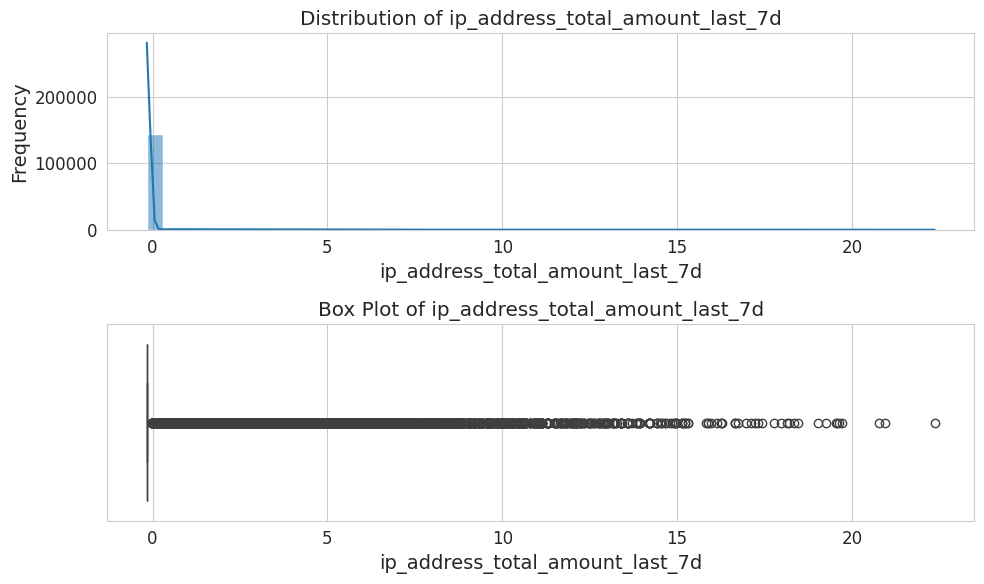


--- Analyzing Numerical Feature: ip_address_total_amount_last_30d ---


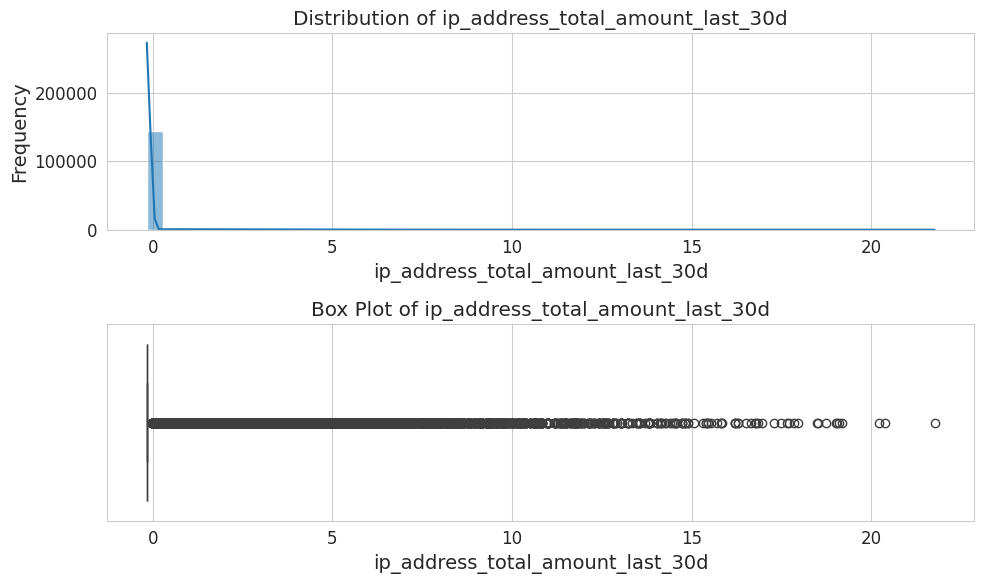


--- Analyzing Numerical Feature: CustomerId_avg_amount_last_1d ---


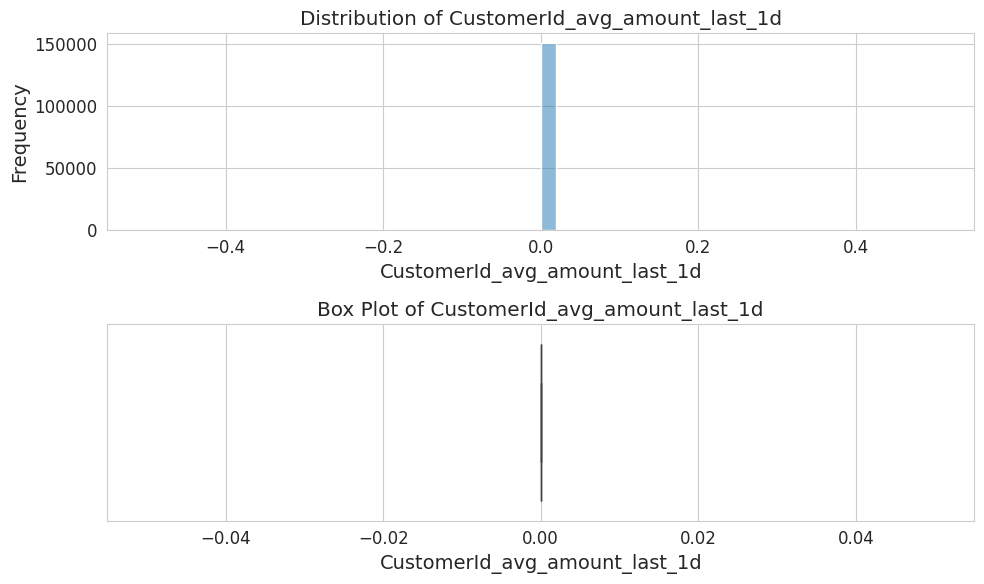


--- Analyzing Numerical Feature: CustomerId_avg_amount_last_7d ---


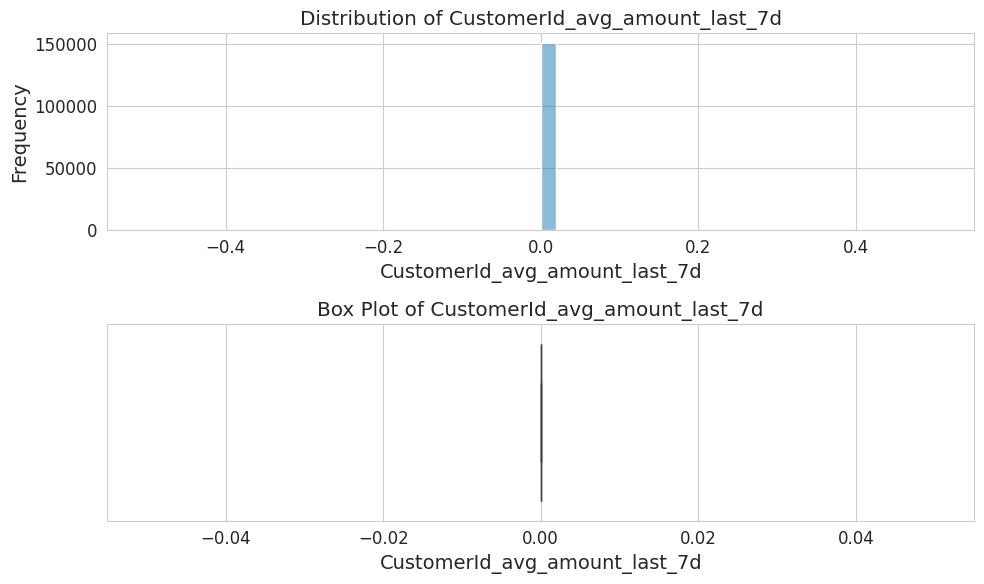


--- Analyzing Numerical Feature: CustomerId_avg_amount_last_30d ---


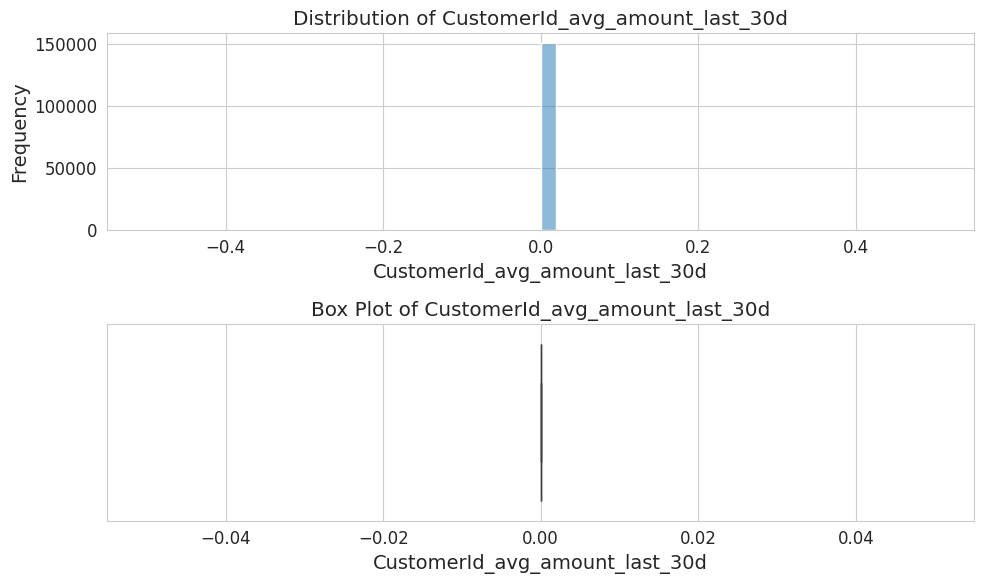


--- Analyzing Numerical Feature: device_id_avg_amount_last_1d ---


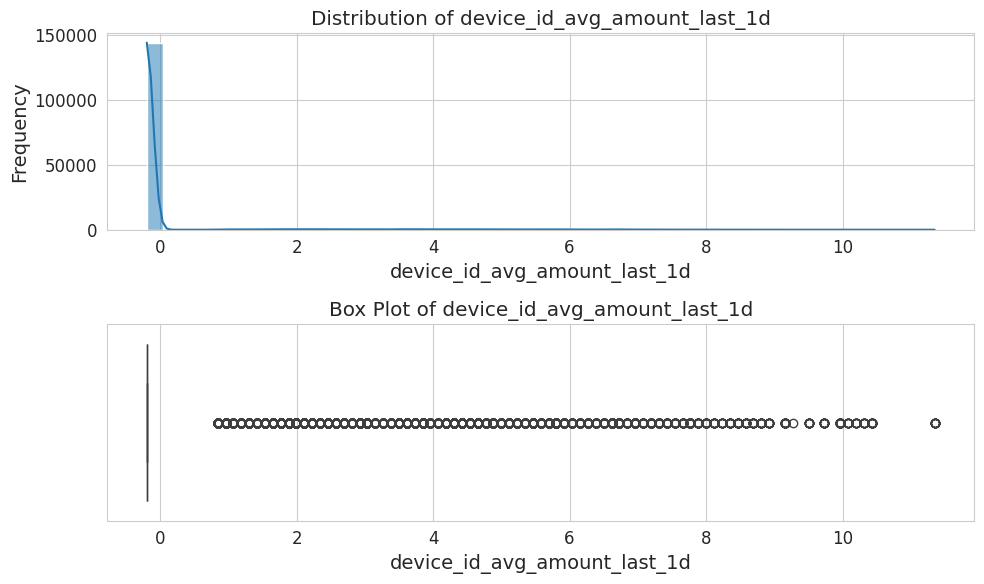


--- Analyzing Numerical Feature: device_id_avg_amount_last_7d ---


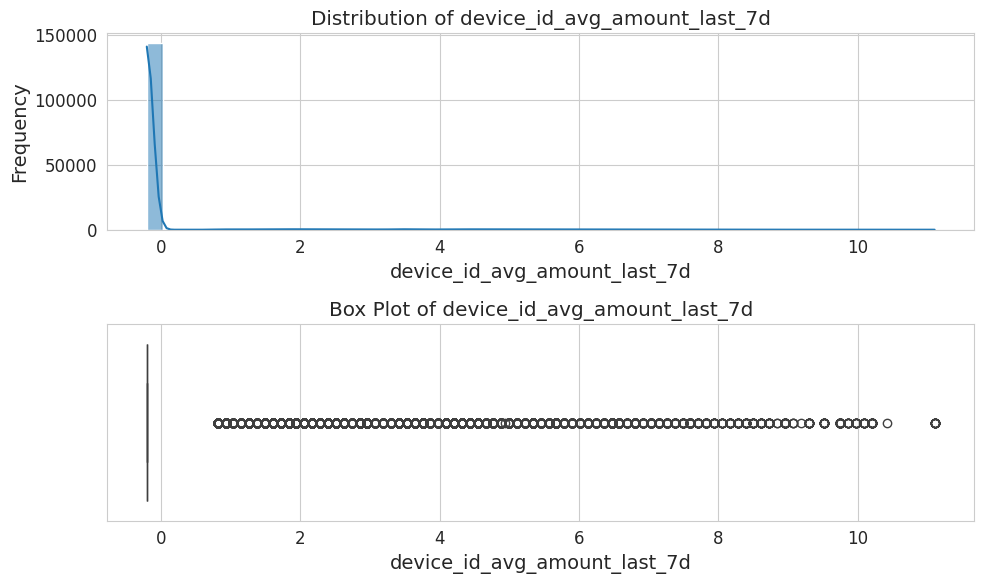


--- Analyzing Numerical Feature: device_id_avg_amount_last_30d ---


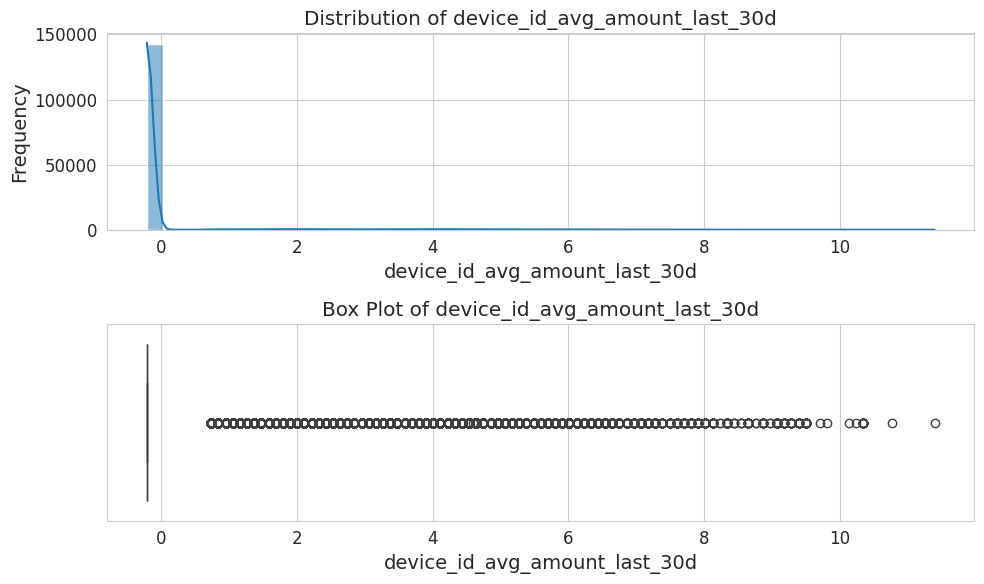


--- Analyzing Numerical Feature: ip_address_avg_amount_last_1d ---


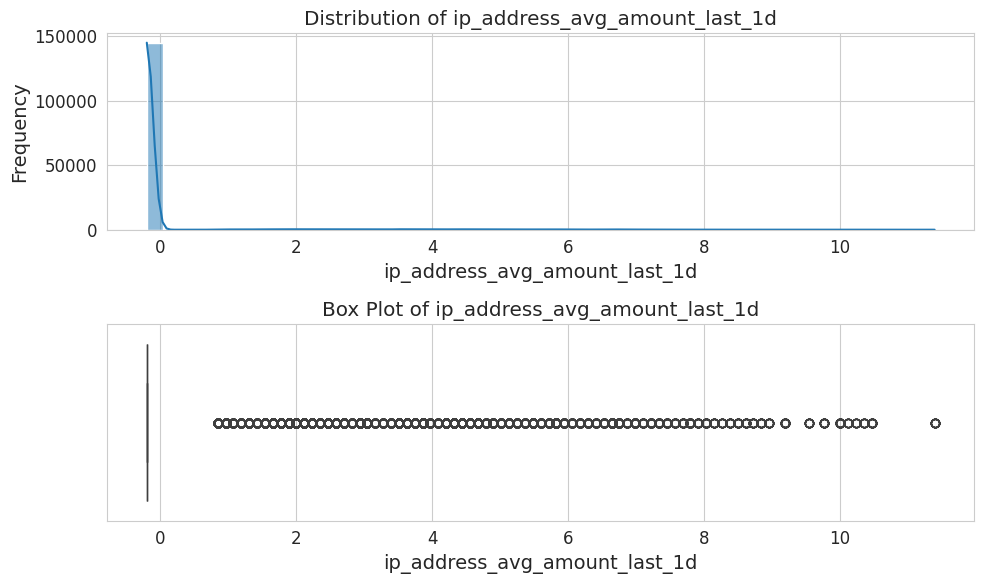


--- Analyzing Numerical Feature: ip_address_avg_amount_last_7d ---


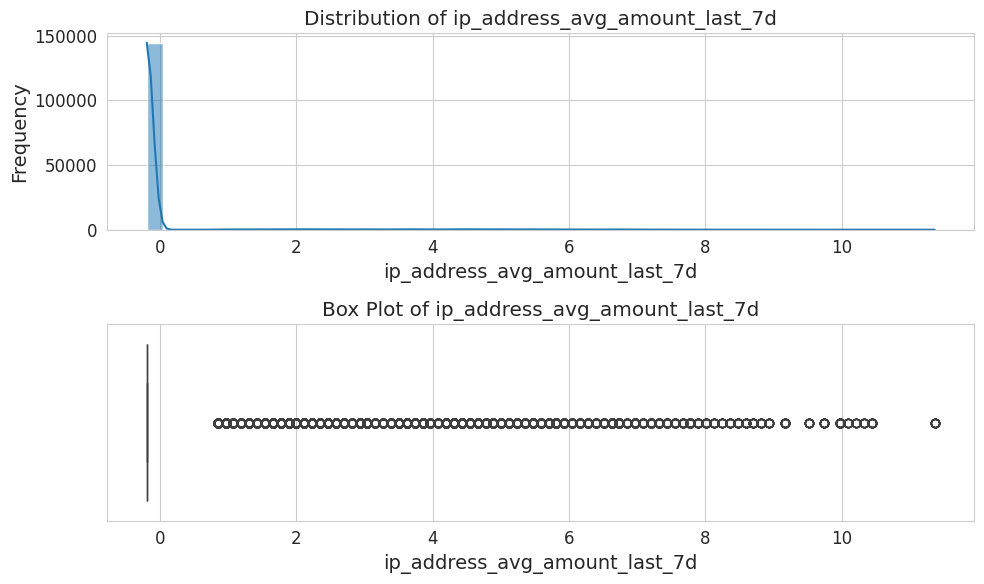


--- Analyzing Numerical Feature: ip_address_avg_amount_last_30d ---


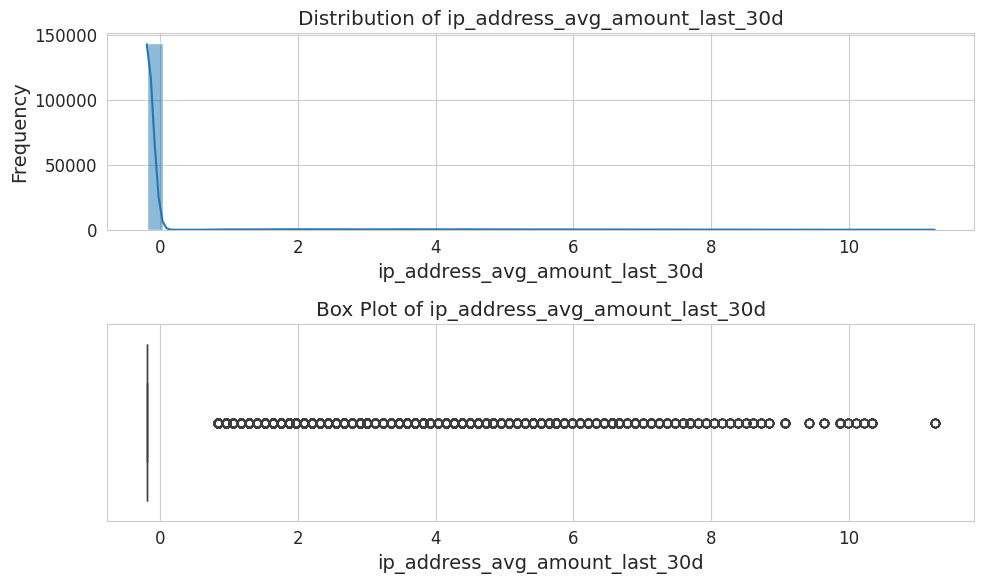


--- Class Distribution for 'class' in E-commerce Fraud Data ---
class
0    136961
1     14151
Name: count, dtype: int64
Fraudulent transactions: 14151 (9.36%) 
Non-fraudulent transactions: 136961 (90.64%) 


/tmp/ipykernel_17825/706830785.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=FRAUD_TARGET_COL, data=fraud_processed_df, palette='coolwarm')


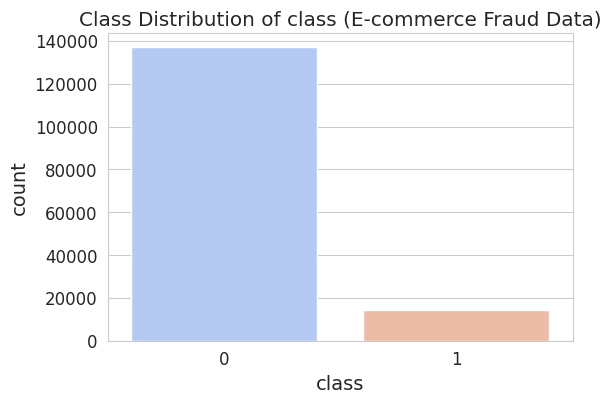

In [11]:
if not fraud_processed_df.empty:
    print("\n--- Univariate Analysis for E-commerce Fraud Data ---")

    # Define features for EDA based on the *expected output* of the FraudDataProcessor
    # These lists must accurately reflect the columns present and their types AFTER preprocessing
    fraud_numerical_features_for_eda = [
        'Amount', 'age', 'IsRefund', 'TransactionHour', 'TransactionDayOfWeek',
        'TransactionMonth', 'TransactionYear', 'time_since_signup'
    ] + [
        f'{id_col}_transactions_last_{window}d' for id_col in ['CustomerId', 'device_id', 'ip_address'] for window in [1, 7, 30]
    ] + [
        f'{id_col}_total_amount_last_{window}d' for id_col in ['CustomerId', 'device_id', 'ip_address'] for window in [1, 7, 30]
    ] + [
        f'{id_col}_avg_amount_last_{window}d' for id_col in ['CustomerId', 'device_id', 'ip_address'] for window in [1, 7, 30]
    ]
    # Filter to only include columns that actually exist in the DataFrame
    fraud_numerical_features_for_eda = [col for col in fraud_numerical_features_for_eda if col in fraud_processed_df.columns]

    # Categorical features will be One-Hot Encoded, so we analyze the original categorical columns
    # or the OHE versions if needed, but for general distribution, original is better.
    # The 'country' column is added during merge.
    fraud_categorical_features_for_eda = [
        'source', 'browser', 'sex', 'country'
    ]
    # Filter to only include columns that actually exist in the DataFrame
    fraud_categorical_features_for_eda = [col for col in fraud_categorical_features_for_eda if col in fraud_processed_df.columns]

    # Numerical Univariate Analysis
    univariate_analyzer_num = UnivariateAnalyzer(NumericalUnivariateAnalysis())
    for col in fraud_numerical_features_for_eda:
        univariate_analyzer_num.execute_analysis(fraud_processed_df, col)

    # Categorical Univariate Analysis
    univariate_analyzer_cat = UnivariateAnalyzer(CategoricalUnivariateAnalysis())
    for col in fraud_categorical_features_for_eda:
        univariate_analyzer_cat.execute_analysis(fraud_processed_df, col)

    # Class Imbalance Check for FraudResult
    if FRAUD_TARGET_COL in fraud_processed_df.columns:
        print(f"\n--- Class Distribution for '{FRAUD_TARGET_COL}' in E-commerce Fraud Data ---")
        class_counts = fraud_processed_df[FRAUD_TARGET_COL].value_counts()
        print(class_counts)
        print(f"Fraudulent transactions: {class_counts.get(1, 0)} ({class_counts.get(1, 0) / len(fraud_processed_df) * 100:.2f}%) ")
        print(f"Non-fraudulent transactions: {class_counts.get(0, 0)} ({class_counts.get(0, 0) / len(fraud_processed_df) * 100:.2f}%) ")
        plt.figure(figsize=(6, 4))
        sns.countplot(x=FRAUD_TARGET_COL, data=fraud_processed_df, palette='coolwarm')
        plt.title(f'Class Distribution of {FRAUD_TARGET_COL} (E-commerce Fraud Data)')
        plt.show()
    else:
        print(f"Target column '{FRAUD_TARGET_COL}' not found in E-commerce Fraud Data. Skipping class distribution check.")
else:
    print("E-commerce Fraud Data is empty, skipping Univariate Analysis.")


### **3.4 Bivariate Analysis**
Bivariate analysis explores the relationships between pairs of features. This helps in identifying potential correlations, dependencies, and interactions that might be important for model building.


--- Bivariate Analysis for E-commerce Fraud Data ---

--- Analyzing Numerical vs Numerical: Amount vs age ---


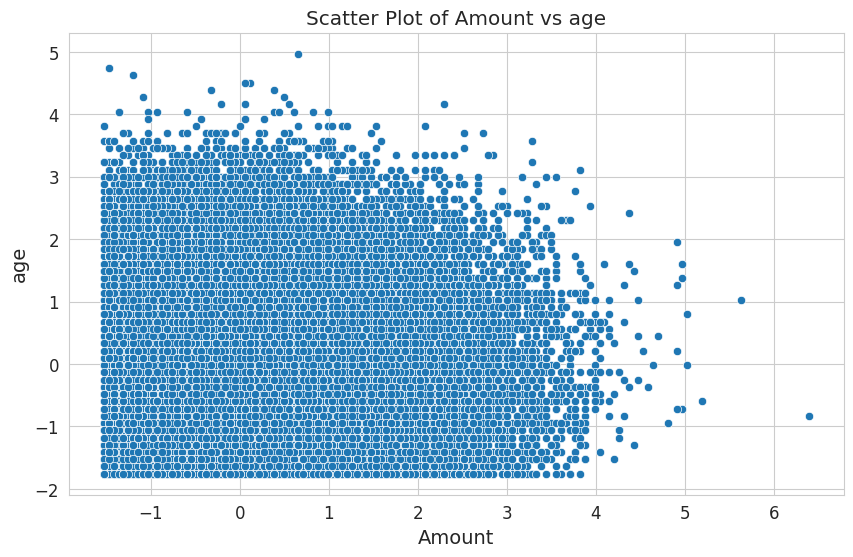

Pearson Correlation between Amount and age: 0.0024

--- Analyzing Numerical vs Numerical: Amount vs time_since_signup ---


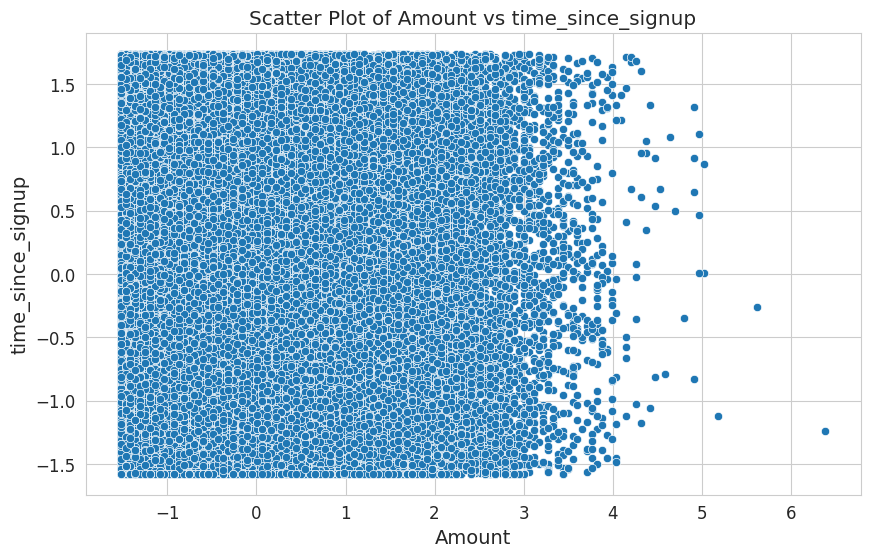

Pearson Correlation between Amount and time_since_signup: 0.0034
Error: One feature must be categorical and the other numerical for this analysis. Got 'int64' and 'float64'.
Error: One feature must be categorical and the other numerical for this analysis. Got 'int64' and 'float64'.


In [12]:
if not fraud_processed_df.empty:
    print("\n--- Bivariate Analysis for E-commerce Fraud Data ---")

    # Numerical vs Numerical
    bivariate_analyzer_num_num = BivariateAnalyzer(NumericalVsNumericalAnalysis())
    # Example: Amount vs age
    if 'Amount' in fraud_processed_df.columns and 'age' in fraud_processed_df.columns:
        bivariate_analyzer_num_num.execute_analysis(fraud_processed_df, 'Amount', 'age')
    # Example: Amount vs time_since_signup
    if 'Amount' in fraud_processed_df.columns and 'time_since_signup' in fraud_processed_df.columns:
        bivariate_analyzer_num_num.execute_analysis(fraud_processed_df, 'Amount', 'time_since_signup')

    # Categorical vs Numerical
    bivariate_analyzer_cat_num = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
    # Example: source vs Amount
    if 'source' in fraud_processed_df.columns and 'Amount' in fraud_processed_df.columns:
        bivariate_analyzer_cat_num.execute_analysis(fraud_processed_df, 'source', 'Amount')
    # Example: country vs Amount
    if 'country' in fraud_processed_df.columns and 'Amount' in fraud_processed_df.columns:
        bivariate_analyzer_cat_num.execute_analysis(fraud_processed_df, 'country', 'Amount')
    # Example: Target vs Amount
    if FRAUD_TARGET_COL in fraud_processed_df.columns and 'Amount' in fraud_processed_df.columns:
        bivariate_analyzer_cat_num.execute_analysis(fraud_processed_df, FRAUD_TARGET_COL, 'Amount')
    # Example: Target vs time_since_signup
    if FRAUD_TARGET_COL in fraud_processed_df.columns and 'time_since_signup' in fraud_processed_df.columns:
        bivariate_analyzer_cat_num.execute_analysis(fraud_processed_df, FRAUD_TARGET_COL, 'time_since_signup')

    # Categorical vs Categorical
    bivariate_analyzer_cat_cat = BivariateAnalyzer(CategoricalVsCategoricalAnalysis())
    # Example: source vs sex
    if 'source' in fraud_processed_df.columns and 'sex' in fraud_processed_df.columns:
        bivariate_analyzer_cat_cat.execute_analysis(fraud_processed_df, 'source', 'sex')
    # Example: country vs FraudResult
    if 'country' in fraud_processed_df.columns and FRAUD_TARGET_COL in fraud_processed_df.columns:
        bivariate_analyzer_cat_cat.execute_analysis(fraud_processed_df, 'country', FRAUD_TARGET_COL)
else:
    print("E-commerce Fraud Data is empty, skipping Bivariate Analysis.")


### **3.5 Multivariate Analysis**
Multivariate analysis examines the relationships among three or more variables. This helps in understanding complex interactions and patterns that might not be visible in univariate or bivariate analyses.


--- Multivariate Analysis for E-commerce Fraud Data ---

--- Performing Multivariate Analysis ---

Generating Correlation Heatmap...


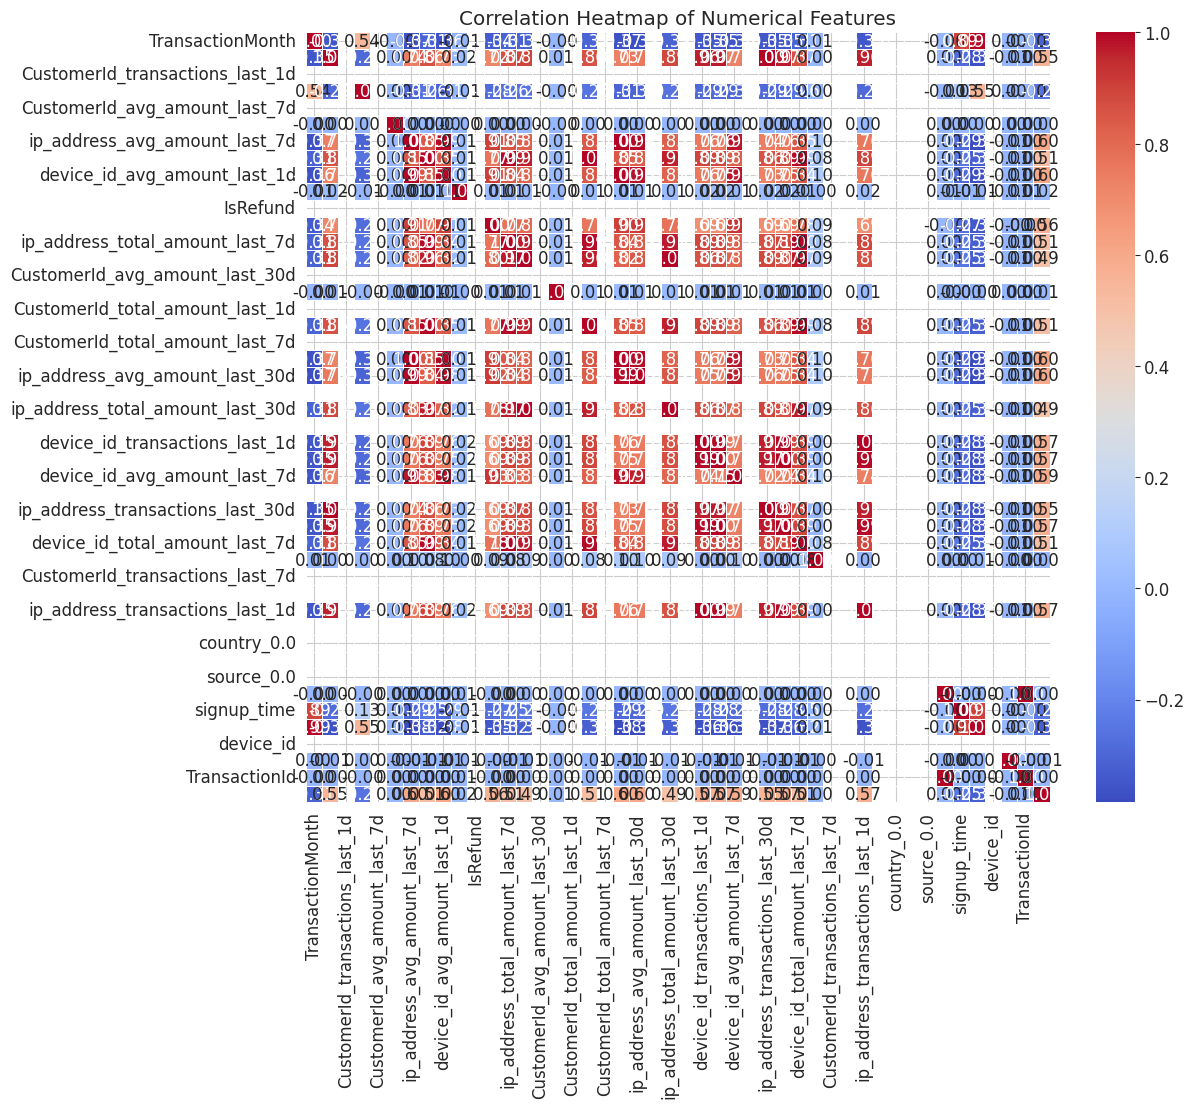


Generating Pair Plot...


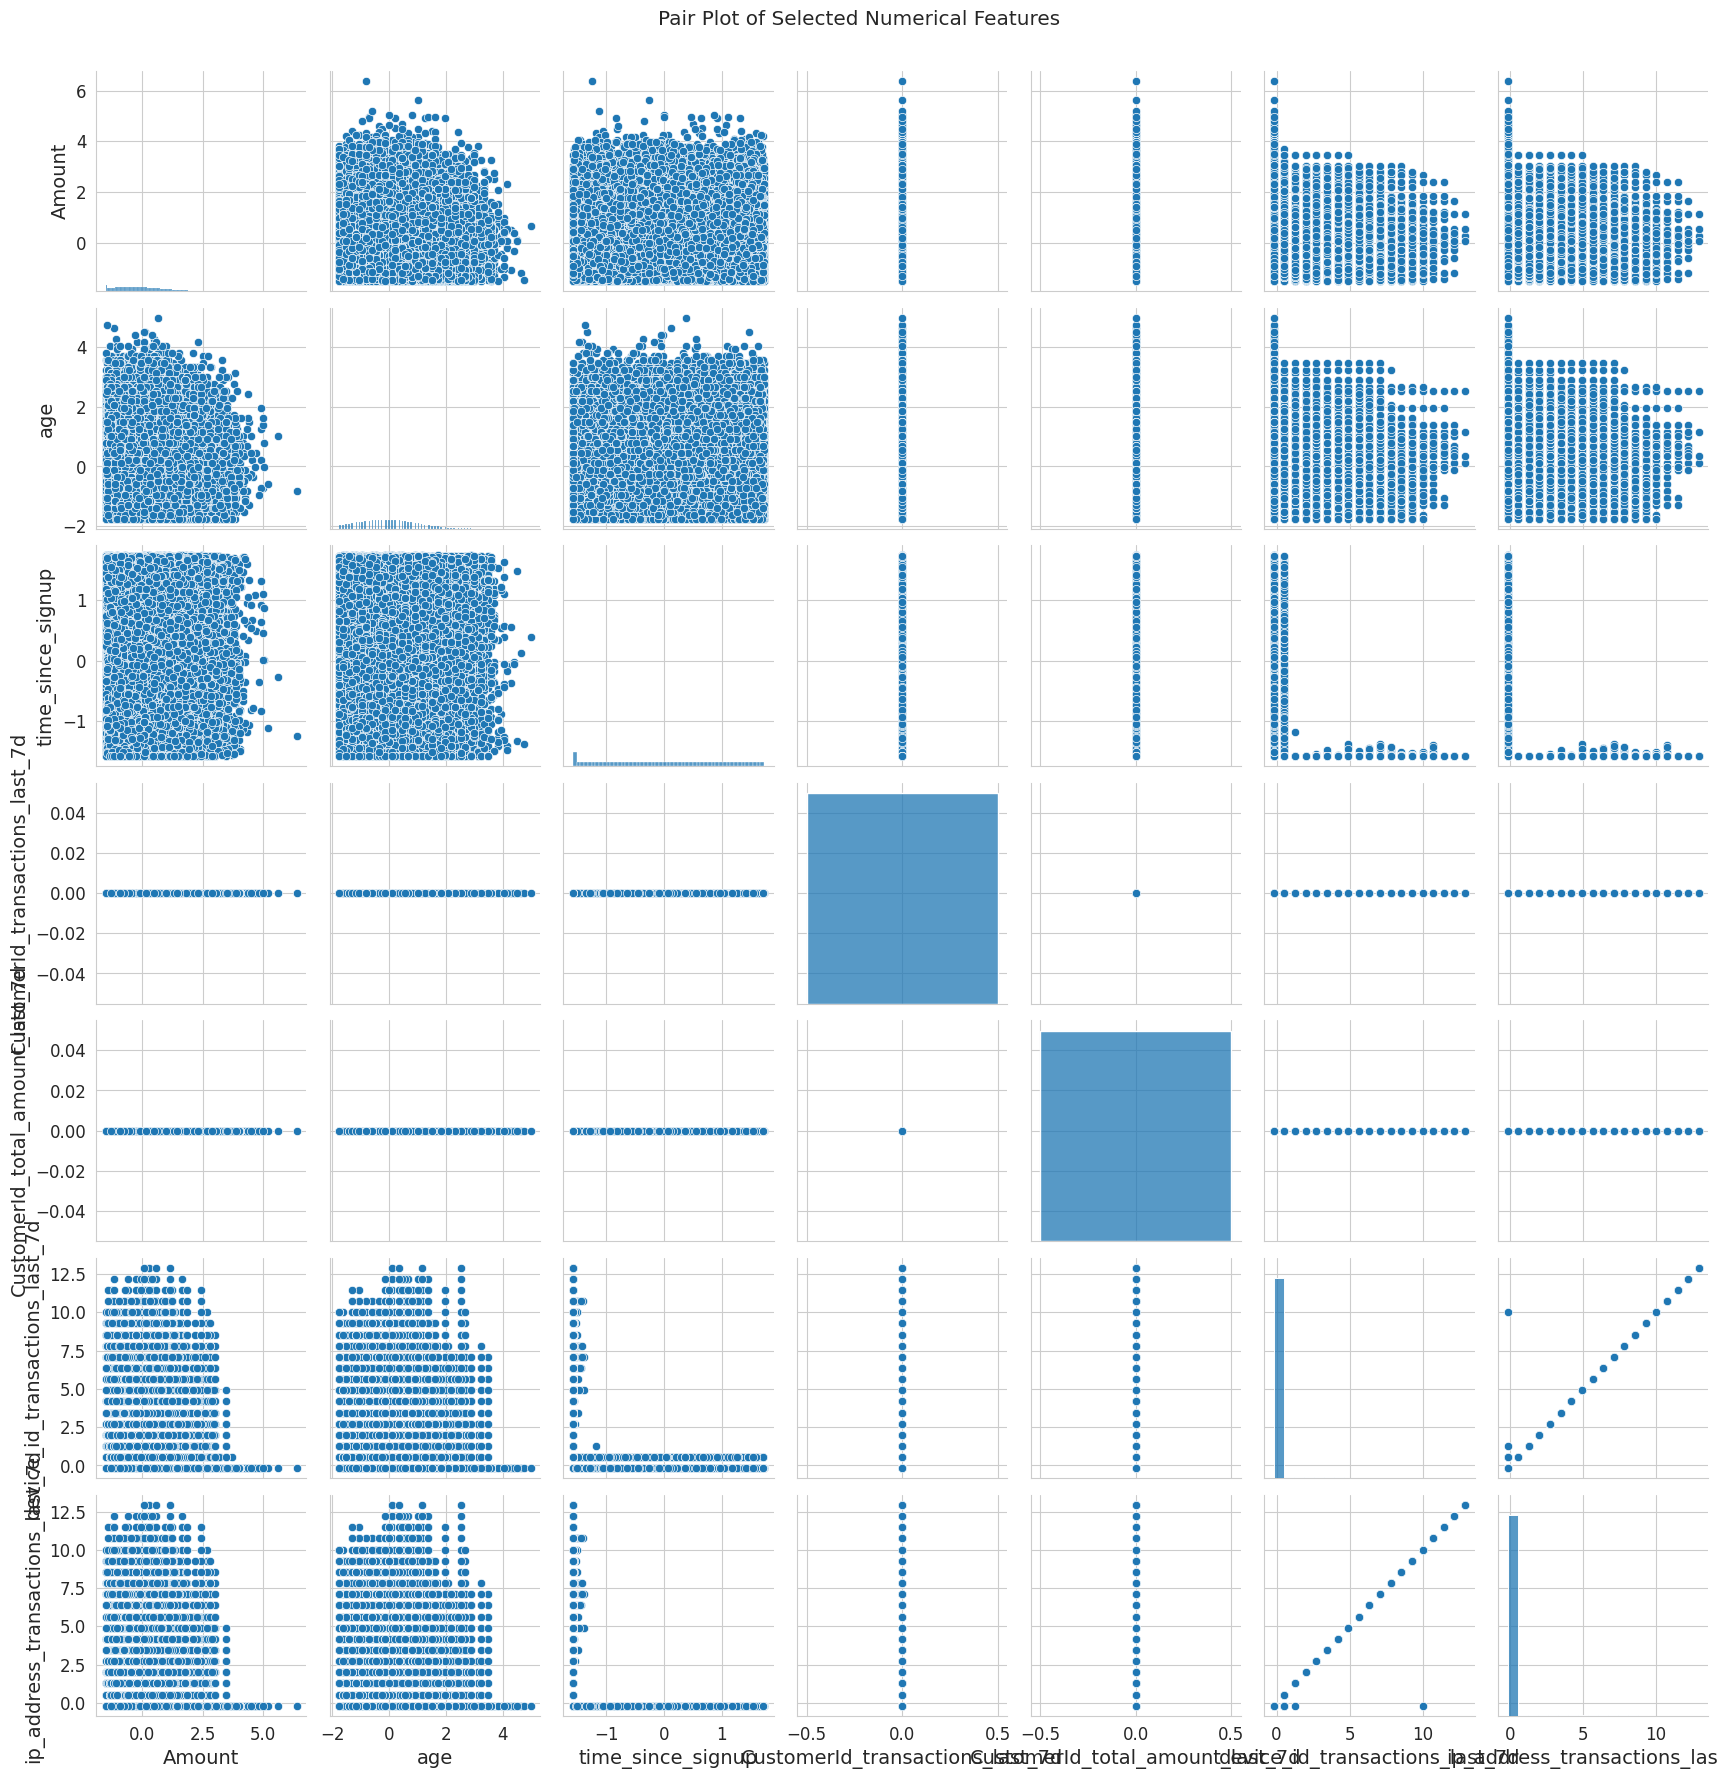

In [13]:
if not fraud_processed_df.empty:
    print("\n--- Multivariate Analysis for E-commerce Fraud Data ---")
    multivariate_analyzer = SimpleMultivariateAnalysis()

    # Select a subset of numerical features for correlation heatmap and pair plot
    # Include some original numericals and some engineered features
    fraud_multivariate_features = [
        'Amount', 'age', 'time_since_signup',
        'CustomerId_transactions_last_7d', 'CustomerId_total_amount_last_7d',
        'device_id_transactions_last_7d', 'ip_address_transactions_last_7d'
    ]
    fraud_multivariate_features = [col for col in fraud_multivariate_features if col in fraud_processed_df.columns]

    if fraud_multivariate_features:
        multivariate_analyzer.analyze(fraud_processed_df, features=fraud_multivariate_features)
    else:
        print("No suitable numerical features found for multivariate analysis in E-commerce Fraud Data.")
else:
    print("E-commerce Fraud Data is empty, skipping Multivariate Analysis.")


### **3.6 Outlier Analysis**
Outliers are data points that significantly differ from other observations. Identifying and understanding outliers is crucial as they can skew statistical analyses and model training. This section uses IQR-based outlier detection and visualization.


--- Outlier Analysis for E-commerce Fraud Data ---

--- Outlier Analysis for Feature: Amount ---
IQR for Amount: 1.47
Lower Bound: -3.03, Upper Bound: 2.87
Number of outliers detected: 1067
Outlier percentage: 0.71%
Sample outliers:
47     2.950691
351    3.823925
470    2.896114
661    3.005268
974    3.496462
Name: Amount, dtype: float64


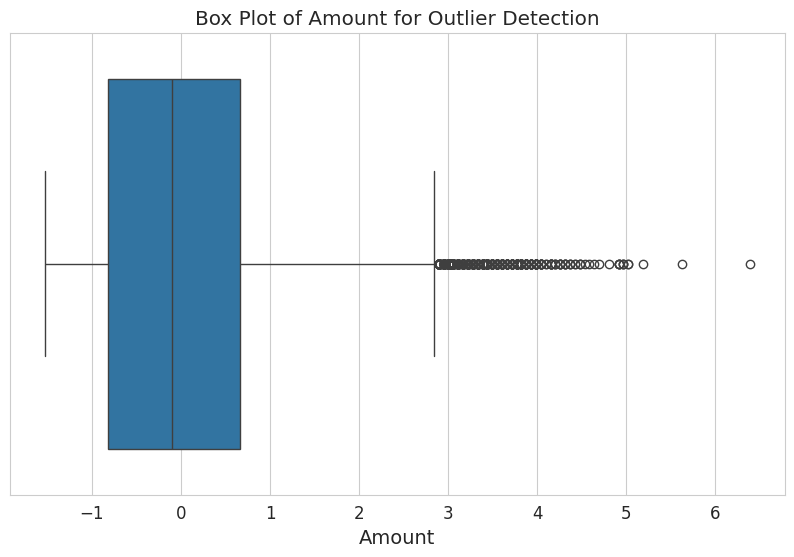


--- Outlier Analysis for Feature: age ---
IQR for age: 1.39
Lower Bound: -2.80, Upper Bound: 2.77
Number of outliers detected: 776
Outlier percentage: 0.51%
Sample outliers:
103    3.116757
241    2.884677
444    3.116757
521    3.000717
871    3.116757
Name: age, dtype: float64


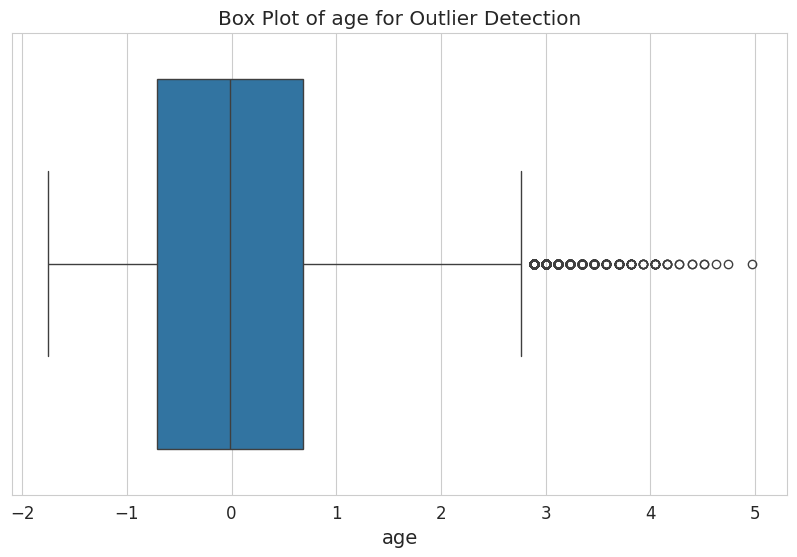


--- Outlier Analysis for Feature: time_since_signup ---
IQR for time_since_signup: 1.75
Lower Bound: -3.50, Upper Bound: 3.49
Number of outliers detected: 0


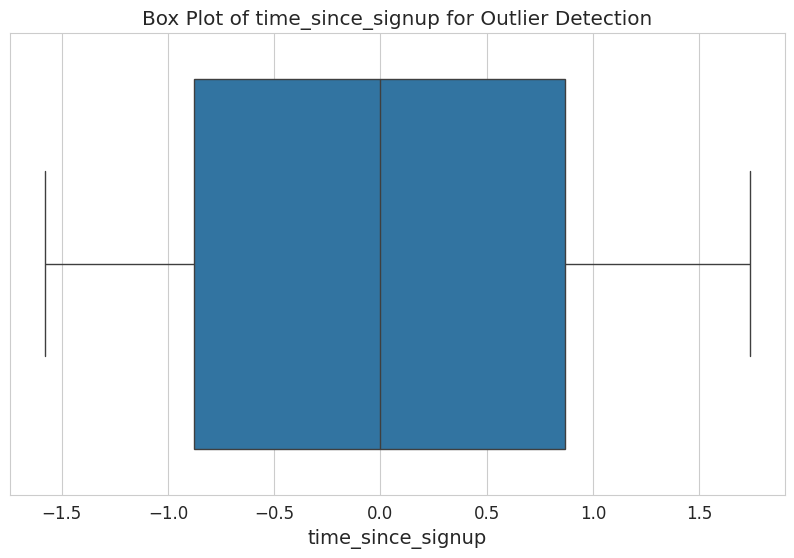


--- Outlier Analysis for Feature: IsRefund ---
IQR for IsRefund: 0.00
Lower Bound: 0.00, Upper Bound: 0.00
Number of outliers detected: 0


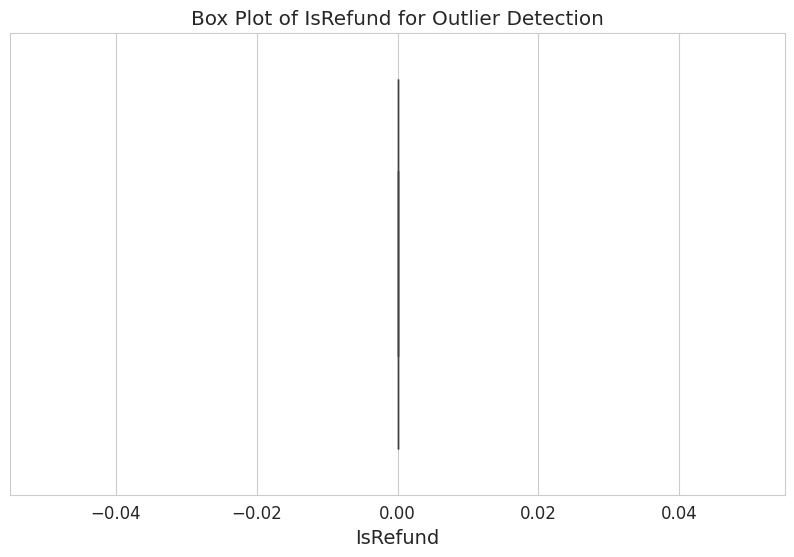


--- Outlier Analysis for Feature: CustomerId_transactions_last_1d ---
IQR for CustomerId_transactions_last_1d: 0.00
Lower Bound: 0.00, Upper Bound: 0.00
Number of outliers detected: 0


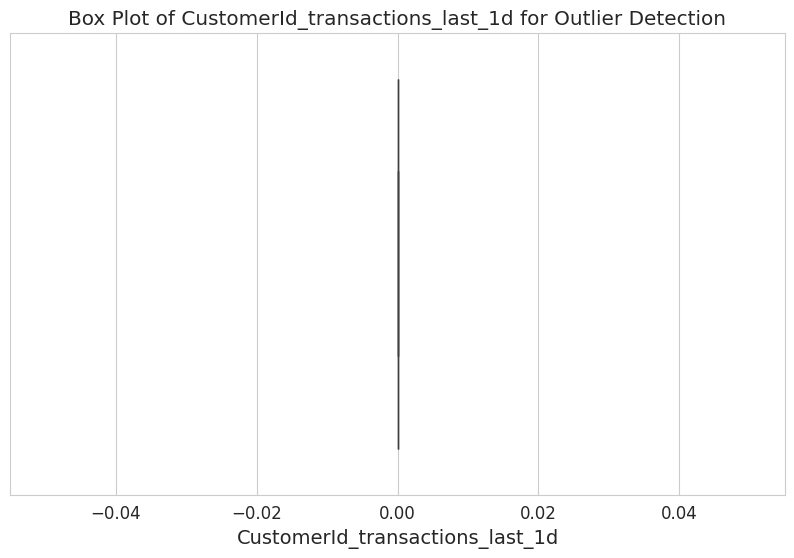


--- Outlier Analysis for Feature: CustomerId_total_amount_last_1d ---
IQR for CustomerId_total_amount_last_1d: 0.00
Lower Bound: 0.00, Upper Bound: 0.00
Number of outliers detected: 0


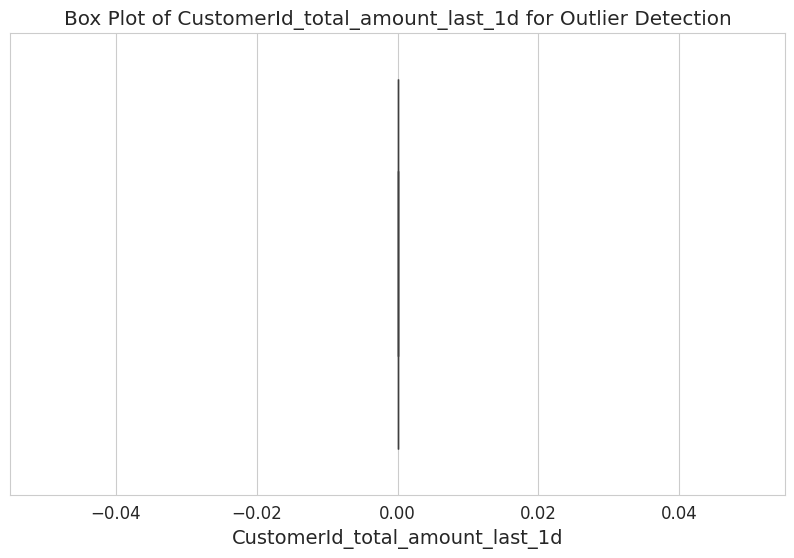


--- Outlier Analysis for Feature: device_id_transactions_last_1d ---
IQR for device_id_transactions_last_1d: 0.00
Lower Bound: -0.18, Upper Bound: -0.18
Number of outliers detected: 6903
Outlier percentage: 4.57%
Sample outliers:
2     7.148410
24    4.215116
29    3.481792
64    2.015145
77    2.015145
Name: device_id_transactions_last_1d, dtype: float64


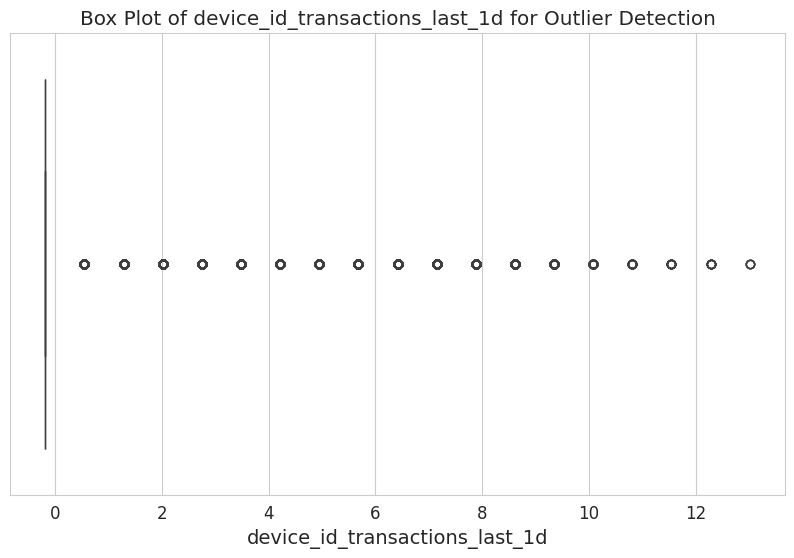


--- Outlier Analysis for Feature: ip_address_transactions_last_1d ---
IQR for ip_address_transactions_last_1d: 0.00
Lower Bound: -0.18, Upper Bound: -0.18
Number of outliers detected: 6849
Outlier percentage: 4.53%
Sample outliers:
2     7.149013
24    4.215579
29    3.482220
64    2.015503
77    2.015503
Name: ip_address_transactions_last_1d, dtype: float64


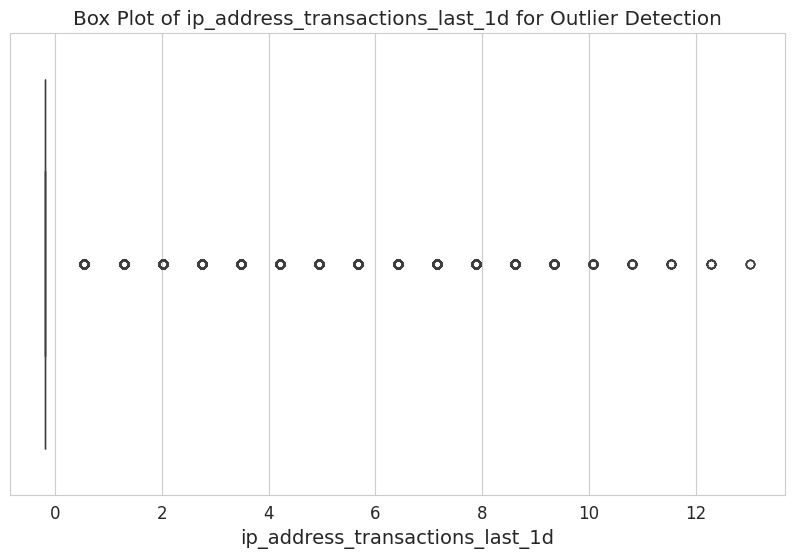

In [14]:
if not fraud_processed_df.empty:
    print("\n--- Outlier Analysis for E-commerce Fraud Data ---")
    outlier_analyzer = OutlierAnalyzer(IQRBasedOutlierAnalysis())

    # Focus on key numerical features including engineered ones
    fraud_outlier_cols = [
        'Amount', 'age', 'time_since_signup', 'IsRefund',
        'CustomerId_transactions_last_1d', 'CustomerId_total_amount_last_1d',
        'device_id_transactions_last_1d', 'ip_address_transactions_last_1d'
    ]
    fraud_outlier_cols = [col for col in fraud_outlier_cols if col in fraud_processed_df.columns]

    for col in fraud_outlier_cols:
        outlier_analyzer.execute_analysis(fraud_processed_df, col)
else:
    print("E-commerce Fraud Data is empty, skipping Outlier Analysis.")


### **3.7 Temporal Trend Analysis**
Temporal analysis examines how features and fraud patterns change over time. This is particularly important for transaction data, as fraud often exhibits temporal trends or seasonality.


--- Temporal Analysis for E-commerce Fraud Data ---

--- Analyzing Monthly Trends for Amount, class ---


/home/micha/Downloads/course/10-accedemy/week-8-9/E-commerce-Bank-Fraud-Detection/src/eda/temporal_analysis.py:67: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_processed['YearMonth'] = df_processed[time_column].dt.to_period('M')


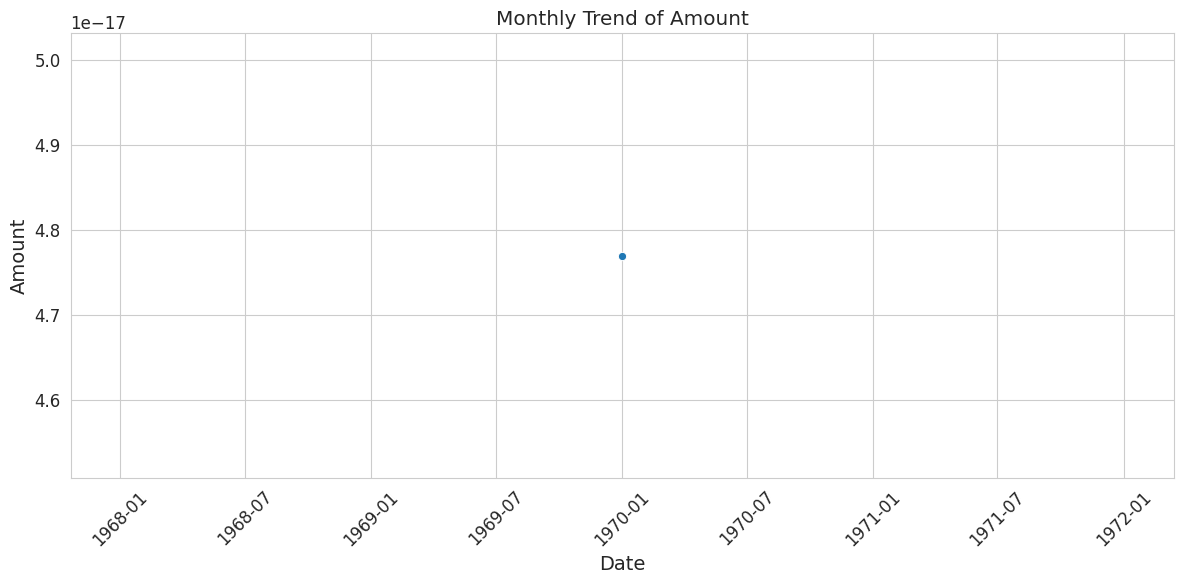

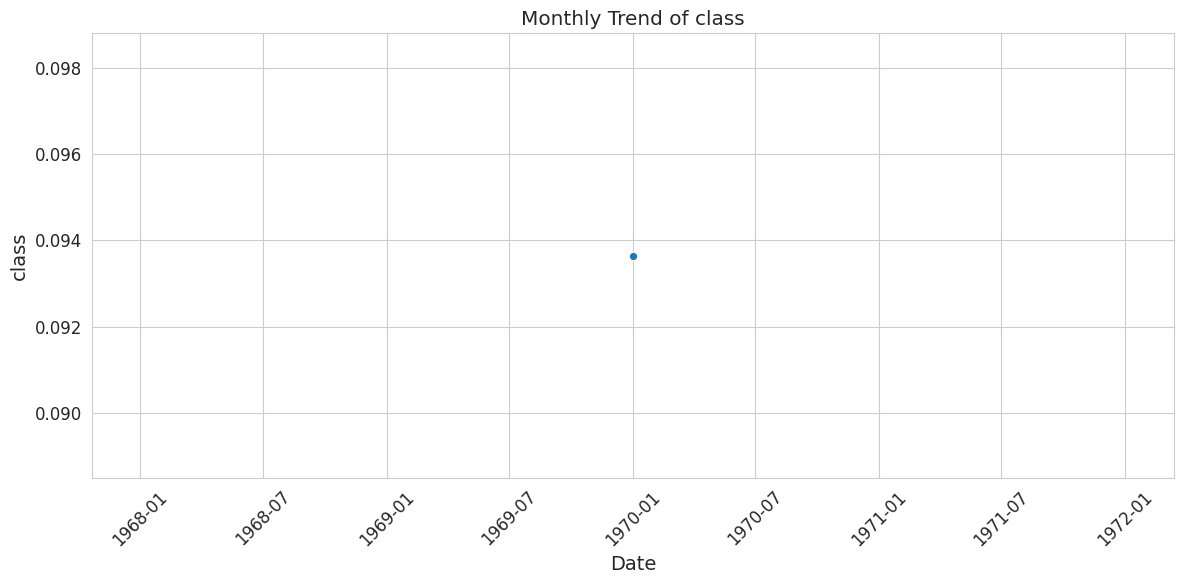

In [15]:
if not fraud_processed_df.empty:
    print("\n--- Temporal Analysis for E-commerce Fraud Data ---")
    time_col_for_temporal = 'TransactionStartTime'

    # The preprocessor is designed to keep 'TransactionStartTime' for temporal analysis.
    # If it's not present, it means there was an issue in preprocessing or the column name is wrong.
    if time_col_for_temporal in fraud_processed_df.columns:
        # Ensure the time column is datetime type for temporal analysis
        fraud_processed_df[time_col_for_temporal] = pd.to_datetime(fraud_processed_df[time_col_for_temporal], errors='coerce')
        # Drop rows where TransactionStartTime became NaT after coercion
        fraud_processed_df.dropna(subset=[time_col_for_temporal], inplace=True)

        if not fraud_processed_df.empty:
            temporal_analyzer = TemporalAnalyzer(MonthlyTrendAnalysis())
            temporal_metrics = ['Amount', FRAUD_TARGET_COL]
            temporal_metrics = [col for col in temporal_metrics if col in fraud_processed_df.columns]
            if temporal_metrics:
                temporal_analyzer.execute_analysis(fraud_processed_df, time_col_for_temporal, temporal_metrics)
            else:
                print(f"No valid metrics for temporal analysis in E-commerce Fraud Data.")
        else:
            print(f"E-commerce Fraud Data became empty after handling invalid '{time_col_for_temporal}' values. Skipping temporal analysis.")
    else:
        print(f"Time column '{time_col_for_temporal}' not found in E-commerce Fraud Data. Skipping temporal analysis.")
else:
    print("E-commerce Fraud Data is empty, skipping Temporal Analysis.")


## **4. EDA for Bank Credit Card Fraud Data (creditcard.csv)**

This section focuses on the Exploratory Data Analysis of the preprocessed Bank Credit Card Fraud Data. We will apply similar analytical techniques to understand its unique characteristics, distributions, and fraud patterns.

### **4.1 Data Understanding and Initial Quality Check**

#### Data Structure and Quality Assessment (using `DataTypesAndNonNullInspectionStrategy`)

In [16]:
if not creditcard_processed_df.empty:
    print("\n--- Data Types and Non-null Counts for Bank Credit Card Fraud Data ---")
    inspector = DataInspector(DataTypesAndNonNullInspectionStrategy())
    inspector.execute_inspection(creditcard_processed_df)
else:
    print("Bank Credit Card Fraud Data is empty, skipping Data Structure and Quality Assessment.")



--- Data Types and Non-null Counts for Bank Credit Card Fraud Data ---

--- Data Types and Non-null Counts ---
            Dtype  Non-Null Count  Null Count  Null Percentage
V1        float64          283726           0              0.0
V2        float64          283726           0              0.0
V3        float64          283726           0              0.0
V4        float64          283726           0              0.0
V5        float64          283726           0              0.0
V6        float64          283726           0              0.0
V7        float64          283726           0              0.0
V8        float64          283726           0              0.0
V9        float64          283726           0              0.0
V10       float64          283726           0              0.0
V11       float64          283726           0              0.0
V12       float64          283726           0              0.0
V13       float64          283726           0              0.0
V14   

#### Descriptive Statistics & Variability (using `SummaryStatisticsInspectionStrategy`)

In [17]:
if not creditcard_processed_df.empty:
    print("\n--- Summary Statistics for Bank Credit Card Fraud Data ---")
    inspector = DataInspector(SummaryStatisticsInspectionStrategy())
    inspector.execute_inspection(creditcard_processed_df)
else:
    print("Bank Credit Card Fraud Data is empty, skipping Descriptive Statistics.")



--- Summary Statistics for Bank Credit Card Fraud Data ---

--- Summary Statistics ---
                 V1            V2            V3            V4            V5  \
count  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05   
mean  -5.008654e-17 -4.006924e-18 -1.089883e-16  2.804846e-17  4.728170e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.895933e+01 -4.415594e+01 -3.203279e+01 -4.016602e+00 -8.260323e+01   
25%   -4.732329e-01 -3.620488e-01 -5.907784e-01 -5.990519e-01 -5.022907e-01   
50%    7.426456e-03  4.134568e-02  1.182157e-01 -1.363454e-02 -4.015609e-02   
75%    6.725541e-01  4.885028e-01  6.796321e-01  5.251188e-01  4.432736e-01   
max    1.257179e+00  1.339762e+01  6.217985e+00  1.193504e+01  2.527211e+01   

                 V6            V7            V8            V9           V10  \
count  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05   
mean   8.013847e-18 -2.283946e-17 -7.61315

### **4.2 Missing Values Analysis**

In [18]:
if not creditcard_processed_df.empty:
    print("\n--- Missing Values Analysis for Bank Credit Card Fraud Data ---")
    missing_analyzer = SimpleMissingValuesAnalysis()
    missing_analyzer.analyze(creditcard_processed_df)
else:
    print("Bank Credit Card Fraud Data is empty, skipping Missing Values Analysis.")



--- Missing Values Analysis for Bank Credit Card Fraud Data ---

--- Missing Values Count by Column ---
No missing values found in the DataFrame.

Visualizing Missing Values...
No missing values to visualize.


### **4.3 Univariate Analysis**


--- Univariate Analysis for Bank Credit Card Fraud Data ---

--- Analyzing Numerical Feature: V1 ---


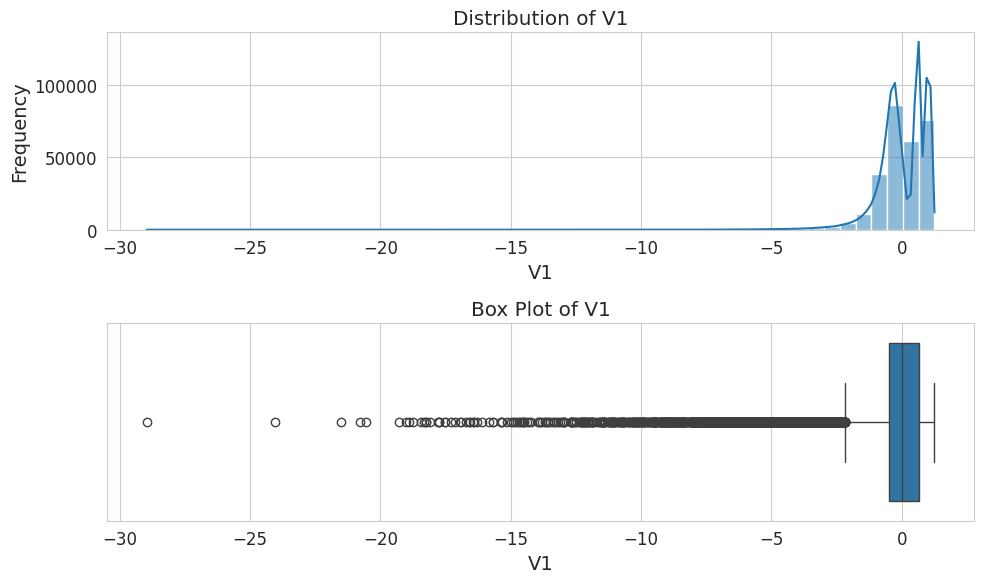


--- Analyzing Numerical Feature: V2 ---


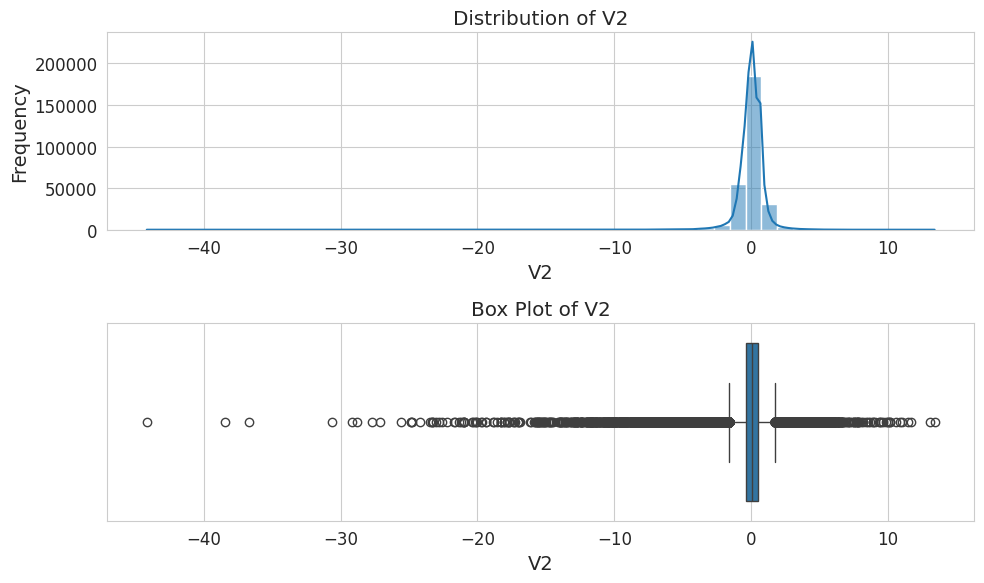


--- Analyzing Numerical Feature: V3 ---


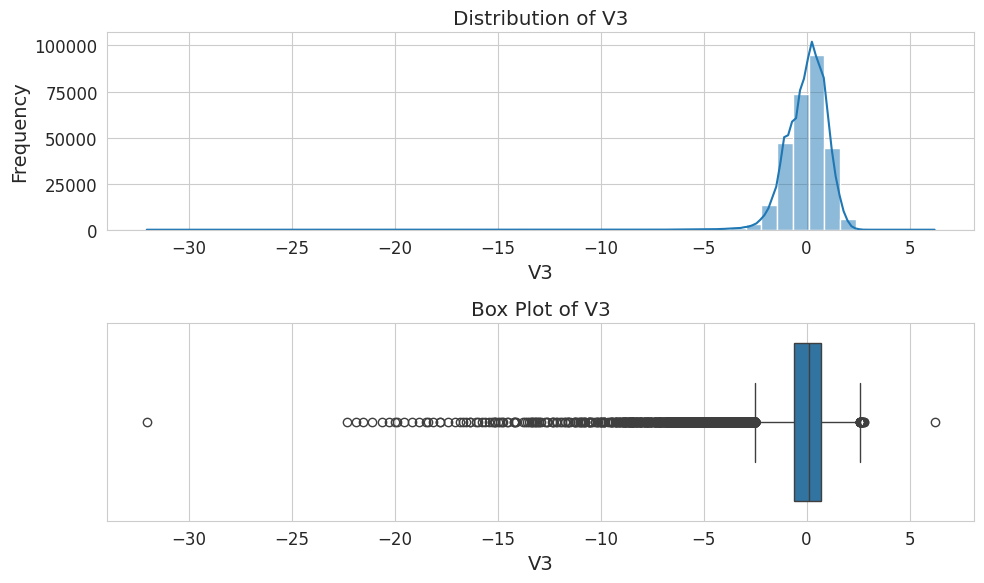


--- Analyzing Numerical Feature: V4 ---


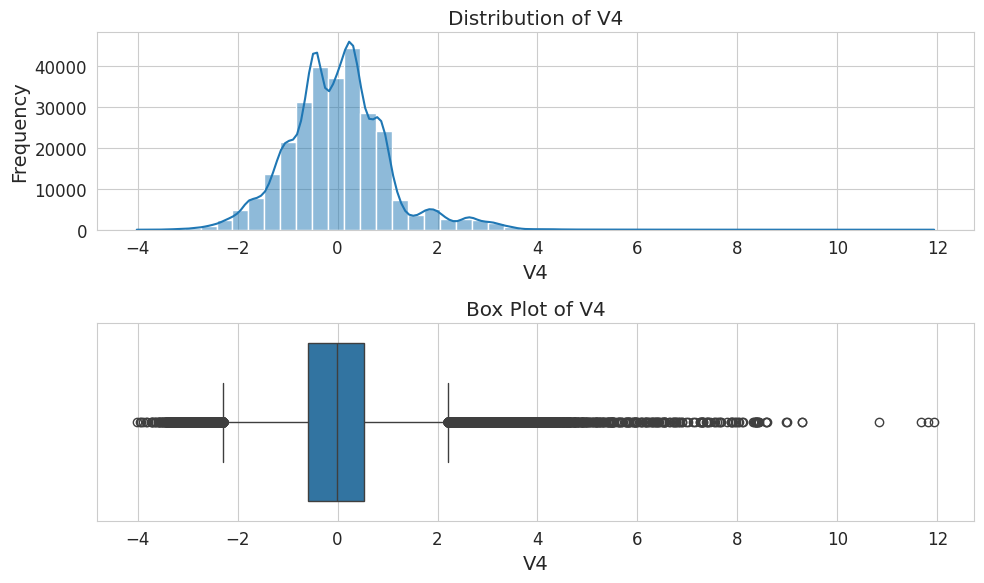


--- Analyzing Numerical Feature: V5 ---


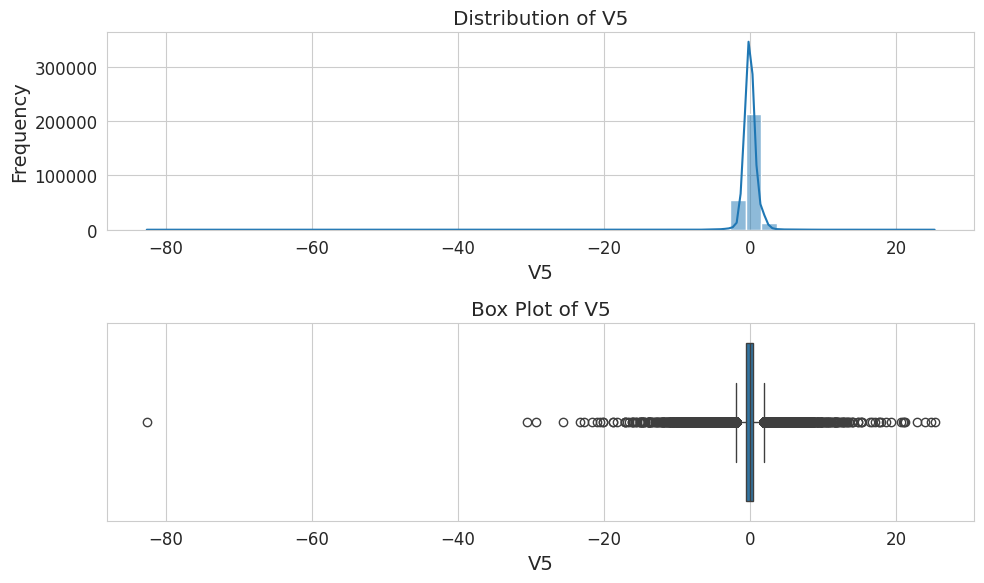


--- Analyzing Numerical Feature: V6 ---


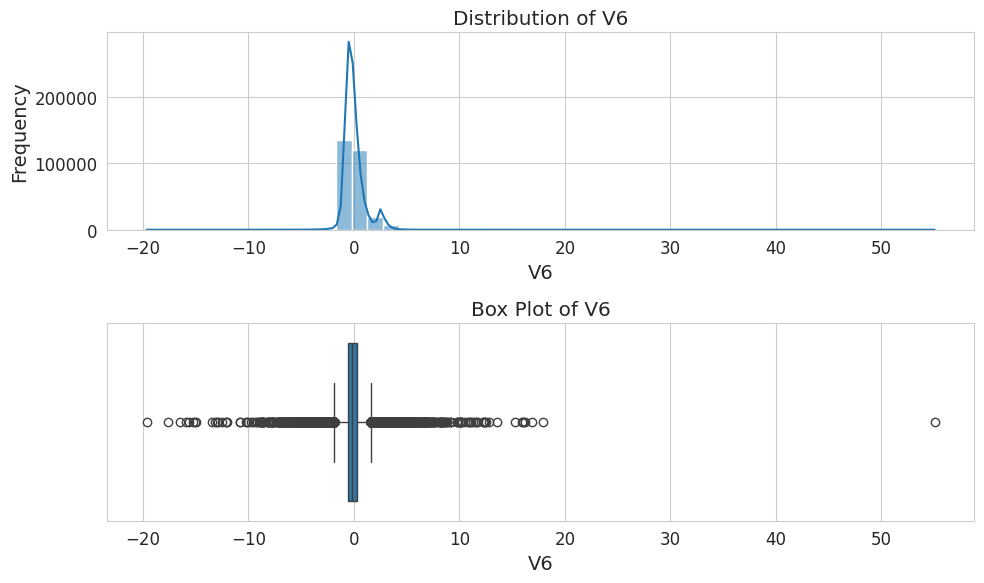


--- Analyzing Numerical Feature: V7 ---


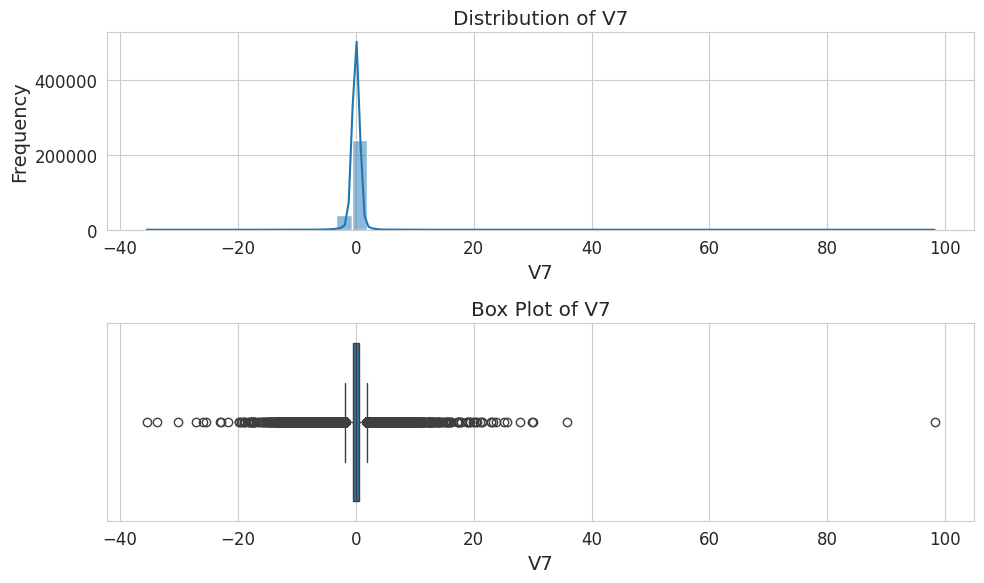


--- Analyzing Numerical Feature: V8 ---


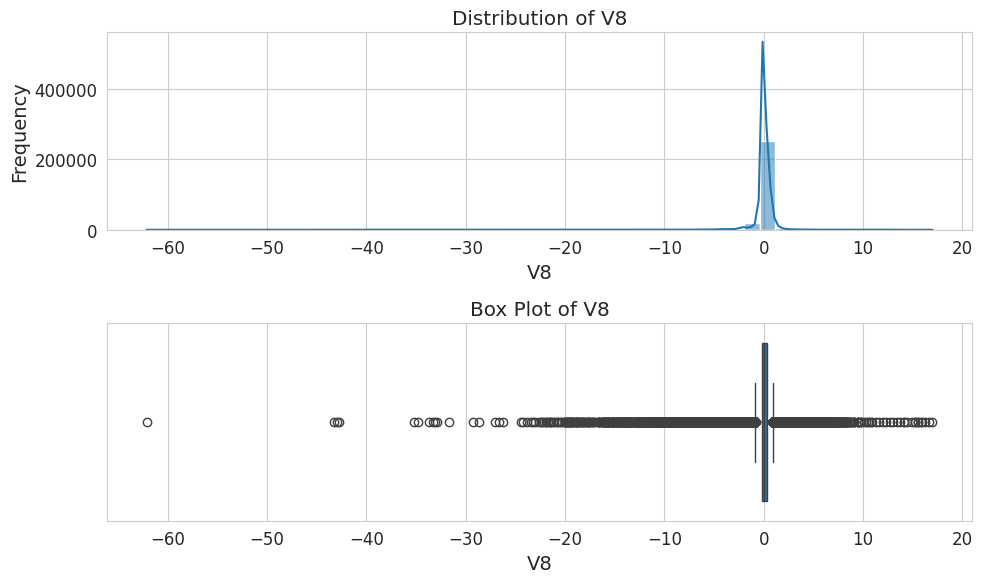


--- Analyzing Numerical Feature: V9 ---


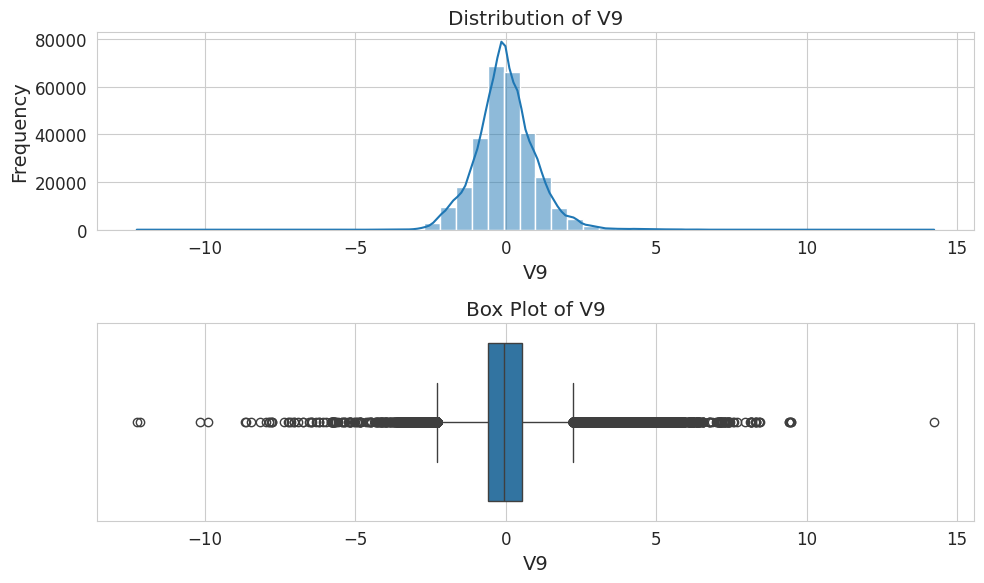


--- Analyzing Numerical Feature: V10 ---


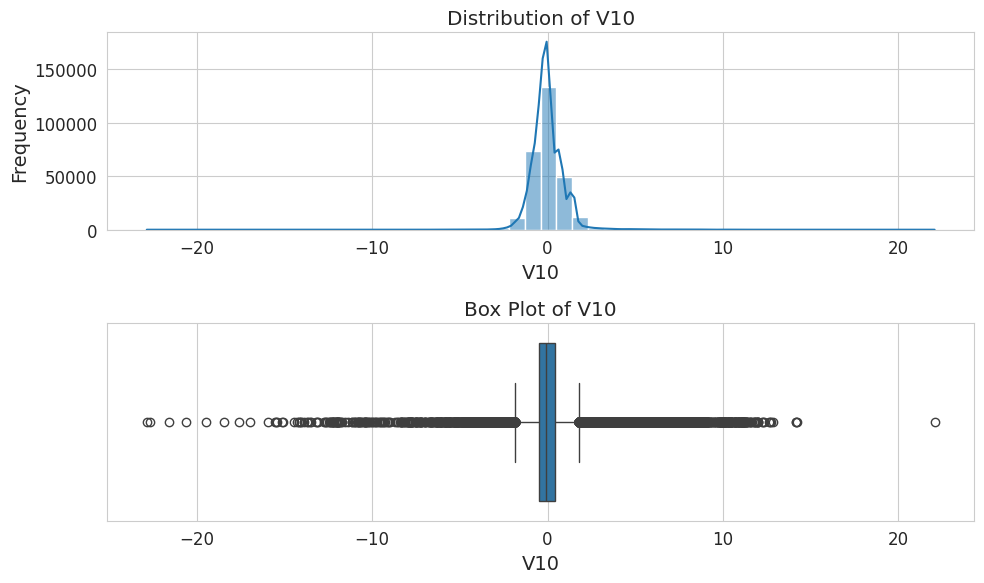


--- Analyzing Numerical Feature: V11 ---


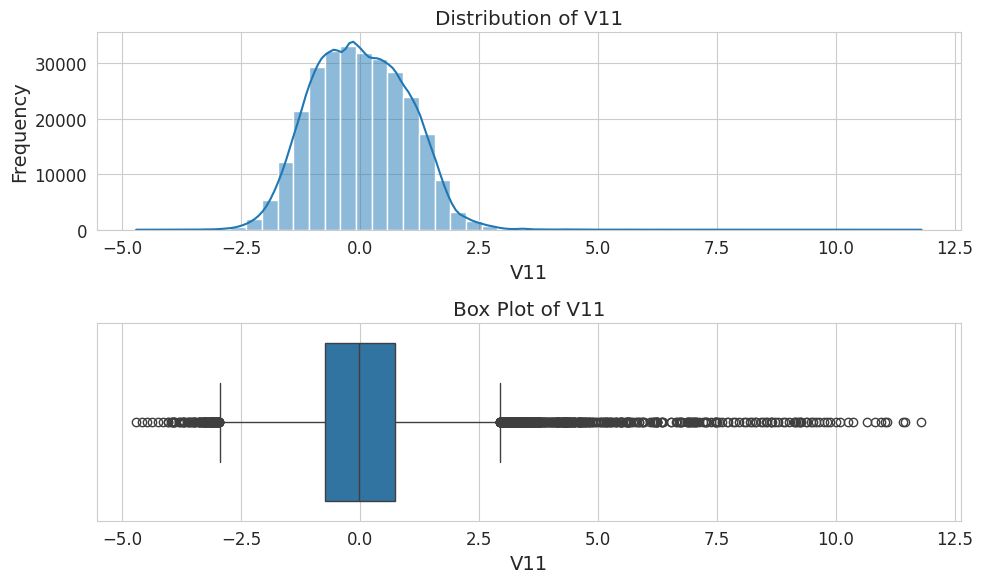


--- Analyzing Numerical Feature: V12 ---


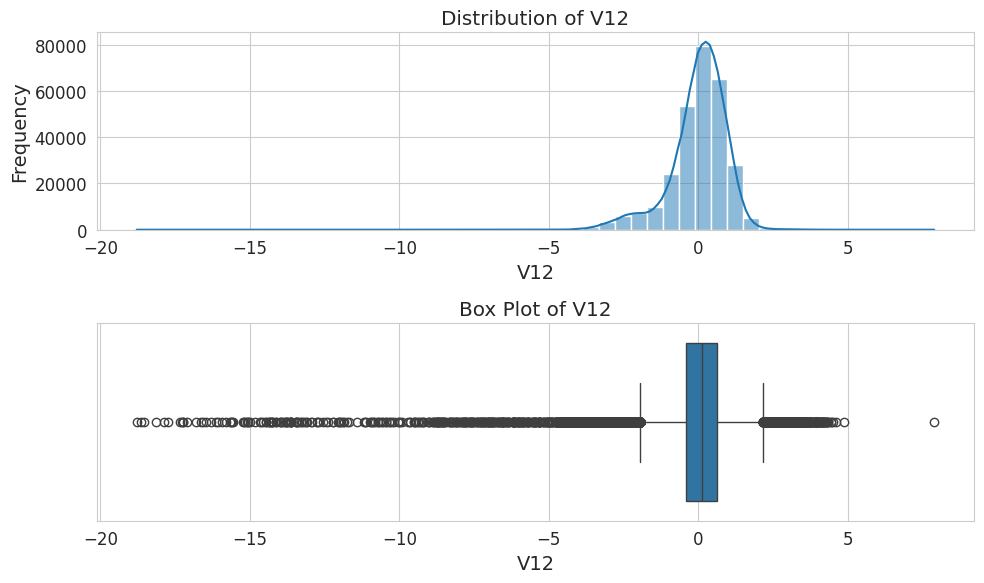


--- Analyzing Numerical Feature: V13 ---


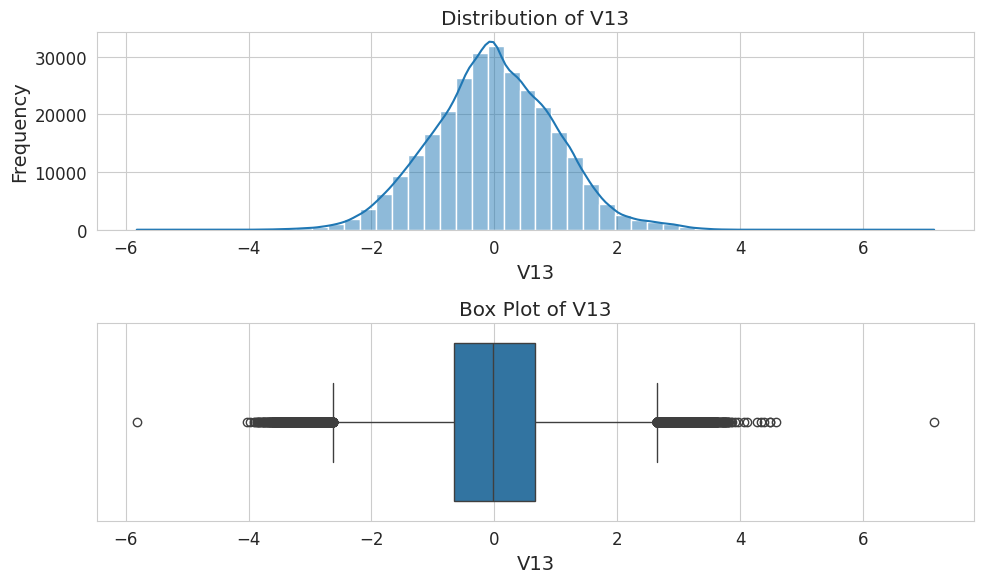


--- Analyzing Numerical Feature: V14 ---


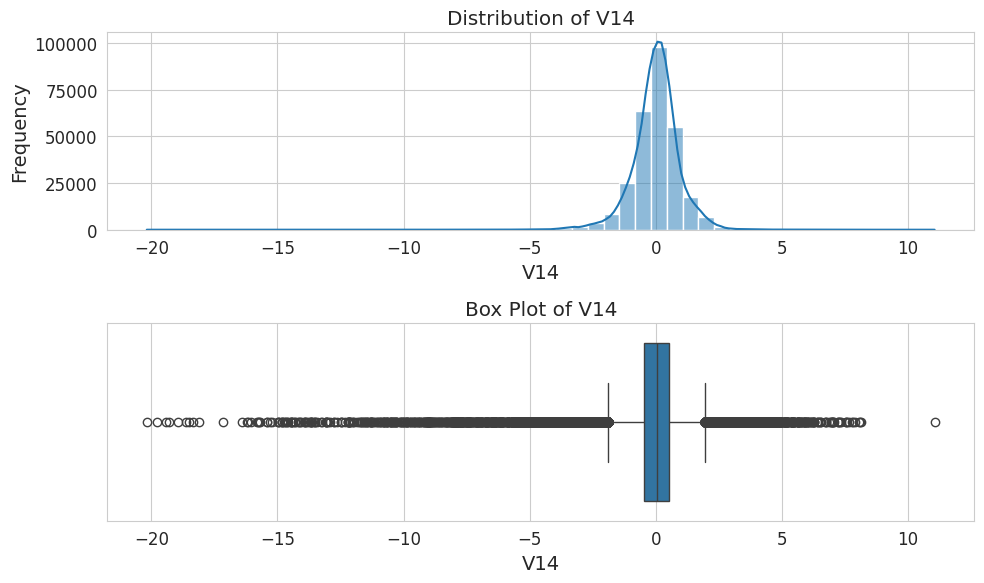


--- Analyzing Numerical Feature: V15 ---


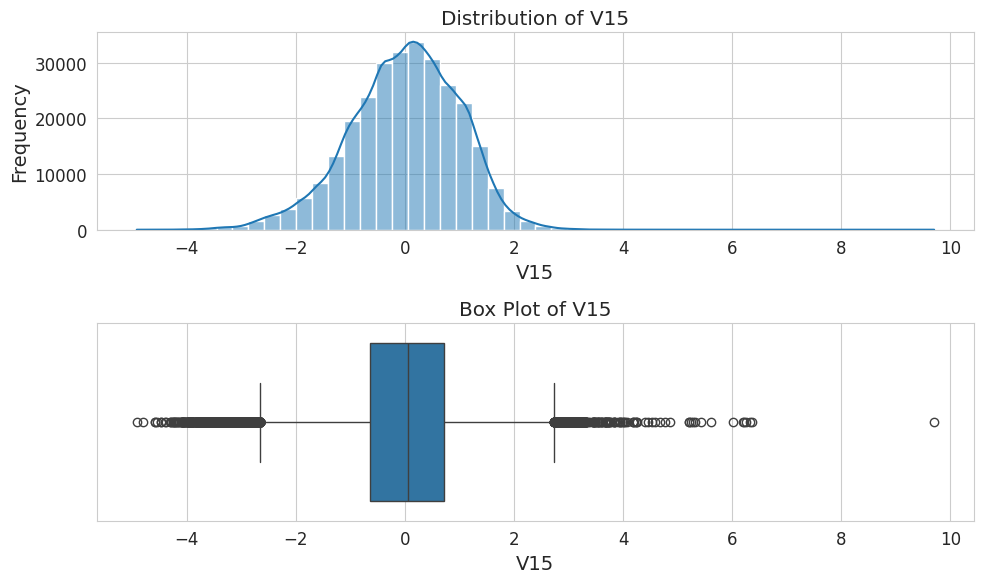


--- Analyzing Numerical Feature: V16 ---


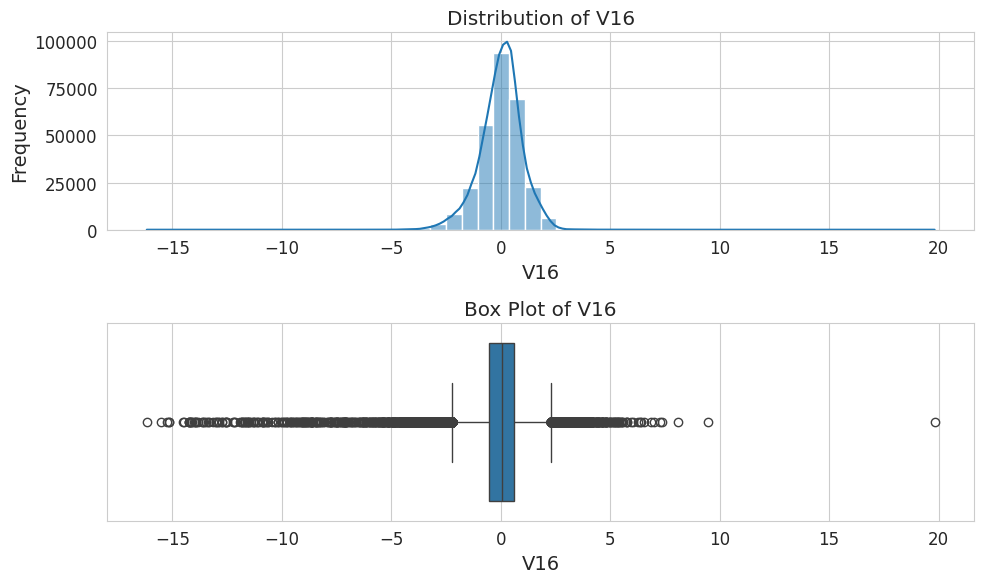


--- Analyzing Numerical Feature: V17 ---


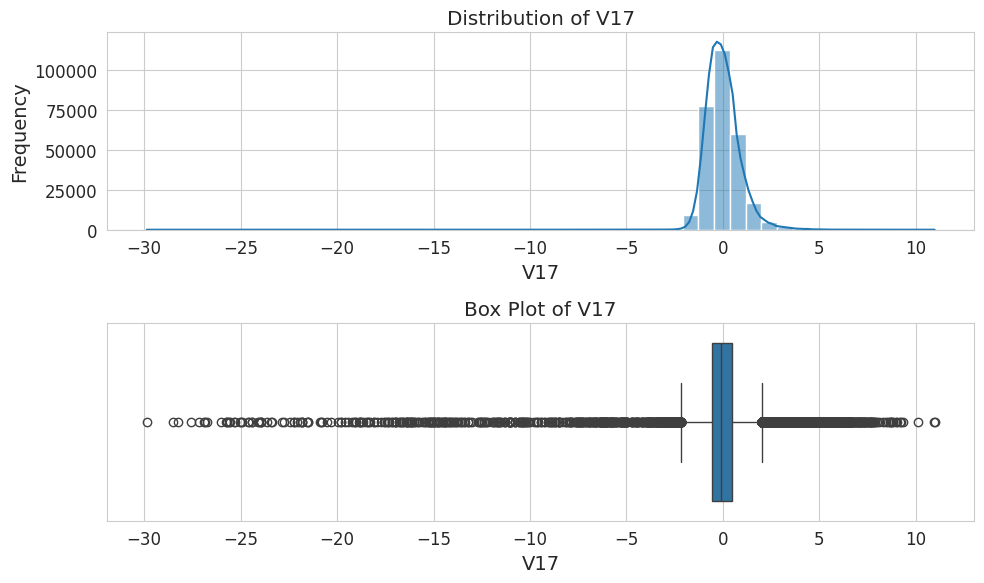


--- Analyzing Numerical Feature: V18 ---


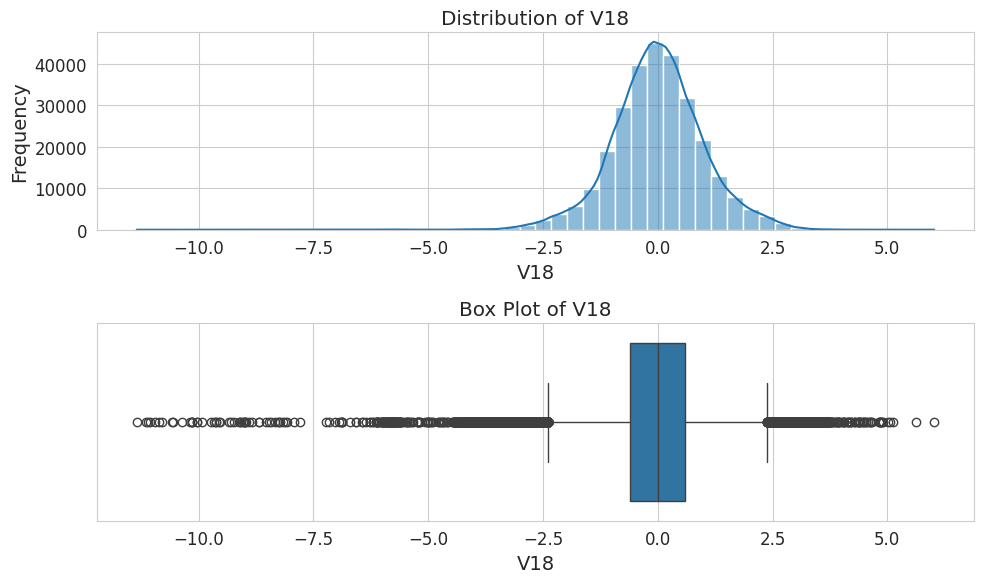


--- Analyzing Numerical Feature: V19 ---


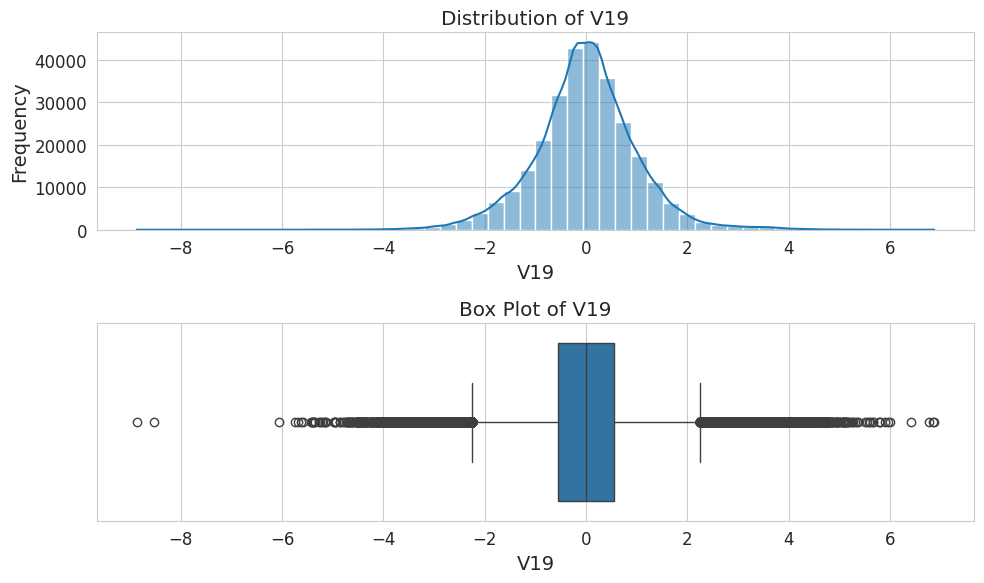


--- Analyzing Numerical Feature: V20 ---


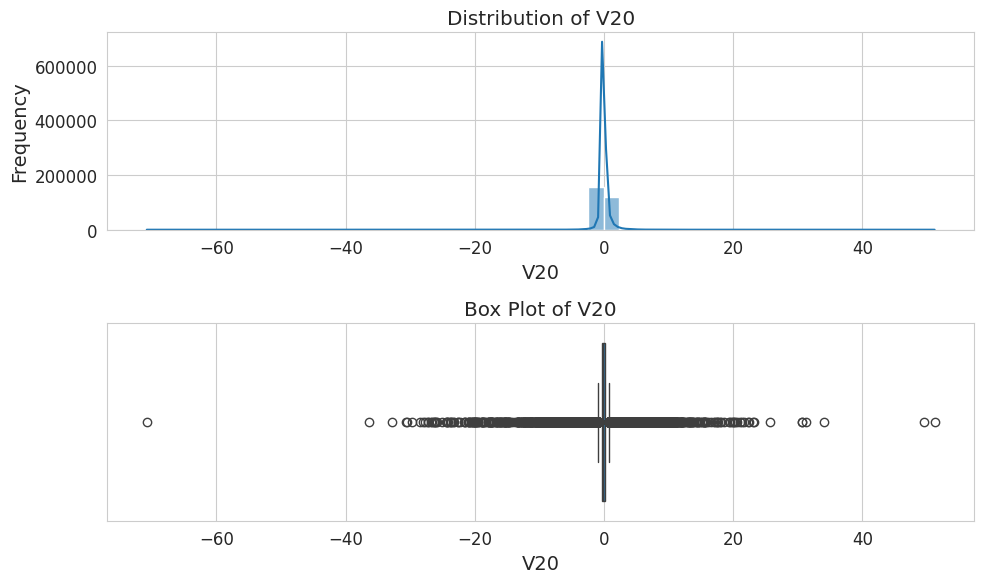


--- Analyzing Numerical Feature: V21 ---


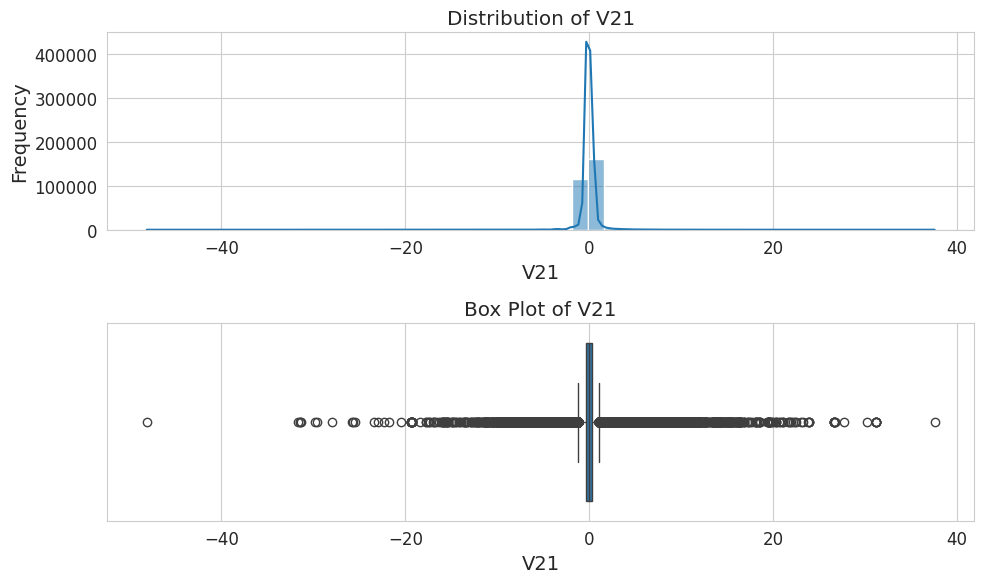


--- Analyzing Numerical Feature: V22 ---


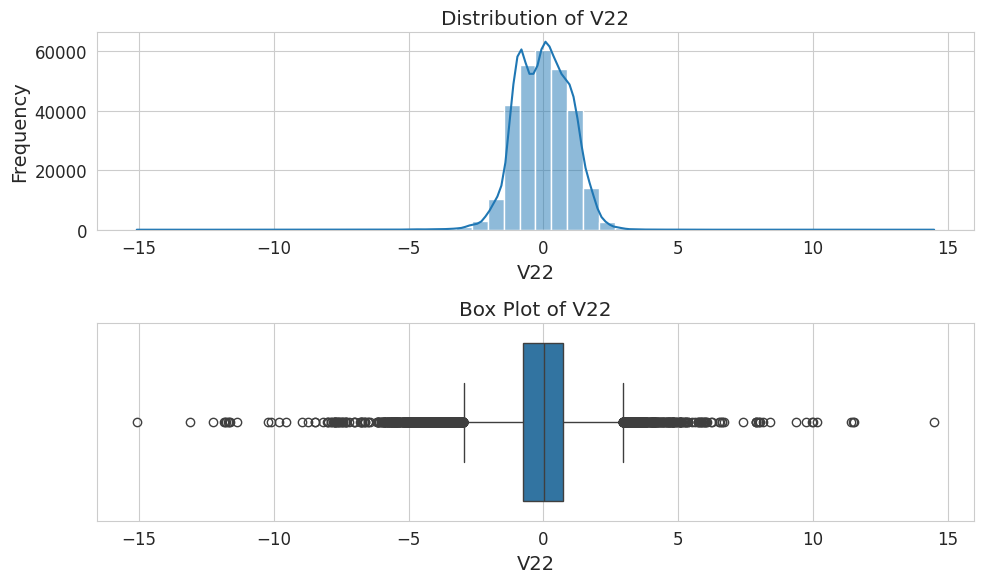


--- Analyzing Numerical Feature: V23 ---


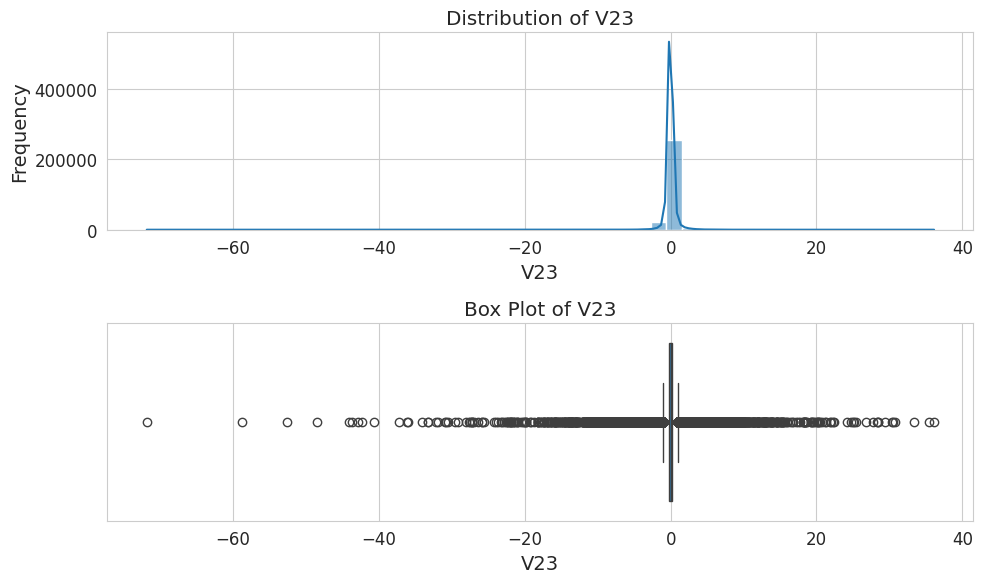


--- Analyzing Numerical Feature: V24 ---


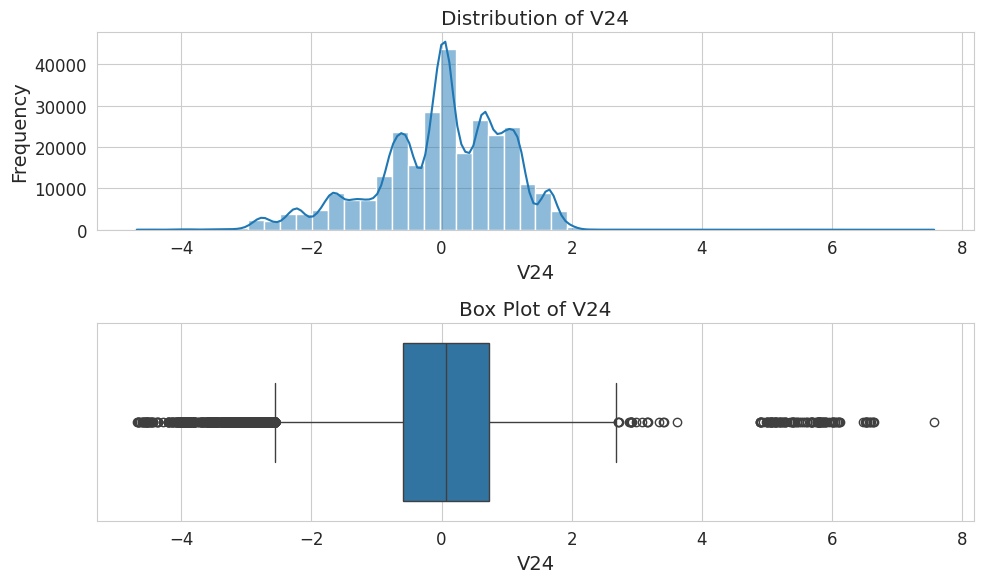


--- Analyzing Numerical Feature: V25 ---


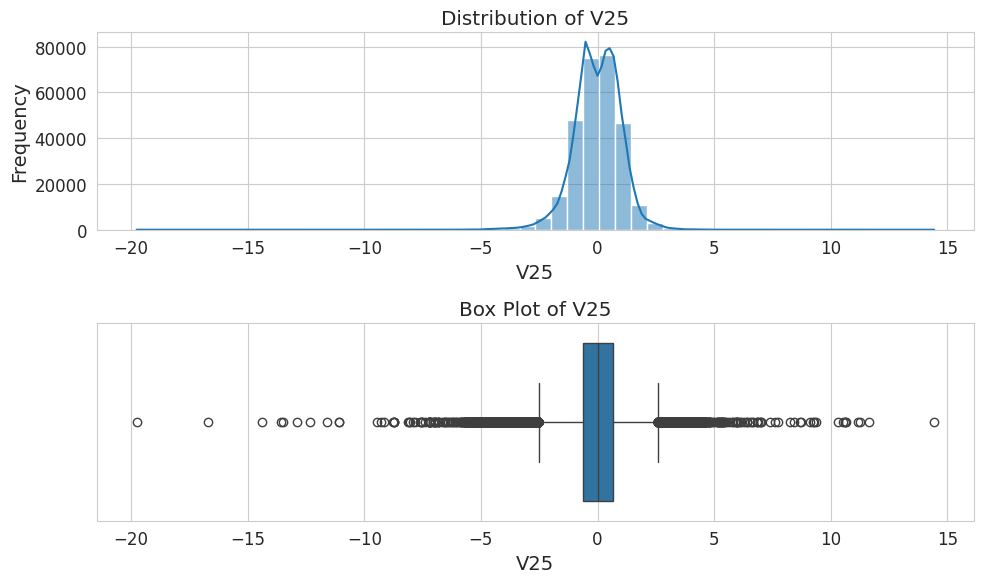


--- Analyzing Numerical Feature: V26 ---


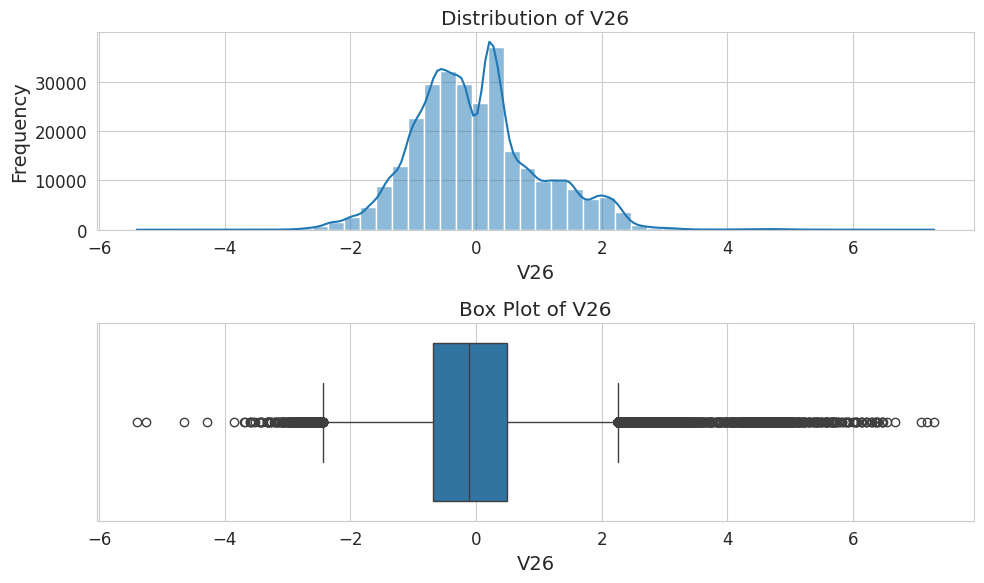


--- Analyzing Numerical Feature: V27 ---


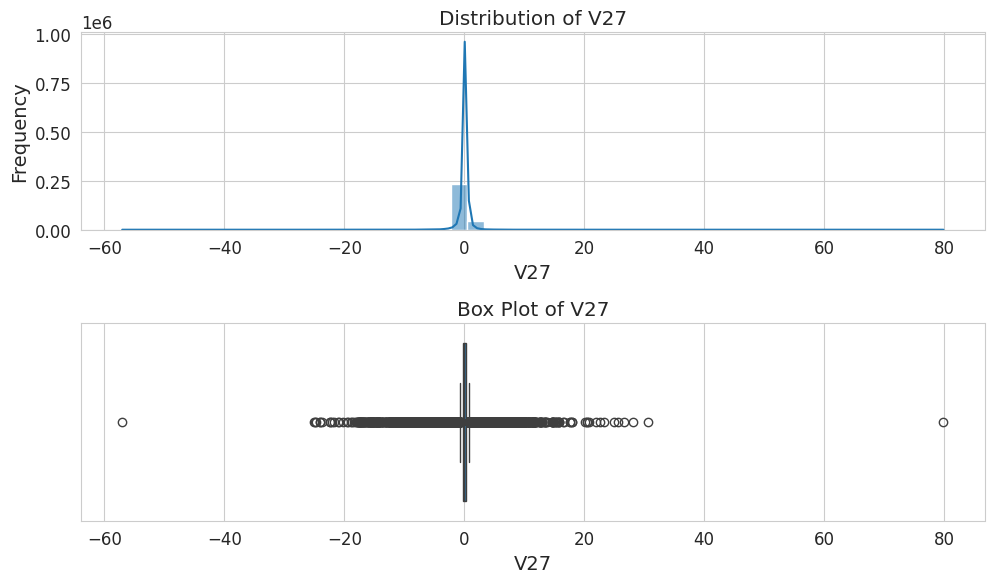


--- Analyzing Numerical Feature: V28 ---


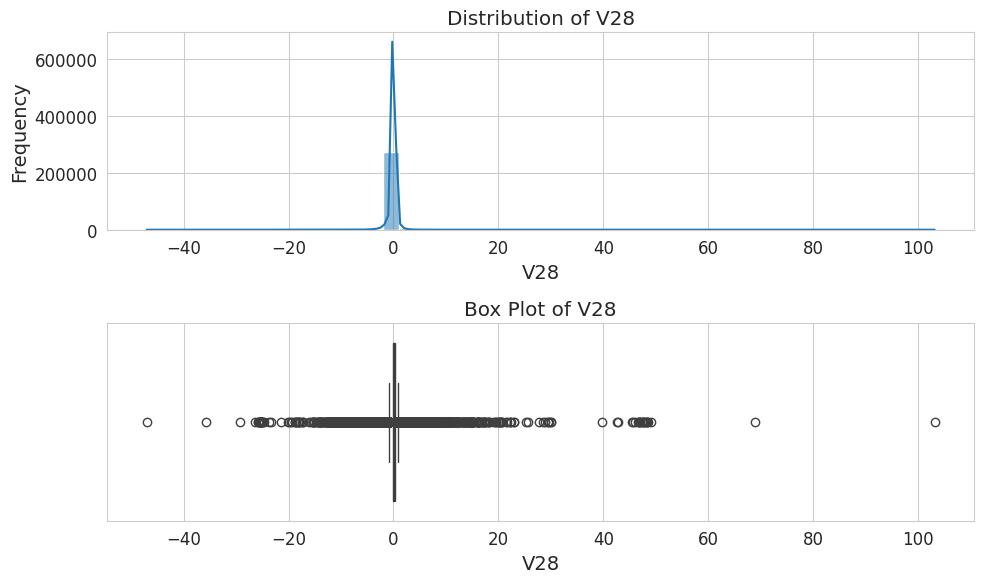


--- Analyzing Numerical Feature: Time ---


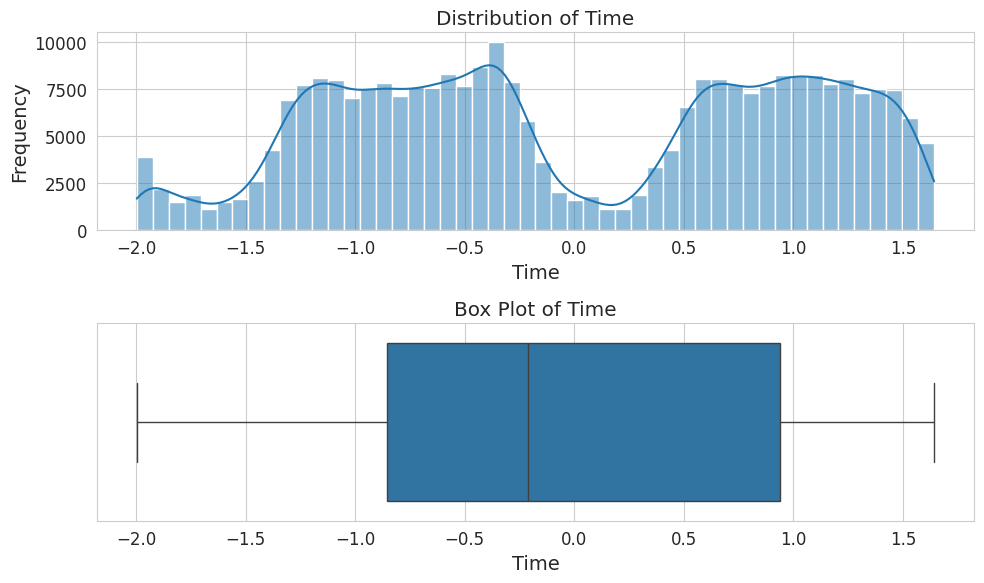


--- Analyzing Numerical Feature: Amount ---


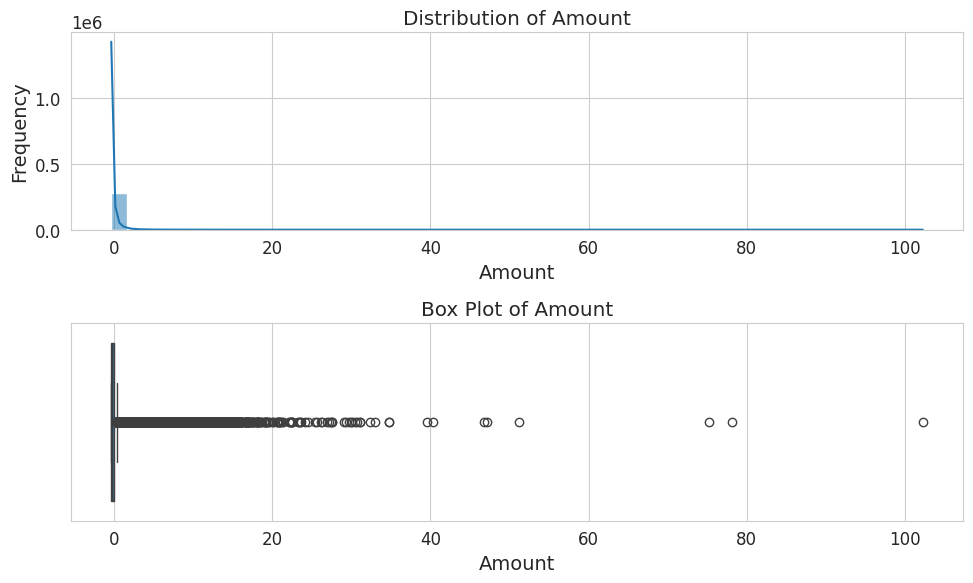


--- Analyzing Numerical Feature: IsRefund ---


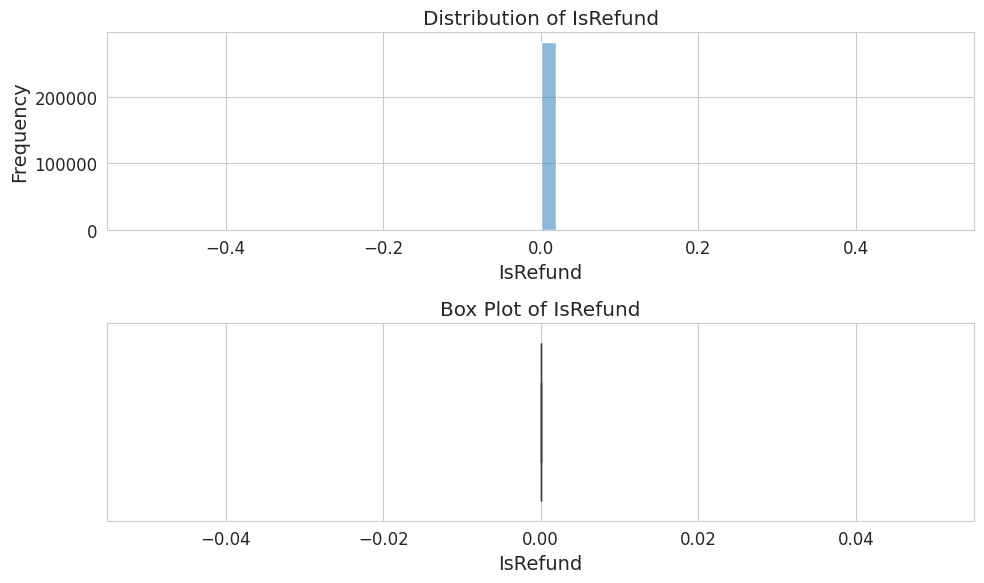


--- Analyzing Categorical Feature: Class ---


/home/micha/Downloads/course/10-accedemy/week-8-9/E-commerce-Bank-Fraud-Detection/src/eda/univariate_analysis.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=feature, data=df_processed, order=df_processed[feature].value_counts().index, palette='viridis')


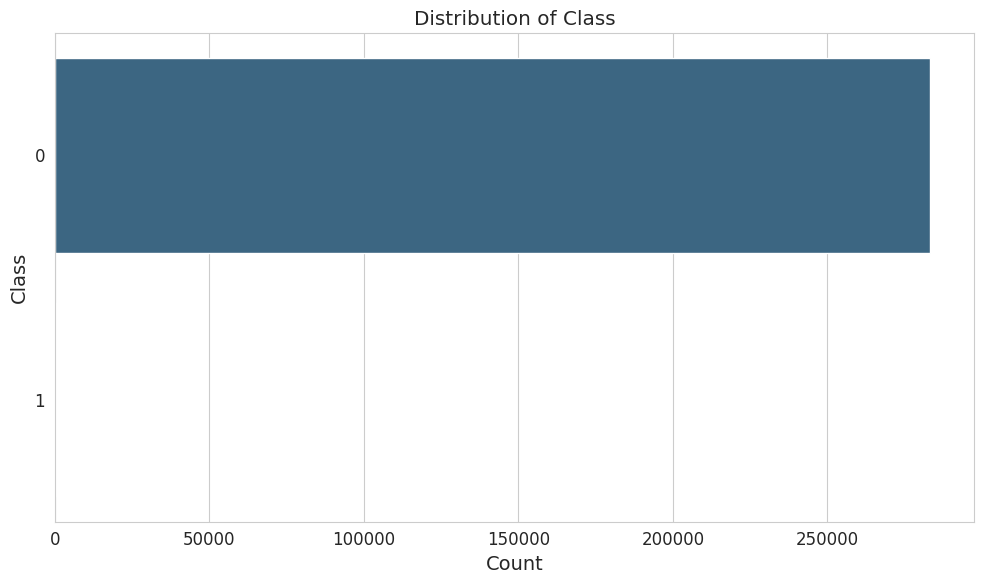


--- Class Distribution for 'Class' in Bank Credit Card Fraud Data ---
Class
0    283253
1       473
Name: count, dtype: int64
Fraudulent transactions: 473 (0.17%) 
Non-fraudulent transactions: 283253 (99.83%) 


/tmp/ipykernel_17825/1305714951.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=CREDITCARD_TARGET_COL, data=creditcard_processed_df, palette='coolwarm')


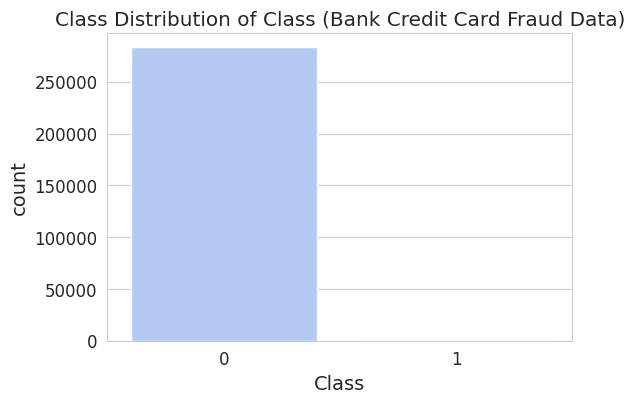

In [19]:
if not creditcard_processed_df.empty:
    print("\n--- Univariate Analysis for Bank Credit Card Fraud Data ---")

    creditcard_numerical_features_for_eda = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount', 'IsRefund']
    creditcard_numerical_features_for_eda = [col for col in creditcard_numerical_features_for_eda if col in creditcard_processed_df.columns]

    creditcard_categorical_features_for_eda = [CREDITCARD_TARGET_COL]
    creditcard_categorical_features_for_eda = [col for col in creditcard_categorical_features_for_eda if col in creditcard_processed_df.columns]

    # Numerical Univariate Analysis
    univariate_analyzer_num = UnivariateAnalyzer(NumericalUnivariateAnalysis())
    for col in creditcard_numerical_features_for_eda:
        univariate_analyzer_num.execute_analysis(creditcard_processed_df, col)

    # Categorical Univariate Analysis (mainly for the target variable)
    univariate_analyzer_cat = UnivariateAnalyzer(CategoricalUnivariateAnalysis())
    for col in creditcard_categorical_features_for_eda:
        univariate_analyzer_cat.execute_analysis(creditcard_processed_df, col)

    # Class Imbalance Check for Class
    if CREDITCARD_TARGET_COL in creditcard_processed_df.columns:
        print(f"\n--- Class Distribution for '{CREDITCARD_TARGET_COL}' in Bank Credit Card Fraud Data ---")
        class_counts = creditcard_processed_df[CREDITCARD_TARGET_COL].value_counts()
        print(class_counts)
        print(f"Fraudulent transactions: {class_counts.get(1, 0)} ({class_counts.get(1, 0) / len(creditcard_processed_df) * 100:.2f}%) ")
        print(f"Non-fraudulent transactions: {class_counts.get(0, 0)} ({class_counts.get(0, 0) / len(creditcard_processed_df) * 100:.2f}%) ")
        plt.figure(figsize=(6, 4))
        sns.countplot(x=CREDITCARD_TARGET_COL, data=creditcard_processed_df, palette='coolwarm')
        plt.title(f'Class Distribution of {CREDITCARD_TARGET_COL} (Bank Credit Card Fraud Data)')
        plt.show()
    else:
        print(f"Target column '{CREDITCARD_TARGET_COL}' not found in Bank Credit Card Fraud Data. Skipping class distribution check.")
else:
    print("Bank Credit Card Fraud Data is empty, skipping Univariate Analysis.")


### **4.4 Bivariate Analysis**


--- Bivariate Analysis for Bank Credit Card Fraud Data ---

--- Analyzing Numerical vs Numerical: Amount vs V1 ---


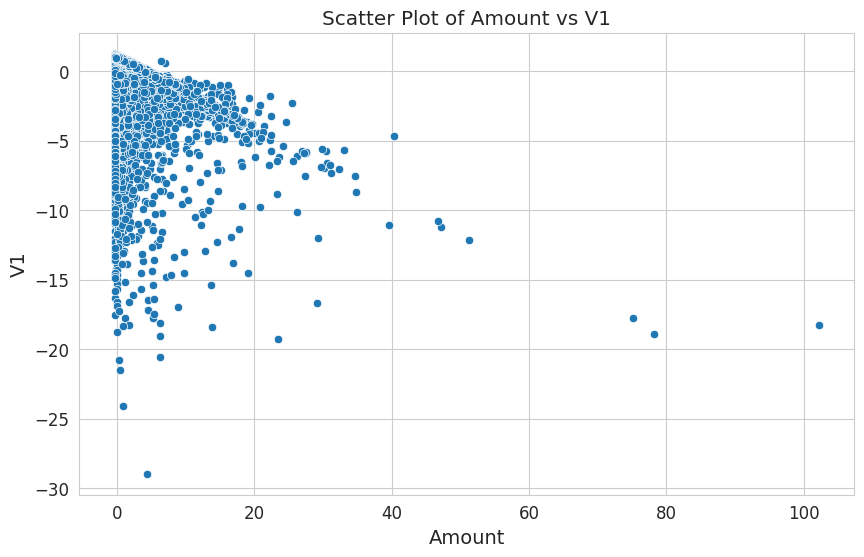

Pearson Correlation between Amount and V1: -0.2301

--- Analyzing Numerical vs Numerical: Time vs Amount ---


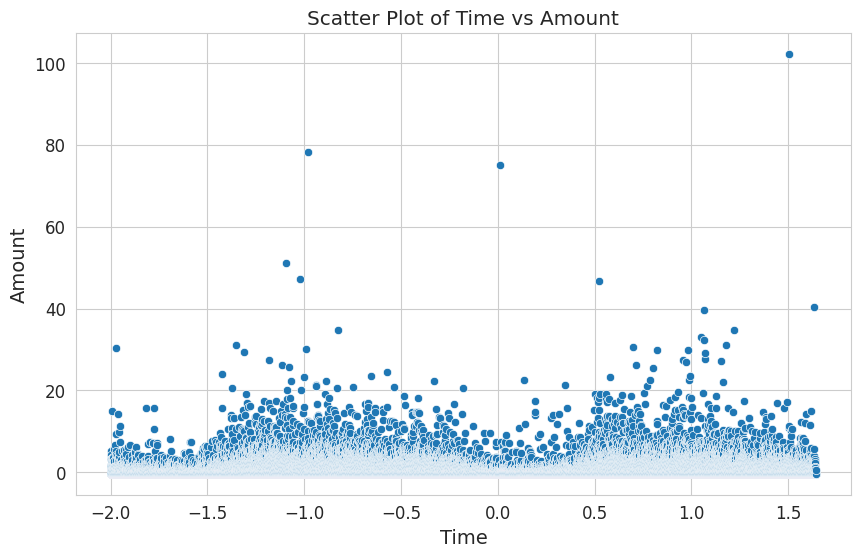

Pearson Correlation between Time and Amount: -0.0106
Error: One feature must be categorical and the other numerical for this analysis. Got 'int64' and 'float64'.
Error: One feature must be categorical and the other numerical for this analysis. Got 'int64' and 'float64'.
Error: One feature must be categorical and the other numerical for this analysis. Got 'int64' and 'float64'.


In [20]:
if not creditcard_processed_df.empty:
    print("\n--- Bivariate Analysis for Bank Credit Card Fraud Data ---")

    # Numerical vs Numerical
    bivariate_analyzer_num_num = BivariateAnalyzer(NumericalVsNumericalAnalysis())
    # Example: Amount vs V1
    if 'Amount' in creditcard_processed_df.columns and 'V1' in creditcard_processed_df.columns:
        bivariate_analyzer_num_num.execute_analysis(creditcard_processed_df, 'Amount', 'V1')
    # Example: Time vs Amount
    if 'Time' in creditcard_processed_df.columns and 'Amount' in creditcard_processed_df.columns:
        bivariate_analyzer_num_num.execute_analysis(creditcard_processed_df, 'Time', 'Amount')

    # Categorical vs Numerical (Target vs Amount/Time/V-features)
    bivariate_analyzer_cat_num = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
    if CREDITCARD_TARGET_COL in creditcard_processed_df.columns:
        if 'Amount' in creditcard_processed_df.columns:
            bivariate_analyzer_cat_num.execute_analysis(creditcard_processed_df, CREDITCARD_TARGET_COL, 'Amount')
        if 'Time' in creditcard_processed_df.columns:
            bivariate_analyzer_cat_num.execute_analysis(creditcard_processed_df, CREDITCARD_TARGET_COL, 'Time')
        # Example with a V feature
        if 'V17' in creditcard_processed_df.columns:
            bivariate_analyzer_cat_num.execute_analysis(creditcard_processed_df, CREDITCARD_TARGET_COL, 'V17')

    # No significant categorical vs categorical analysis expected for this dataset beyond target
else:
    print("Bank Credit Card Fraud Data is empty, skipping Bivariate Analysis.")


### **4.5 Multivariate Analysis**

In [21]:
# if not creditcard_processed_df.empty:
#     print("\n--- Multivariate Analysis for Bank Credit Card Fraud Data ---")
#     multivariate_analyzer = SimpleMultivariateAnalysis()

#     # Select a subset of numerical features for correlation heatmap and pair plot
#     creditcard_multivariate_features = ['Amount', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
#     creditcard_multivariate_features = [col for col in creditcard_multivariate_features if col in creditcard_processed_df.columns]

#     if creditcard_multivariate_features:
#         multivariate_analyzer.analyze(creditcard_processed_df, features=creditcard_multivariate_features)
#     else:
#         print("No suitable numerical features found for multivariate analysis in Bank Credit Card Fraud Data.")
# else:
#     print("Bank Credit Card Fraud Data is empty, skipping Multivariate Analysis.")


### **4.6 Outlier Analysis**


--- Outlier Analysis for Bank Credit Card Fraud Data ---

--- Outlier Analysis for Feature: Amount ---
IQR for Amount: 0.29
Lower Bound: -0.76, Upper Bound: 0.39
Number of outliers detected: 31685
Outlier percentage: 11.17%
Sample outliers:
2     1.158900
20    0.572036
49    5.249531
62    0.619760
83    0.445438
Name: Amount, dtype: float64


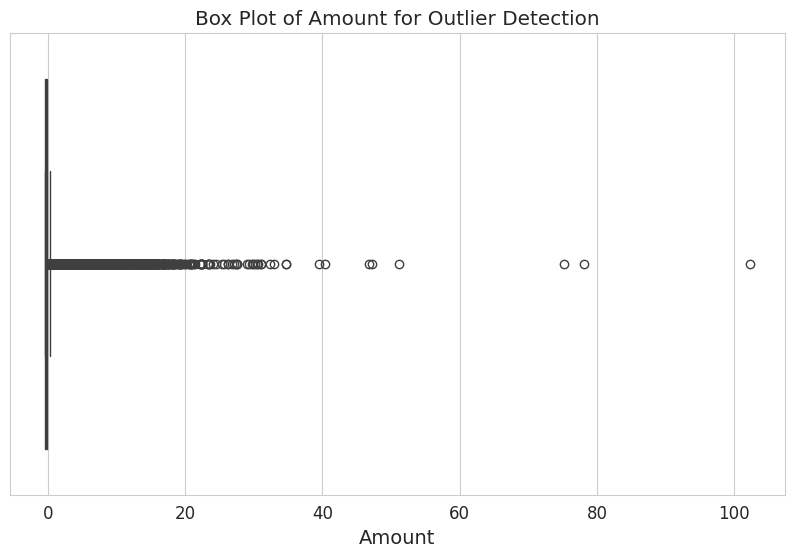


--- Outlier Analysis for Feature: Time ---
IQR for Time: 1.79
Lower Bound: -3.54, Upper Bound: 3.63
Number of outliers detected: 0


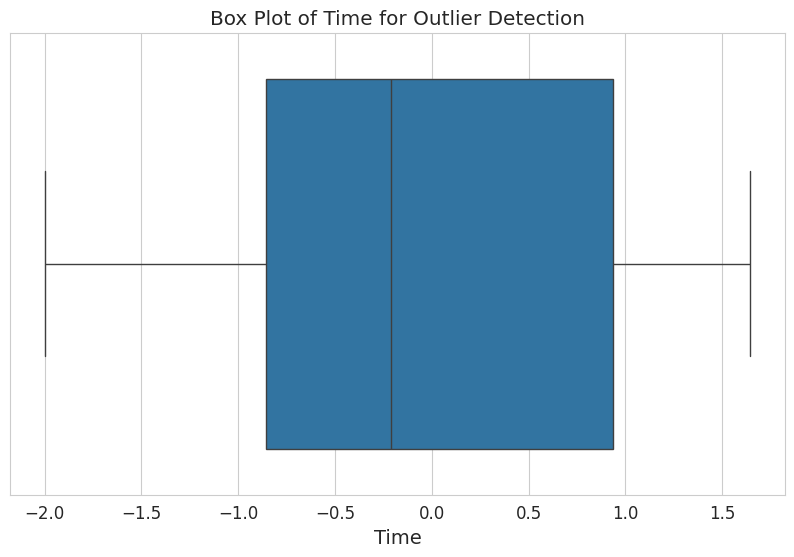


--- Outlier Analysis for Feature: V1 ---
IQR for V1: 1.15
Lower Bound: -2.19, Upper Bound: 2.39
Number of outliers detected: 6948
Outlier percentage: 2.45%
Sample outliers:
18    -2.775725
83    -2.351620
135   -2.622040
141   -2.716543
159   -3.130952
Name: V1, dtype: float64


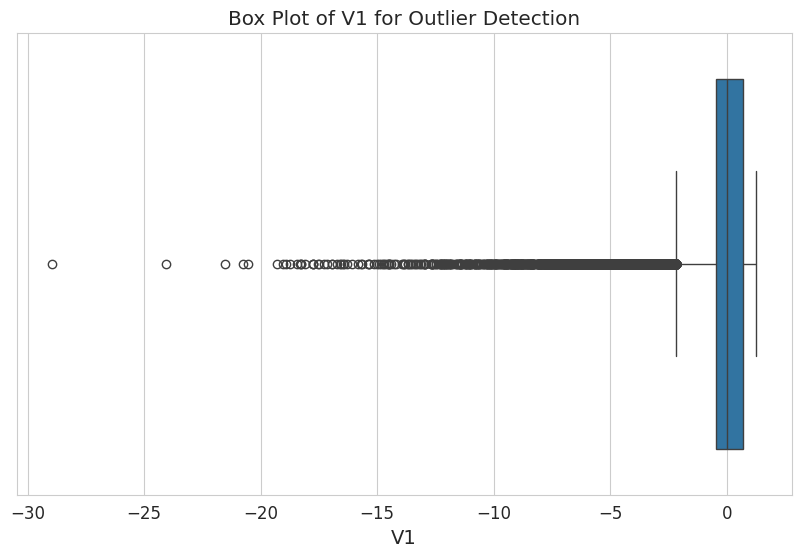


--- Outlier Analysis for Feature: V2 ---
IQR for V2: 0.85
Lower Bound: -1.64, Upper Bound: 1.76
Number of outliers detected: 13390
Outlier percentage: 4.72%
Sample outliers:
18    -3.307228
83    -2.687222
87    -2.515256
141    2.946170
159   -7.354149
Name: V2, dtype: float64


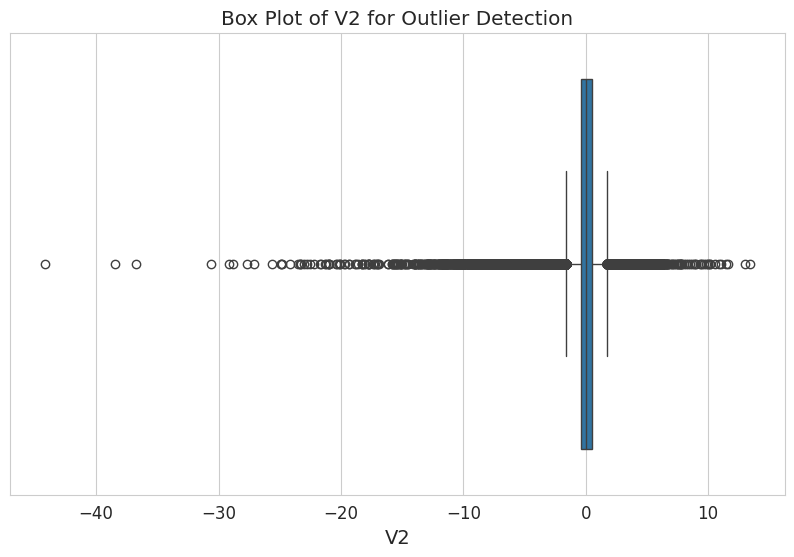


--- Outlier Analysis for Feature: V3 ---
IQR for V3: 1.27
Lower Bound: -2.50, Upper Bound: 2.59
Number of outliers detected: 3306
Outlier percentage: 1.17%
Sample outliers:
159    -3.775876
951     2.661897
1621   -8.213249
3991    2.717677
5223   -2.702724
Name: V3, dtype: float64


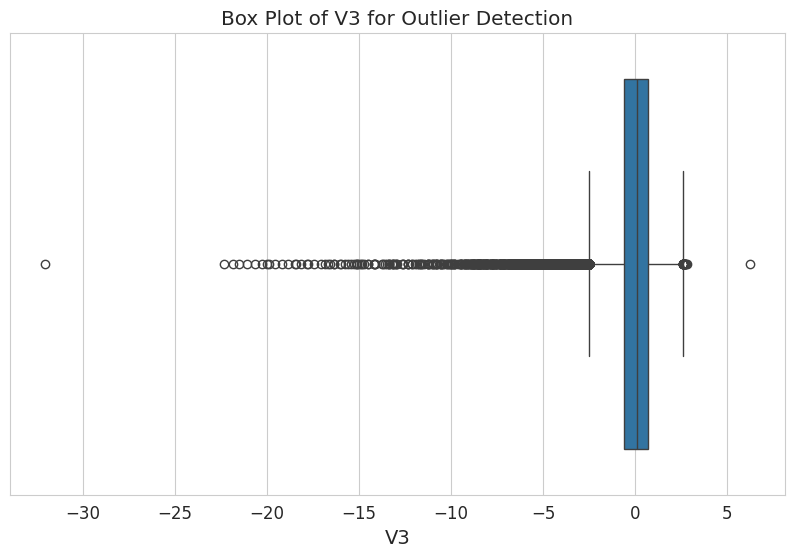


--- Outlier Analysis for Feature: IsRefund ---
IQR for IsRefund: 0.00
Lower Bound: 0.00, Upper Bound: 0.00
Number of outliers detected: 0


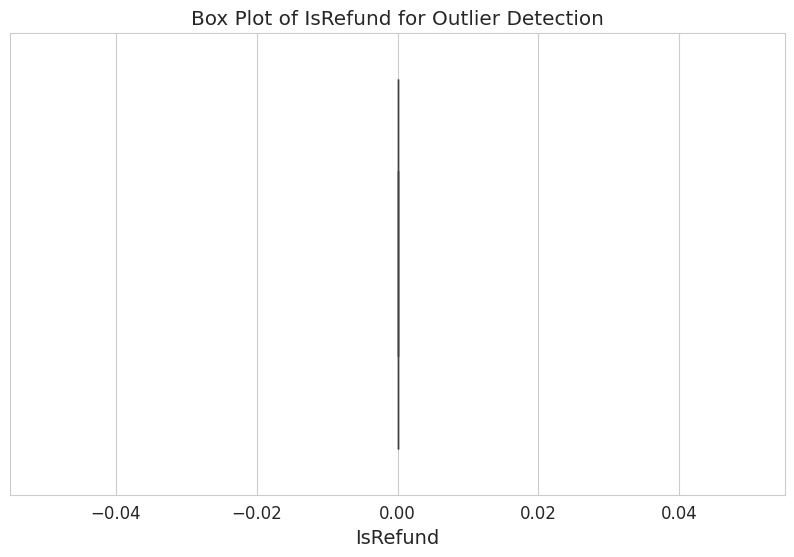

In [22]:
if not creditcard_processed_df.empty:
    print("\n--- Outlier Analysis for Bank Credit Card Fraud Data ---")
    outlier_analyzer = OutlierAnalyzer(IQRBasedOutlierAnalysis())

    # Focus on key numerical features
    creditcard_outlier_cols = ['Amount', 'Time', 'V1', 'V2', 'V3', 'IsRefund']
    creditcard_outlier_cols = [col for col in creditcard_outlier_cols if col in creditcard_processed_df.columns]

    for col in creditcard_outlier_cols:
        outlier_analyzer.execute_analysis(creditcard_processed_df, col)
else:
    print("Bank Credit Card Fraud Data is empty, skipping Outlier Analysis.")


### **4.7 Temporal Trend Analysis**

In [ ]:
if not creditcard_processed_df.empty:
    print("\n--- Temporal Analysis for Bank Credit Card Fraud Data ---")

    # Time is in seconds, so direct line plot is more appropriate than monthly trends
    if 'Time' in creditcard_processed_df.columns and 'Amount' in creditcard_processed_df.columns:
        print(f"Plotting Transaction Amount over Time for Bank Credit Card Fraud Data...")
        plt.figure(figsize=(14, 7))
        sns.lineplot(x='Time', y='Amount', data=creditcard_processed_df, alpha=0.6)
        plt.title(f'Transaction Amount Over Time (Bank Credit Card Fraud Data)')
        plt.xlabel('Time (seconds from first transaction)')
        plt.ylabel('Transaction Amount')
        plt.show()
    else:
        print("Required columns 'Time' or 'Amount' not found for temporal analysis of amount.")

    # Plot fraud incidents over time
    if CREDITCARD_TARGET_COL in creditcard_processed_df.columns and 'Time' in creditcard_processed_df.columns:
        fraud_over_time = creditcard_processed_df[creditcard_processed_df[CREDITCARD_TARGET_COL] == 1]
        if not fraud_over_time.empty:
            print(f"Plotting Fraud Incidents over Time for Bank Credit Card Fraud Data...")
            plt.figure(figsize=(14, 7))
            sns.histplot(x='Time', data=fraud_over_time, bins=50, kde=True, color='red')
            plt.title(f'Fraud Incidents Over Time (Bank Credit Card Fraud Data)')
            plt.xlabel('Time (seconds from first transaction)')
            plt.ylabel('Number of Fraud Incidents')
            plt.show()
        else:
            print(f"No fraud incidents to plot over time in Bank Credit Card Fraud Data.")
    else:
        print("Required columns 'Time' or 'Class' not found for temporal analysis of fraud incidents.")
else:
    print("Bank Credit Card Fraud Data is empty, skipping Temporal Analysis.")


## **5. Class Imbalance Handling Demonstration**

Both fraud detection datasets are highly imbalanced, meaning the number of fraudulent transactions is significantly smaller than legitimate ones. This section demonstrates a common technique, SMOTE (Synthetic Minority Over-sampling Technique), to address this imbalance.

**Note:** In a real machine learning pipeline, SMOTE or similar techniques should only be applied to the *training data* to prevent data leakage and ensure a realistic evaluation of the model's performance on unseen data.

In [24]:
def demonstrate_class_imbalance_handling(df: pd.DataFrame, dataset_name: str, target_col: str):
    """
    Demonstrates class imbalance handling using SMOTE on a conceptual training set.
    Ensures all features are numerical before applying SMOTE.
    """
    print(f"\n--- Demonstrating Class Imbalance Handling for {dataset_name} ---")
    if df.empty or target_col not in df.columns:
        print(f"Cannot demonstrate imbalance handling for empty or missing target column in {dataset_name}.")
        return

    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    # Before splitting, ensure X contains only numerical data that SMOTE can handle.
    # The preprocessor should handle this, but adding a safeguard here.
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric_cols:
        print(f"Warning: Non-numerical columns found in features for SMOTE: {non_numeric_cols}. Attempting to one-hot encode or drop.")
        # For demonstration, we'll try to one-hot encode simple cases or drop complex ones.
        # In a full pipeline, this would be part of the ColumnTransformer.
        for col in non_numeric_cols:
            if pd.api.types.is_string_dtype(X[col]) or pd.api.types.is_object_dtype(X[col]):
                # Simple one-hot encoding for demonstration if cardinality is low
                if X[col].nunique() < 50: # Arbitrary threshold for OHE
                    print(f"One-hot encoding column: {col}")
                    X = pd.get_dummies(X, columns=[col], prefix=col, drop_first=True)
                else:
                    print(f"Dropping high-cardinality non-numeric column for SMOTE: {col}")
                    X = X.drop(columns=[col])
            else:
                print(f"Dropping unsupported non-numerical column for SMOTE: {col} (dtype: {X[col].dtype})")
                X = X.drop(columns=[col])

    # Also handle any remaining NaNs after potential OHE or drops, as SMOTE cannot handle NaNs.
    if X.isnull().any().any():
        print("Warning: NaNs detected in features for SMOTE. Imputing with 0.")
        X = X.fillna(0)

    # Convert target to integer type if it's not already, as SMOTE expects integer labels
    y = y.astype(int)

    # Split data into training and testing sets (conceptual split for demonstration)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\nOriginal training set class distribution for {dataset_name}:")
    print(y_train.value_counts())
    print(f"Fraudulent transactions: {y_train.value_counts().get(1, 0)} ({y_train.value_counts().get(1, 0) / len(y_train) * 100:.2f}%) ")

    # Apply SMOTE to the training data only
    print(f"\nApplying SMOTE to the training data for {dataset_name}...")
    smote = SMOTE(random_state=42)

    try:
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print(f"Resampled training set class distribution for {dataset_name}:")
        print(y_train_resampled.value_counts())
        print(f"Fraudulent transactions: {y_train_resampled.value_counts().get(1, 0)} ({y_train_resampled.value_counts().get(1, 0) / len(y_train_resampled) * 100:.2f}%) ")
        print("SMOTE applied successfully.")
    except Exception as e:
        print(f"Error applying SMOTE: {e}")
        print("This might be due to remaining non-numerical features, or insufficient samples for SMOTE on a specific class.")
        print("Check dtypes of X_train before SMOTE:")
        print(X_train.dtypes)
        print("Number of samples per class in y_train:")
        print(y_train.value_counts())

    print(f"\n--- Class Imbalance Handling Demonstration for {dataset_name} Complete ---")

# Demonstrate for E-commerce Fraud Data
if not fraud_processed_df.empty:
    demonstrate_class_imbalance_handling(fraud_processed_df.copy(), "E-commerce Fraud Data (Fraud_Data.csv)", FRAUD_TARGET_COL)

# Demonstrate for Bank Credit Card Fraud Data
if not creditcard_processed_df.empty:
    demonstrate_class_imbalance_handling(creditcard_processed_df.copy(), "Bank Credit Card Fraud Data (creditcard.csv)", CREDITCARD_TARGET_COL)



--- Demonstrating Class Imbalance Handling for E-commerce Fraud Data (Fraud_Data.csv) ---
Dropping unsupported non-numerical column for SMOTE: TransactionStartTime (dtype: datetime64[ns])

Original training set class distribution for E-commerce Fraud Data (Fraud_Data.csv):
class
0    95872
1     9906
Name: count, dtype: int64
Fraudulent transactions: 9906 (9.36%) 

Applying SMOTE to the training data for E-commerce Fraud Data (Fraud_Data.csv)...
Resampled training set class distribution for E-commerce Fraud Data (Fraud_Data.csv):
class
0    95872
1    95872
Name: count, dtype: int64
Fraudulent transactions: 95872 (50.00%) 
SMOTE applied successfully.

--- Class Imbalance Handling Demonstration for E-commerce Fraud Data (Fraud_Data.csv) Complete ---

--- Demonstrating Class Imbalance Handling for Bank Credit Card Fraud Data (creditcard.csv) ---

Original training set class distribution for Bank Credit Card Fraud Data (creditcard.csv):
Class
0    198277
1       331
Name: count, dtype: i

## **6. Key Insights & Summary**

This section will summarize the key findings from the EDA for both datasets, highlighting important characteristics, potential challenges, and recommendations for the subsequent modeling phases.

### E-commerce Fraud Data (Fraud_Data.csv)

- **Data Quality:** The dataset is remarkably clean with no missing values after initial preprocessing. However, negative `Amount` values were identified, which were handled by converting to absolute value and creating an `IsRefund` flag. This flag can be a crucial feature for distinguishing transaction types.
- **Feature Distributions:**
    - `Amount` and `age` show highly skewed distributions with significant outliers, indicating a need for robust scaling or transformation during model training.
    - Categorical features like `source`, `browser`, `sex`, and `country` have varying distributions, with some having dominant categories and others being more spread out. The `country` feature, derived from IP addresses, provides geographical context.
- **Engineered Features:**
    - Temporal features (`TransactionHour`, `TransactionDayOfWeek`, `TransactionMonth`, `TransactionYear`) were successfully extracted, allowing for analysis of time-based patterns.
    - `time_since_signup` provides insight into user tenure, which could be related to fraud risk.
    - Transaction frequency and velocity features (e.g., `CustomerId_transactions_last_X_d`, `CustomerId_total_amount_last_X_d`) are critical for identifying unusual spending behaviors over time, often a strong indicator of fraud.
- **Class Imbalance:** The `class` target variable is highly imbalanced (very few fraud cases). This is a major challenge that requires specific handling during model training (e.g., SMOTE, class weights, or advanced sampling techniques) and careful selection of evaluation metrics (e.g., Precision, Recall, F1-score, AUC-ROC) rather than accuracy.
- **Relationships:** Initial bivariate and multivariate analyses suggest potential relationships between transaction amounts, temporal features, and fraud. Features like `Amount` and engineered velocity features are expected to be highly indicative of fraudulent activity.

### Bank Credit Card Fraud Data (creditcard.csv)

- **Data Anonymity:** The `V` features are PCA-transformed, which means their direct interpretation is not possible. Analysis relies on their statistical properties and relationships.
- **Data Quality:** This dataset also appears to be very clean with no missing values after preprocessing. The `Amount` column was processed similarly to the e-commerce data to handle potential negative values (though none were observed in this dataset's summary statistics, the `IsRefund` flag is still useful for consistency).
- **Feature Distributions:**
    - `Time` and `Amount` are the original features, with `Time` representing seconds from the first transaction. Both show distinct distributions that might reveal temporal patterns in fraudulent activities.
    - The `V` features have varying distributions, some appearing more Gaussian-like, others skewed.
- **Class Imbalance:** Similar to the e-commerce data, the `Class` target variable is extremely imbalanced, with a very small percentage of fraudulent transactions. This is the primary challenge for modeling this dataset and necessitates robust imbalance handling strategies.
- **Relationships:** Correlation analysis among `V` features is crucial, as PCA aims to create uncorrelated components. However, their relationship with the `Amount`, `Time`, and `Class` (target) is key. Some `V` features (e.g., V17, V14, V12, V10) are often reported as highly correlated with fraud in similar datasets.
- **Temporal Patterns:** While `Time` is not a standard datetime, its numerical nature allows for plotting trends of fraud occurrences over time, which can reveal specific windows of increased fraudulent activity.

### Overall Recommendations for Modeling

- **Imbalance Handling:** Given the severe class imbalance in both datasets, robust techniques like SMOTE, ADASYN, or Borderline-SMOTE should be applied to the training data. Alternatively, using class weights in models (e.g., Logistic Regression, XGBoost, LightGBM) or employing anomaly detection algorithms could be considered.
- **Evaluation Metrics:** Accuracy is misleading for imbalanced datasets. Focus on metrics like Precision, Recall, F1-score, AUC-ROC, and Confusion Matrix to evaluate model performance effectively.
- **Feature Scaling:** All numerical features (including engineered ones) should be scaled (e.g., `StandardScaler`, `MinMaxScaler`) before training most machine learning models, especially those sensitive to feature scales (e.g., SVMs, Logistic Regression, Neural Networks).
- **Categorical Encoding:** One-Hot Encoding has been applied for categorical features. For high-cardinality features not handled by aggregation (e.g., `AccountId` if not aggregated), alternative encoding methods like Target Encoding or Frequency Encoding might be explored if direct OHE leads to too many sparse features.
- **Outlier Treatment:** While outliers were visualized, a decision on how to treat them (e.g., winsorization, removal, or using models robust to outliers like tree-based models) should be made based on further experimentation.
- **Temporal Aspects:** For the e-commerce data, the engineered temporal features are valuable. For both datasets, consider time-based splitting of data (e.g., training on older data, testing on newer data) to ensure the model generalizes well to future, unseen transactions, as fraud patterns can evolve over time.